In [33]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Embedded Method

In [34]:
# Plot correlation matrix
def correlation_matrix_plot(df, asset):
    correlation_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
    plt.figure(figsize=(18, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.9, fmt=".2f")
    plt.title(f'Correlation Matrix of {asset}')
    plt.tight_layout()
    plt.show()

In [35]:
def generate_feat_sel_bar_plot(feat_importances, asset_name):
    plt.figure(figsize=(12, 6))
    ax = feat_importances.plot(kind='bar', title=f'Feature Importances - {asset_name}')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=90)

    # Add rounded importance values as labels on bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [36]:
index_features_dict = {}
mutual_funds_features_dict = {}
gold_bonds_features_dict = {}

In [37]:
def filter_features(feat_importances, threshold=0.01):
    return feat_importances[feat_importances > threshold].index.tolist()

In [49]:
# Feature Selection Pipeline
def select_features_rf(df, asset_name="Asset", feature_name='', create_features=True, features_dict={}):
    """
    Performs feature selection using a Random Forest regressor to extract feature importances for a given asset's DataFrame.

    Required Features: All features of the asset and performs additional engineering (e.g., moving averages).
    Parameters:
        df (pd.DataFrame): The input DataFrame for the asset.
        asset_name (str): Identifier for plotting and output.
        create_features (bool): Boolean value to create features.

    Returns:
        feat_importances (pd.Series): Feature importances sorted in descending order.
    """
    # 1. Preprocessing and Feature Engineering
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)


    # Add indicators that improve models to predict better
    window=14

    df['Close_High_Ratio'] = (df['Close'] - df['High']) / df['High']
    df['Close_Low_Ratio'] = (df['Close'] - df['Low']) / df['Low']
    
    # Volatility Features
    df['Daily_Range'] = df['High'] - df['Low']
    df['ATR'] = df['Daily_Range'].rolling(window=window).mean()
    df['Rolling_Std_Dev'] = df['Close'].rolling(window=window).std()
    
    # Momentum & Trend Features
    df['RSI'] = 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(window=window).mean() /
                                df['Close'].diff().clip(upper=0).abs().rolling(window=window).mean())))
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    
    # Candlestick Features
    df['Body_Size'] = abs(df['Close'] - df['Open'])
    df['Upper_Wick'] = df['High'] - df[['Open', 'Close']].max(axis=1)
    df['Lower_Wick'] = df[['Open', 'Close']].min(axis=1) - df['Low']


    # Define feature columns and target variable
    if create_features == True:
        features = ['Momentum_Indicator',
                    'High_Low_Change',
                    'High_Open_Change',
                    'Low_Open_Change',
                    'Percent_Change_In_Price',
                    'Close_High_Ratio',
                    'Close_Low_Ratio',
                    'Daily_Range',
                    'ATR',
                    'Rolling_Std_Dev',
                    'RSI',
                    'MACD',
                    'Body_Size',
                    'Upper_Wick',
                    'Lower_Wick',
        ]
    else:
        features = features_dict[feature_name]
    target = 'Close'

    new_df = df.dropna()
    X = new_df[features]
    y_without_reshape = new_df[target]

    y = y_without_reshape.values.reshape(-1, 1)

    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    scaled_X_data = scaler_features.fit_transform(X)
    scaled_y_data = scaler_target.fit_transform(y)

    training_size = int(len(X) * 0.8)

    X_train, X_test = scaled_X_data[:training_size], scaled_X_data[training_size:]
    y_train, y_test = scaled_y_data[:training_size], scaled_y_data[training_size:]

    # 2. Train a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=123)
    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)

    r2 = r2_score(y_test, predictions)
    print(f'R-squared: {r2}')

    # 3. Extract and Plot Feature Importances
    importances = rf.feature_importances_
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)

    print(f"\n{asset_name} - Feature Importances:")
    print(feat_importances)
    # print(feat_importances[feat_importances > 0.01])

    # 4. Plot feature importances as a bar chart
    generate_feat_sel_bar_plot(feat_importances, asset_name)

    # 5. Plot correlation matrix
    correlation_matrix_plot(pd.concat([X, y_without_reshape], axis=1), asset_name)

    return feat_importances

### Feature Selection for Indexes

### Feature Selection for Each Index ###

Processing Index: NSEI
R-squared: -3.415467284044971

Index: NSEI - Feature Importances:


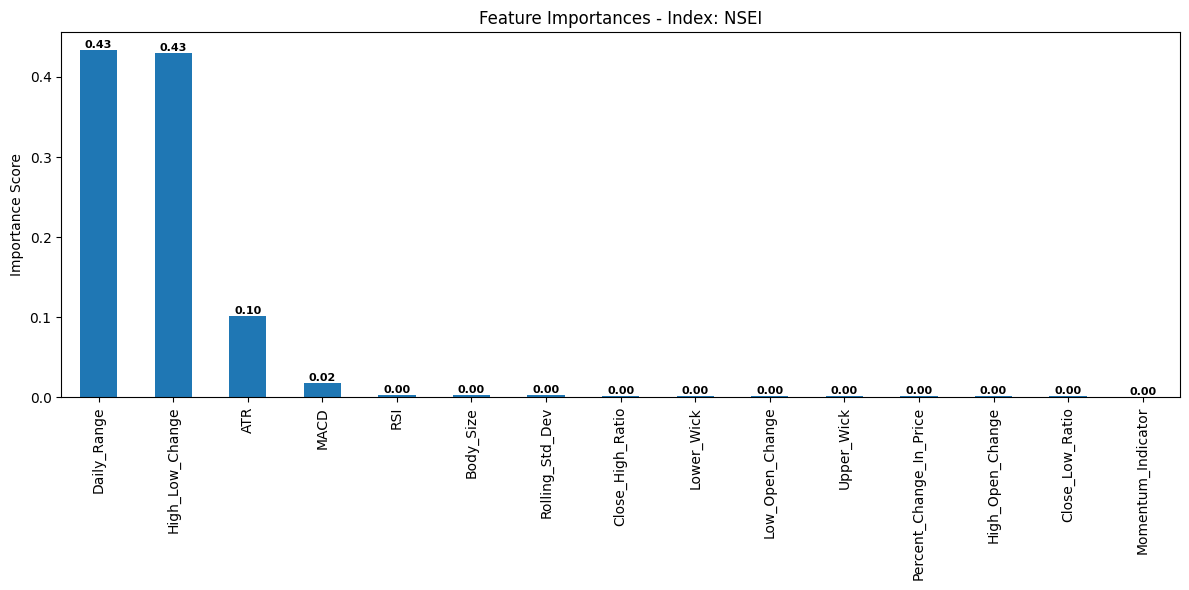

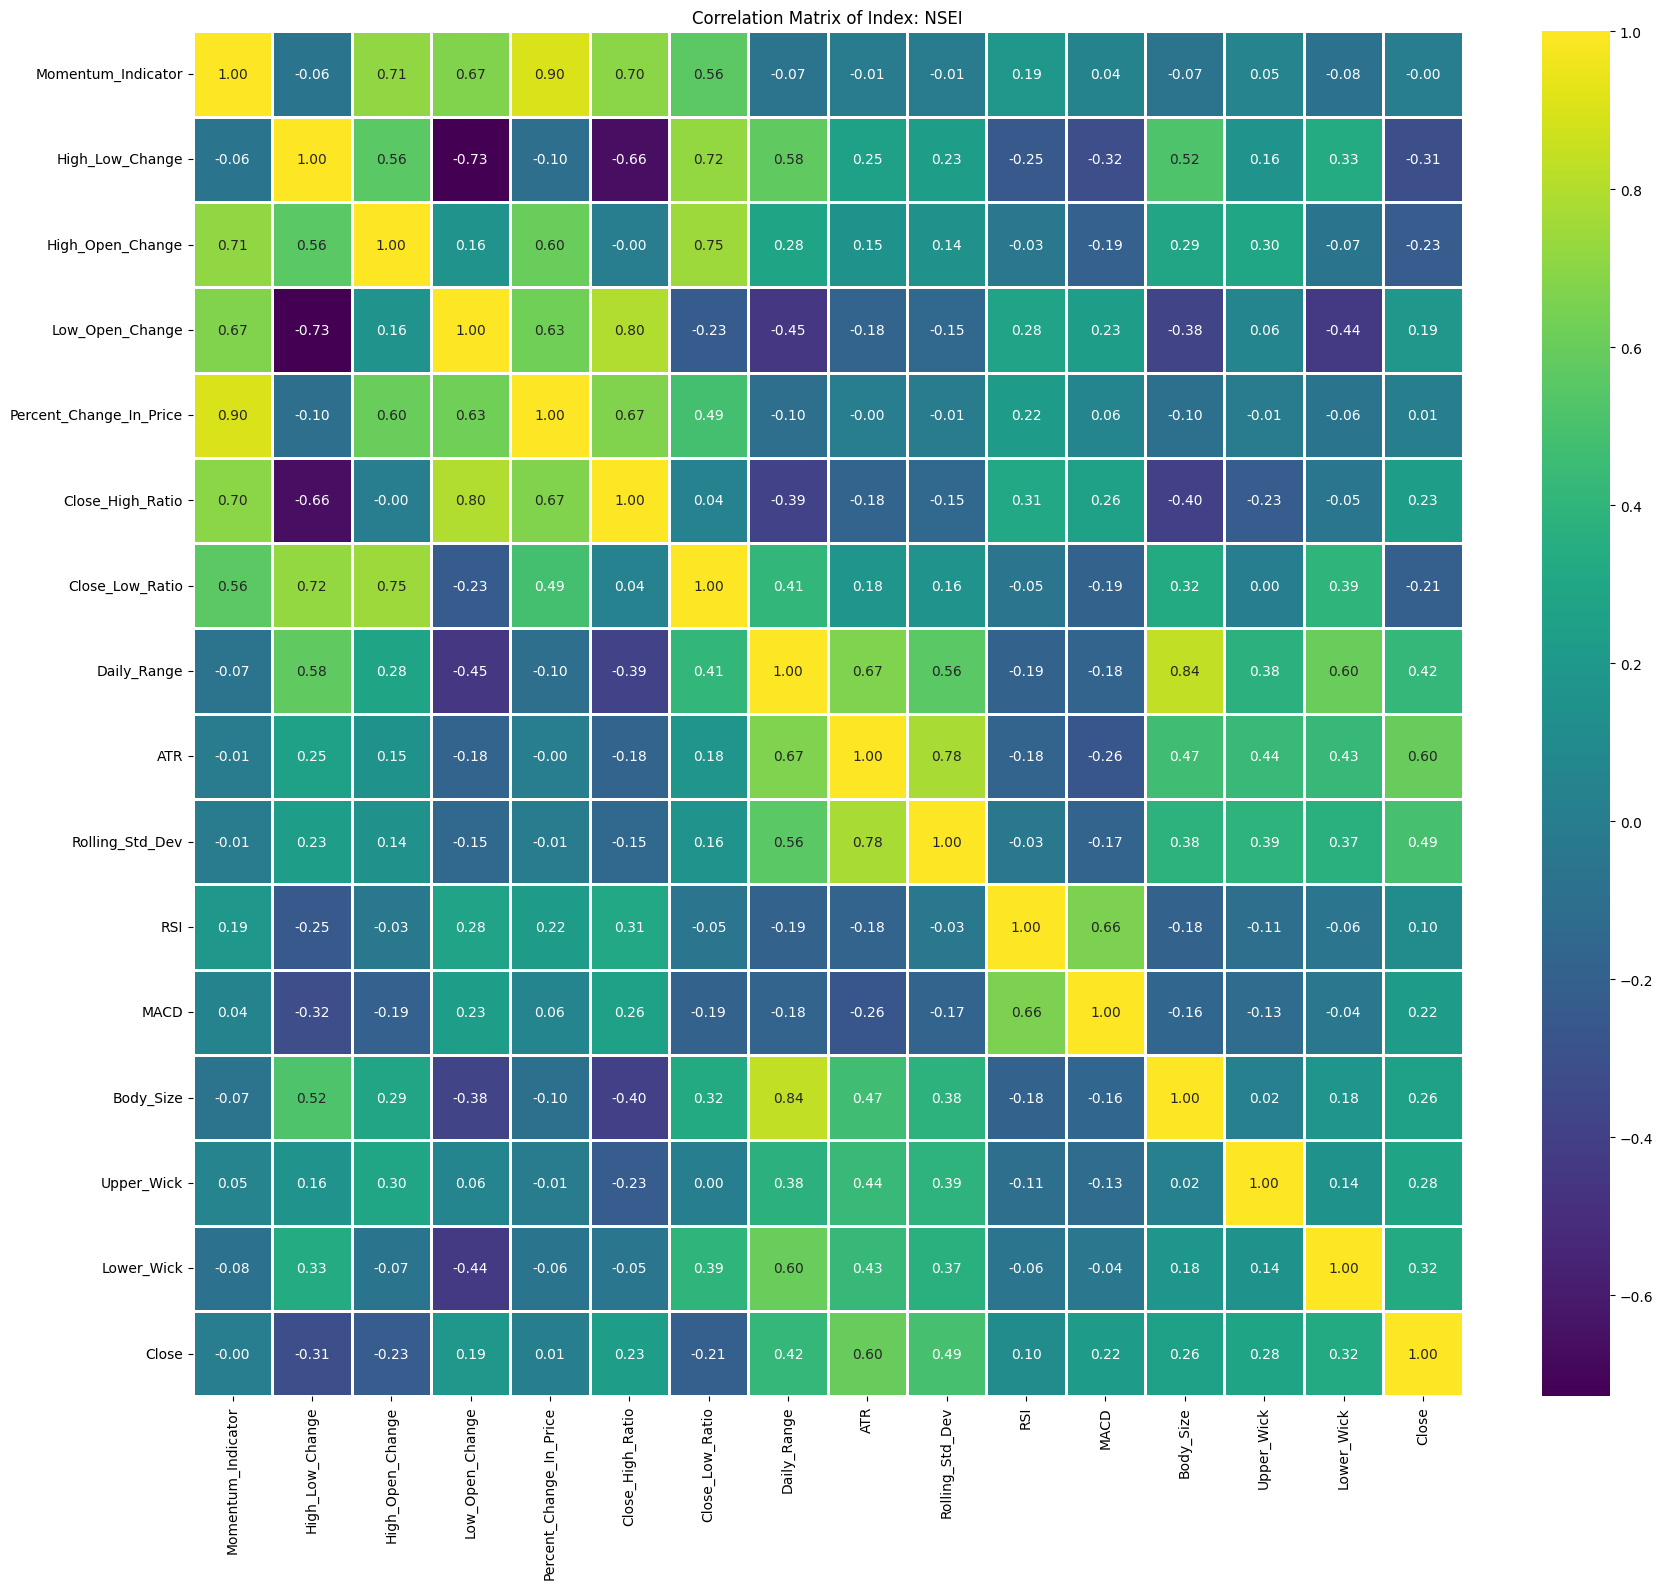


Processing Index: NSEBANK
R-squared: -3.4509646262747946

Index: NSEBANK - Feature Importances:


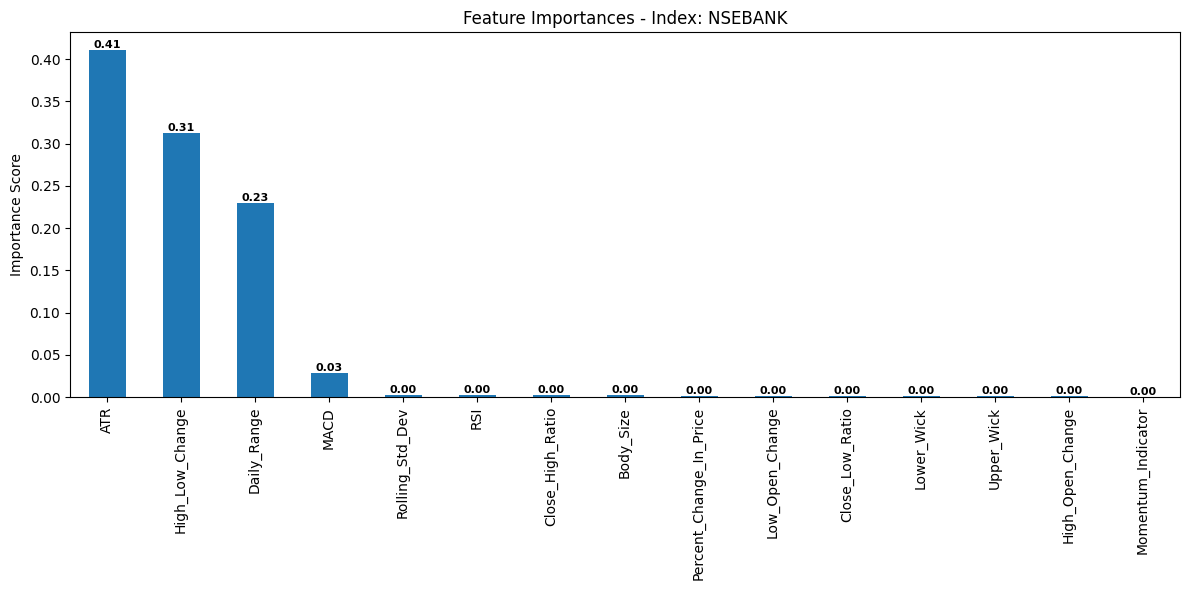

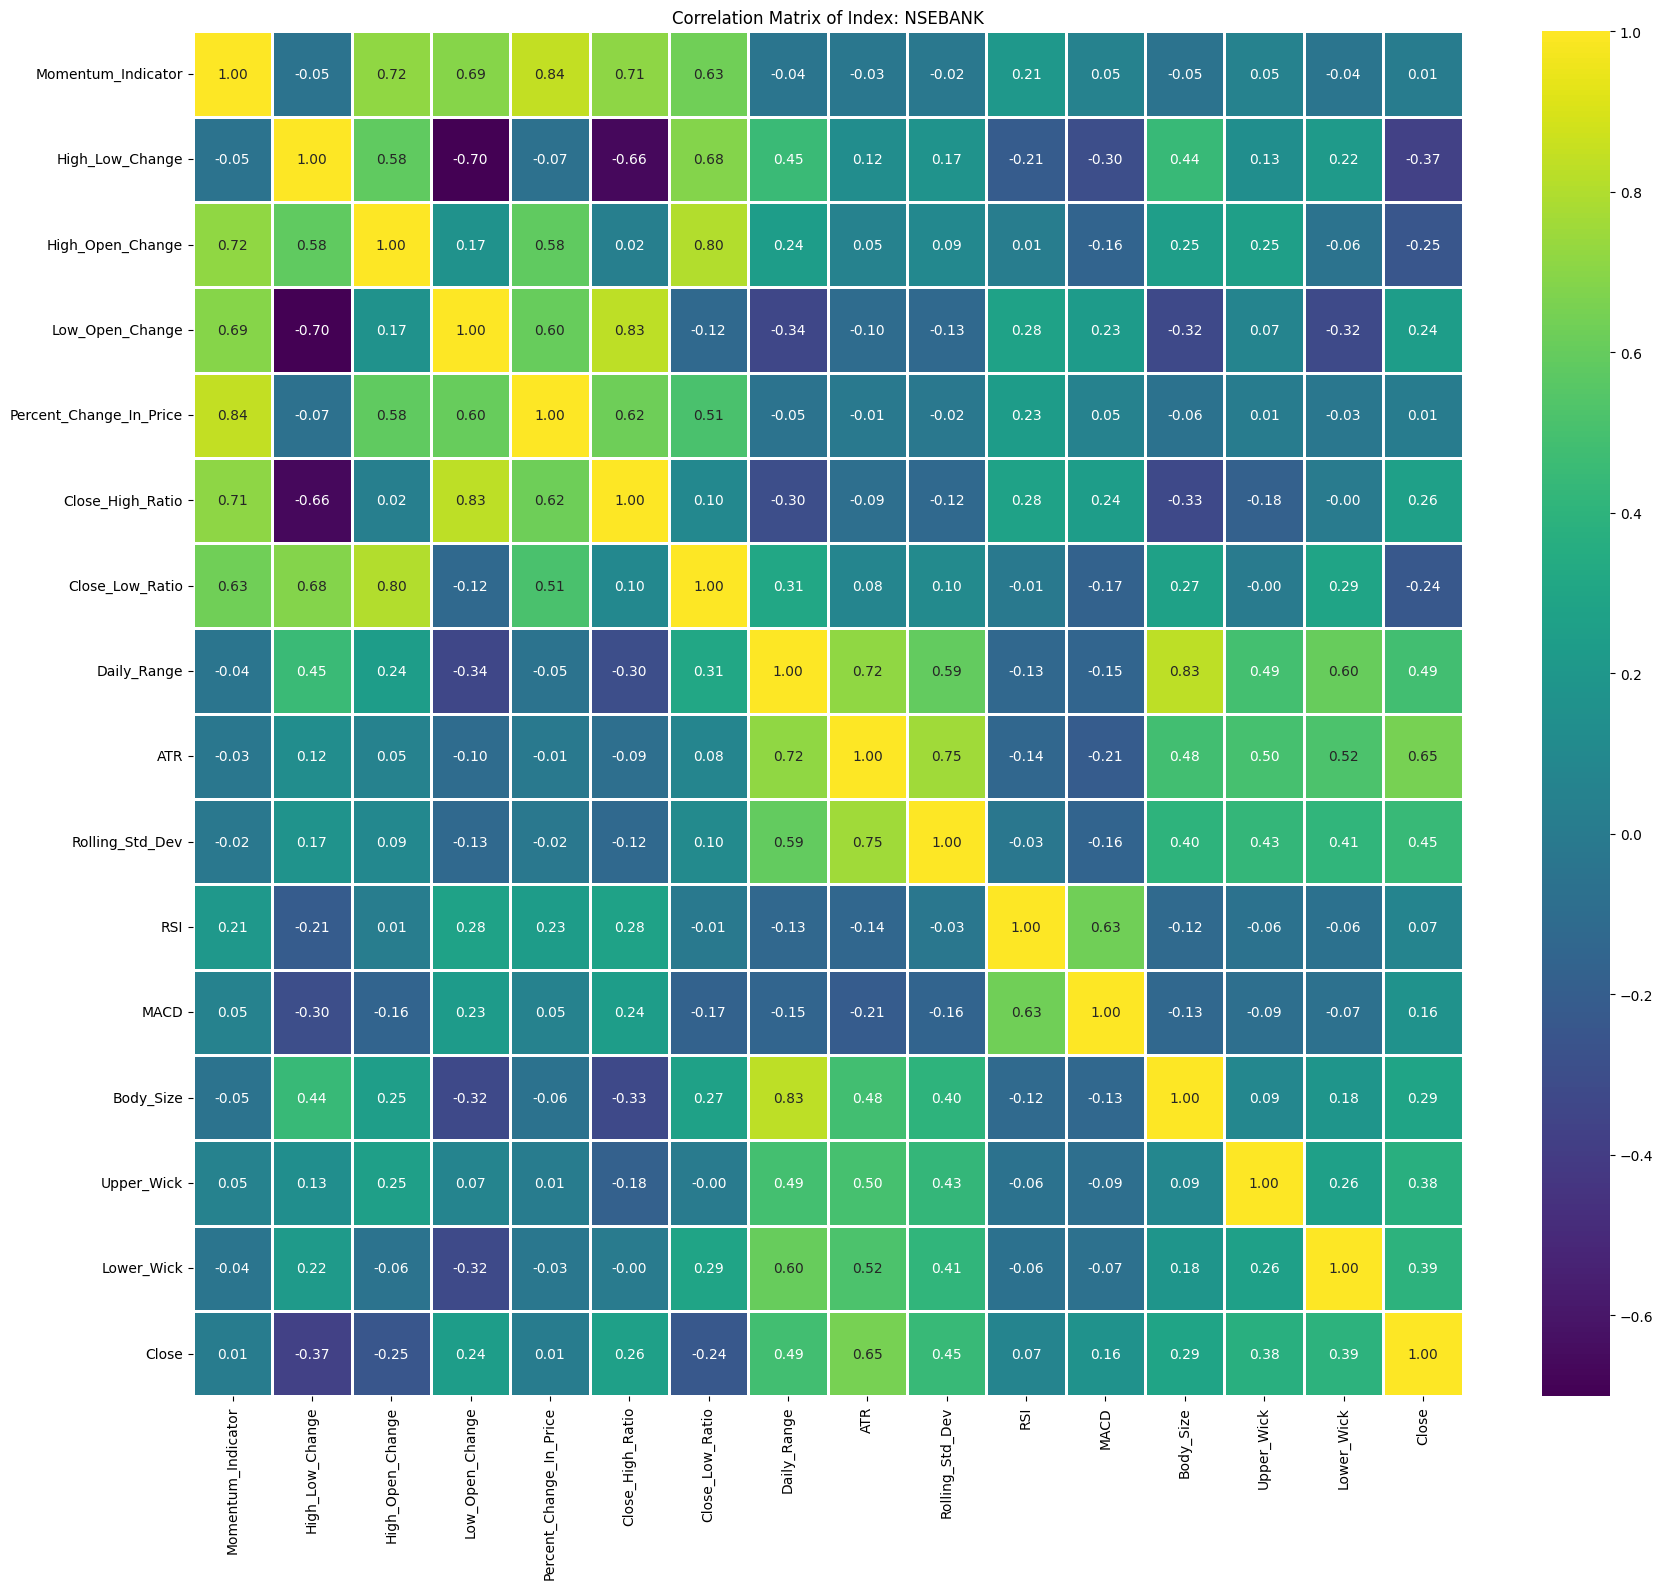


Processing Index: CNXIT
R-squared: -4.515189930095841

Index: CNXIT - Feature Importances:


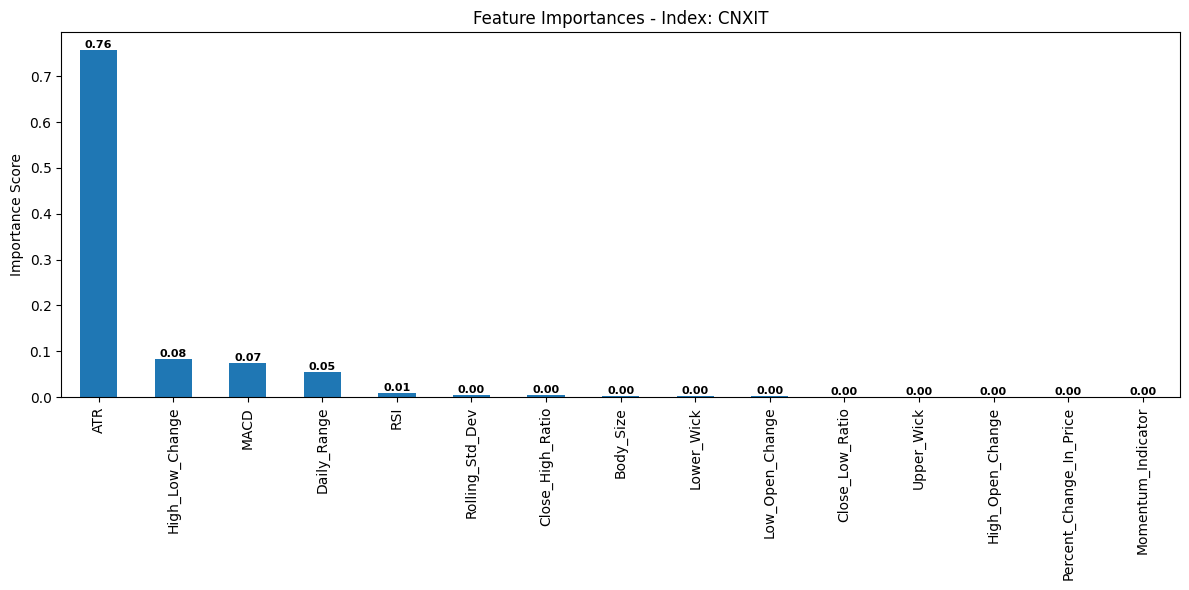

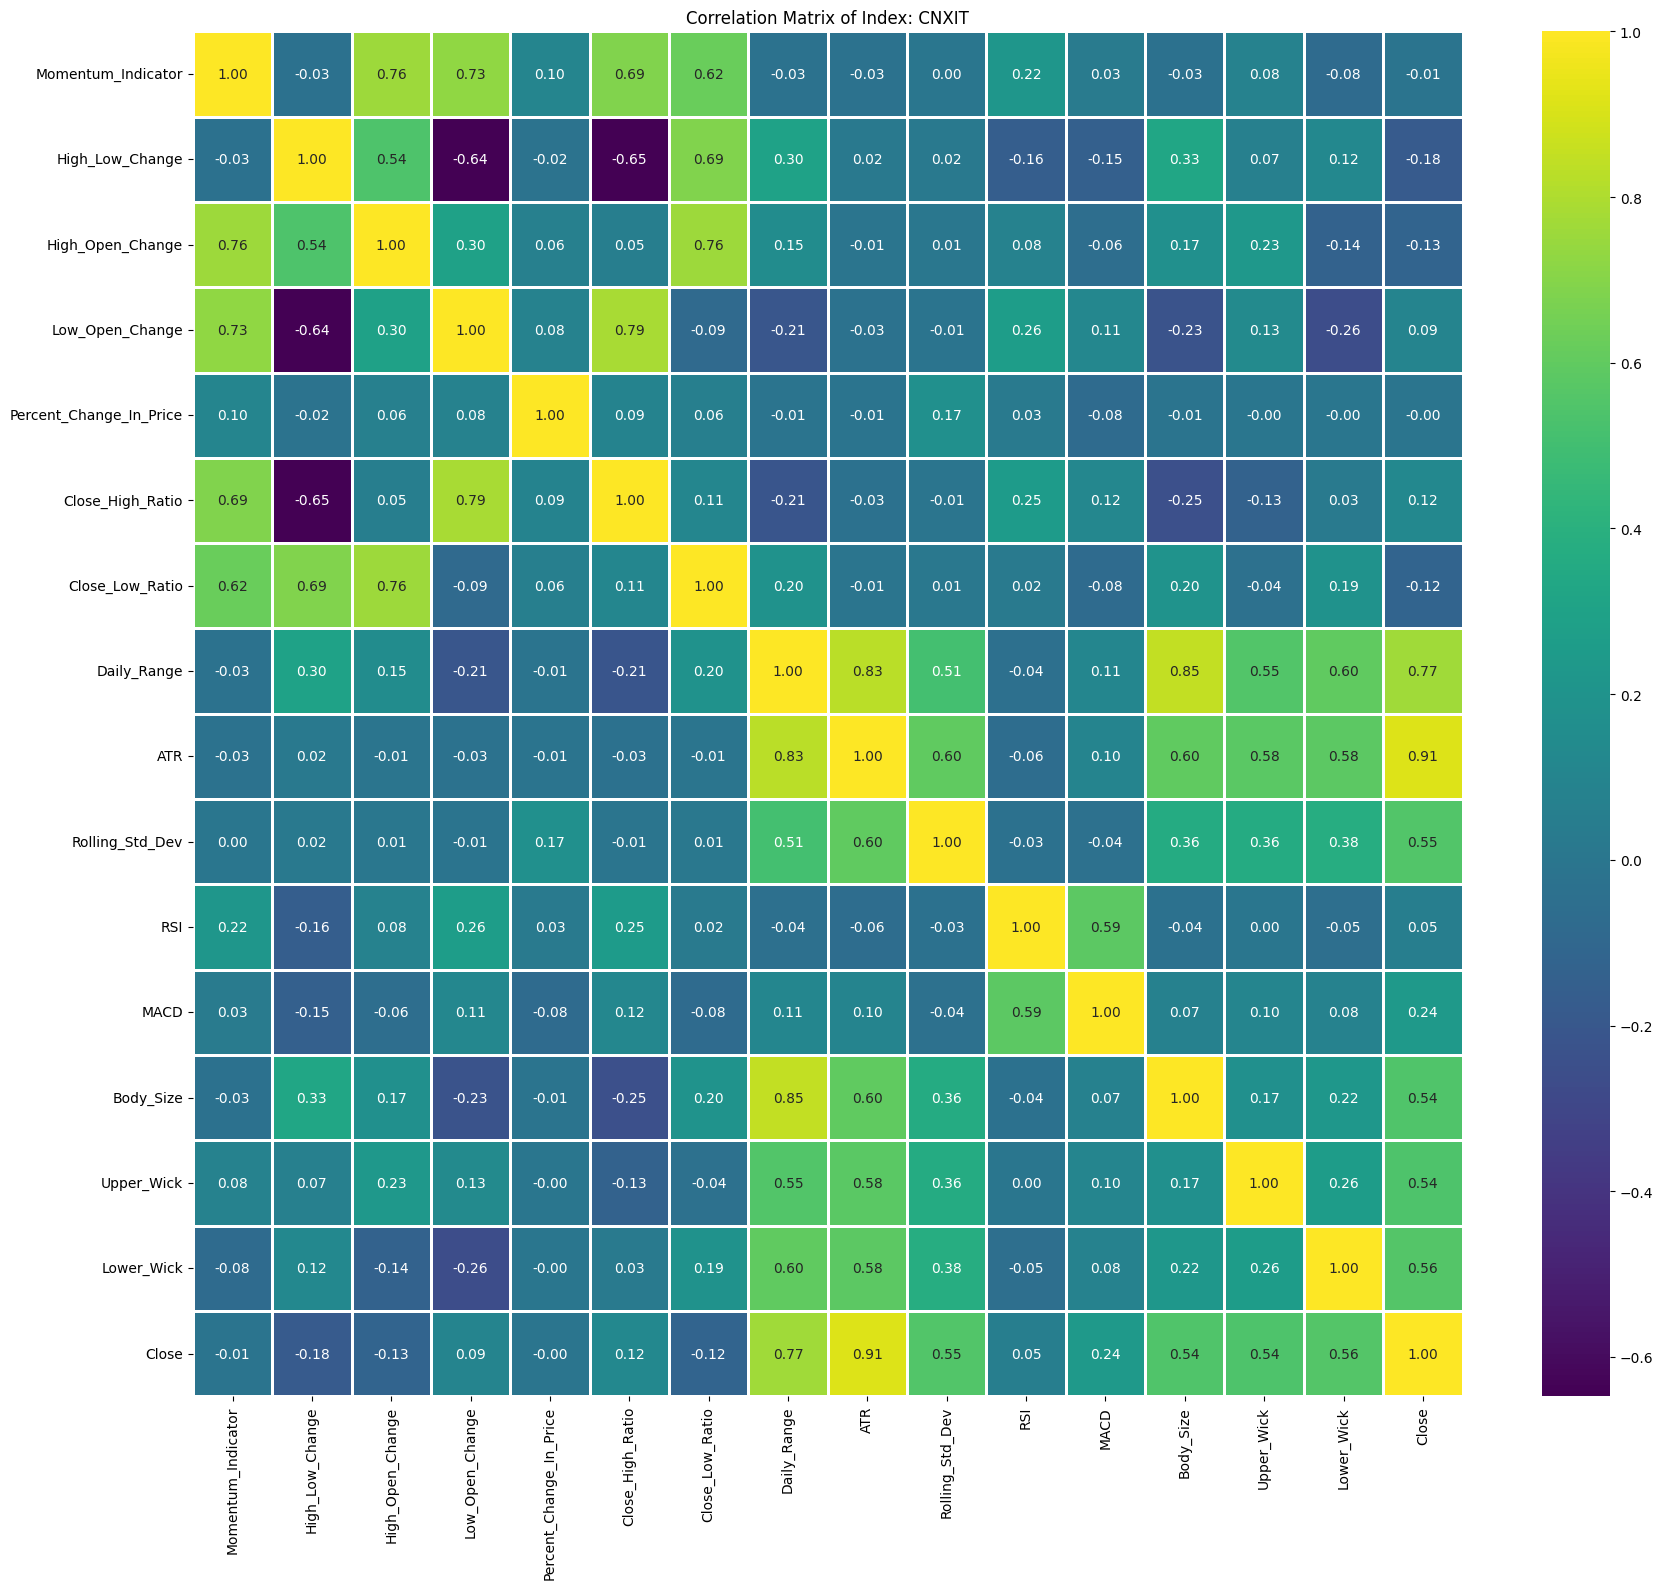


Processing Index: BSESN
R-squared: -1.8603265838553757

Index: BSESN - Feature Importances:


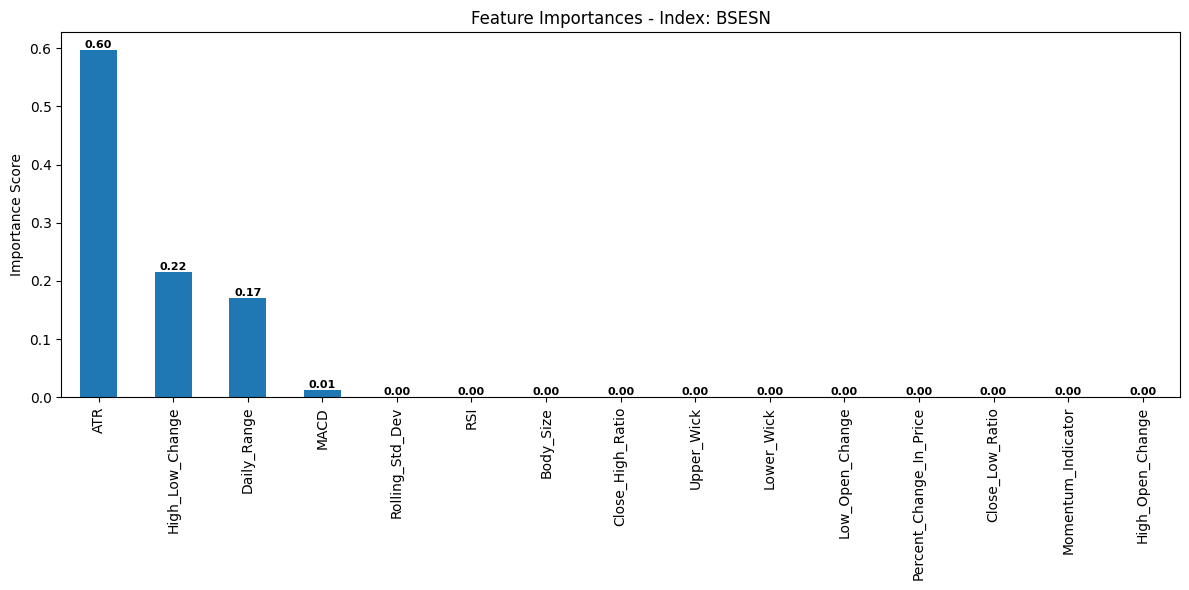

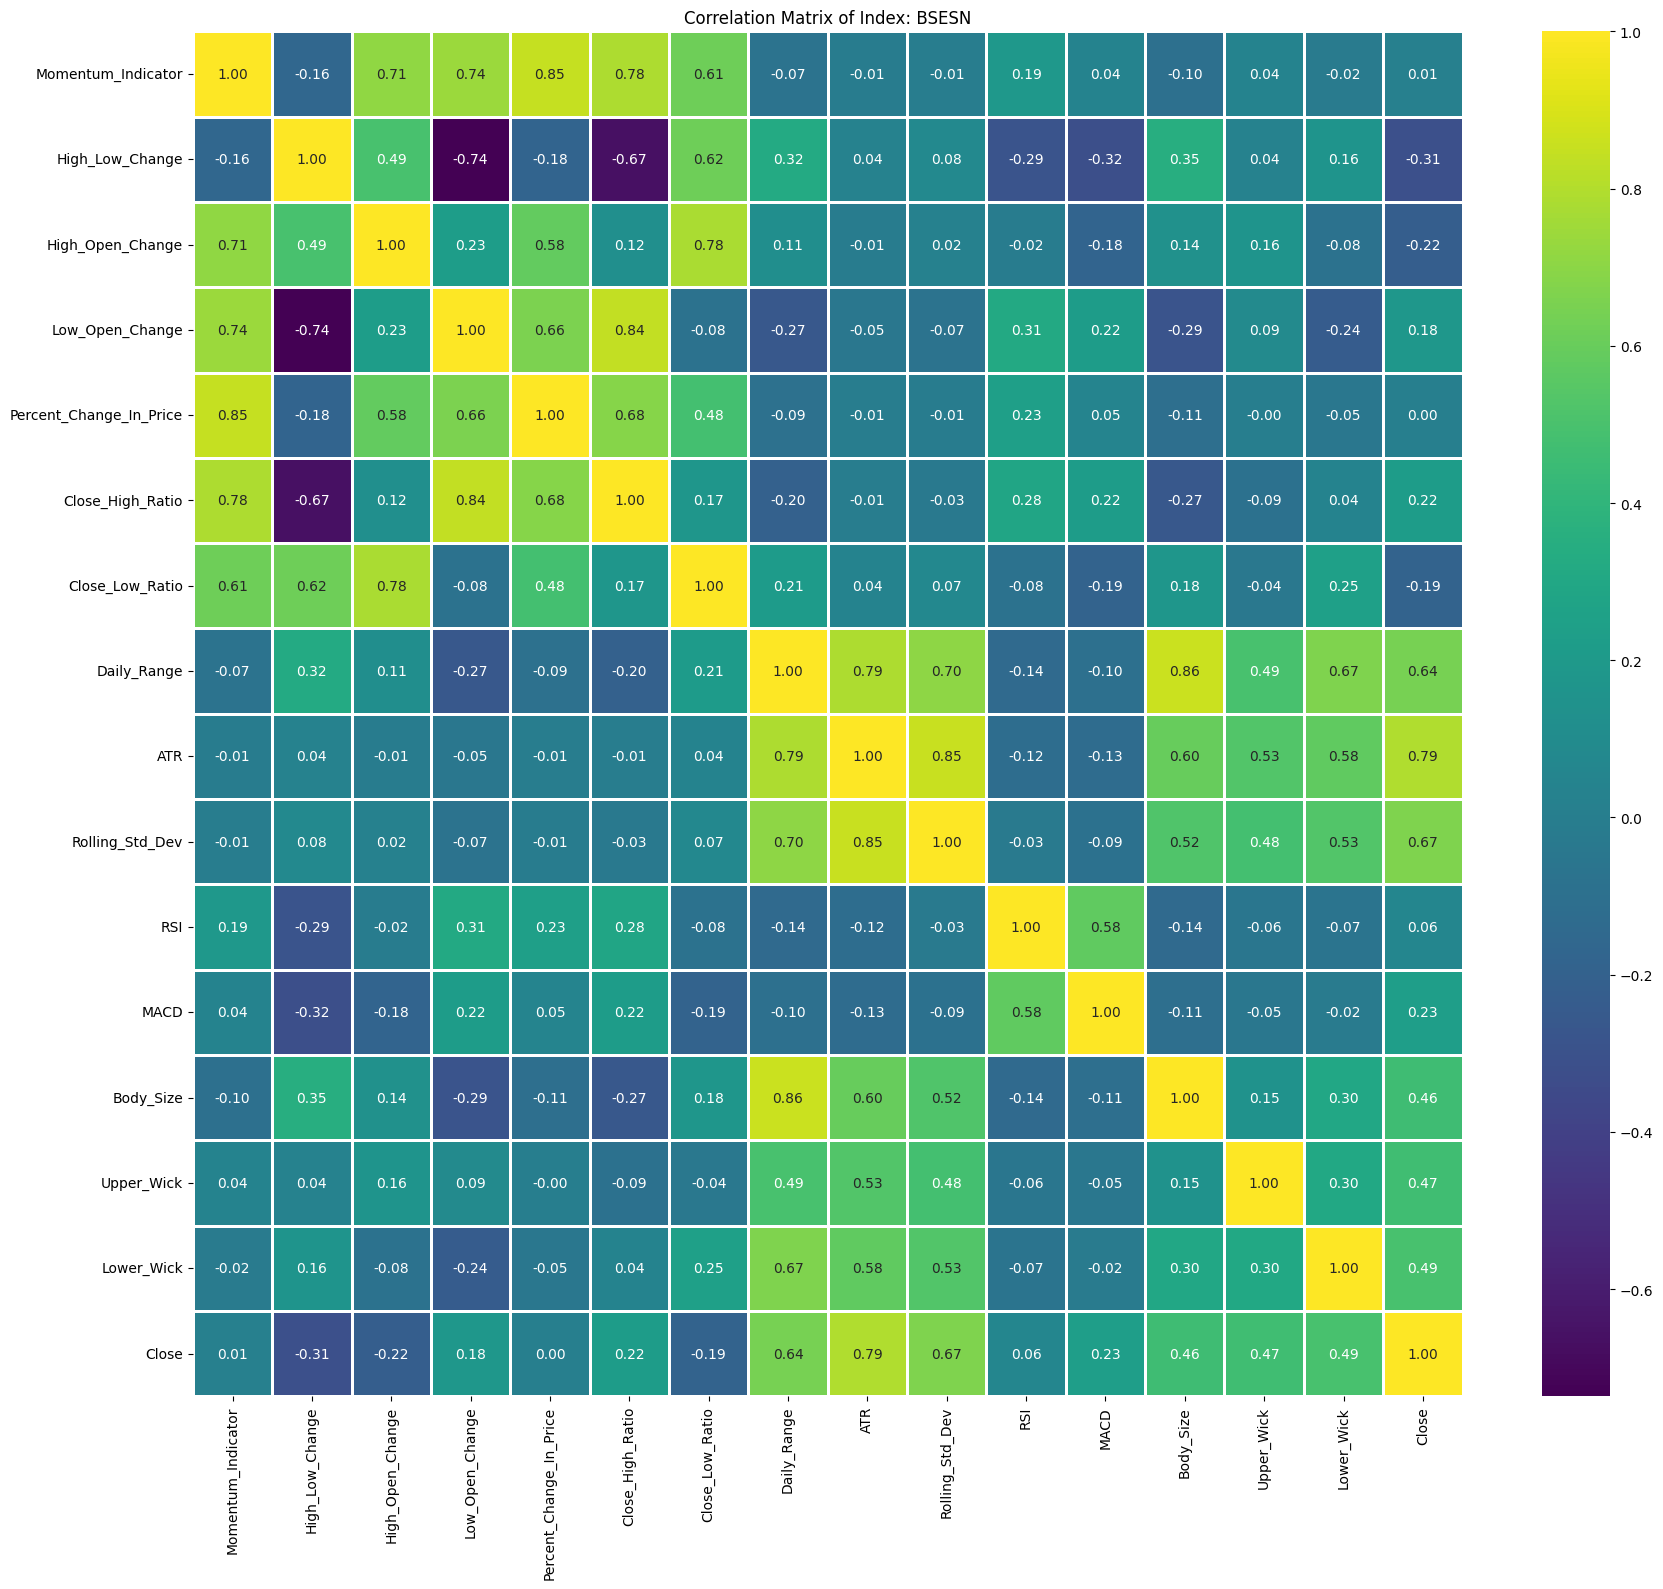


Processing Index: NIFTY_MIDCAP_100
R-squared: -2.2596912528373454

Index: NIFTY_MIDCAP_100 - Feature Importances:


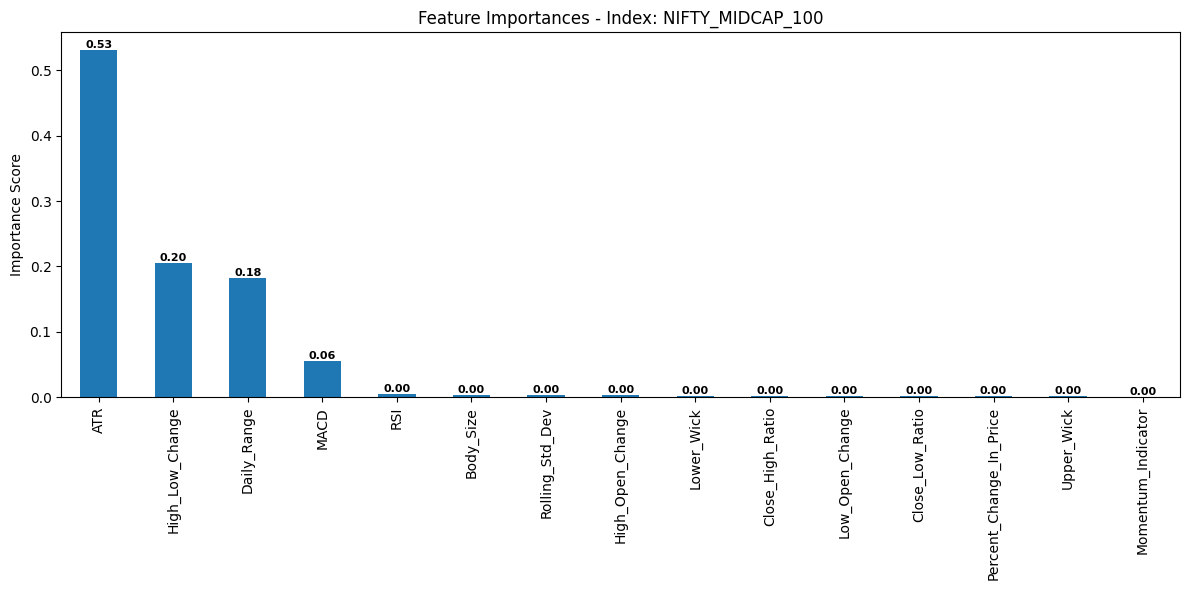

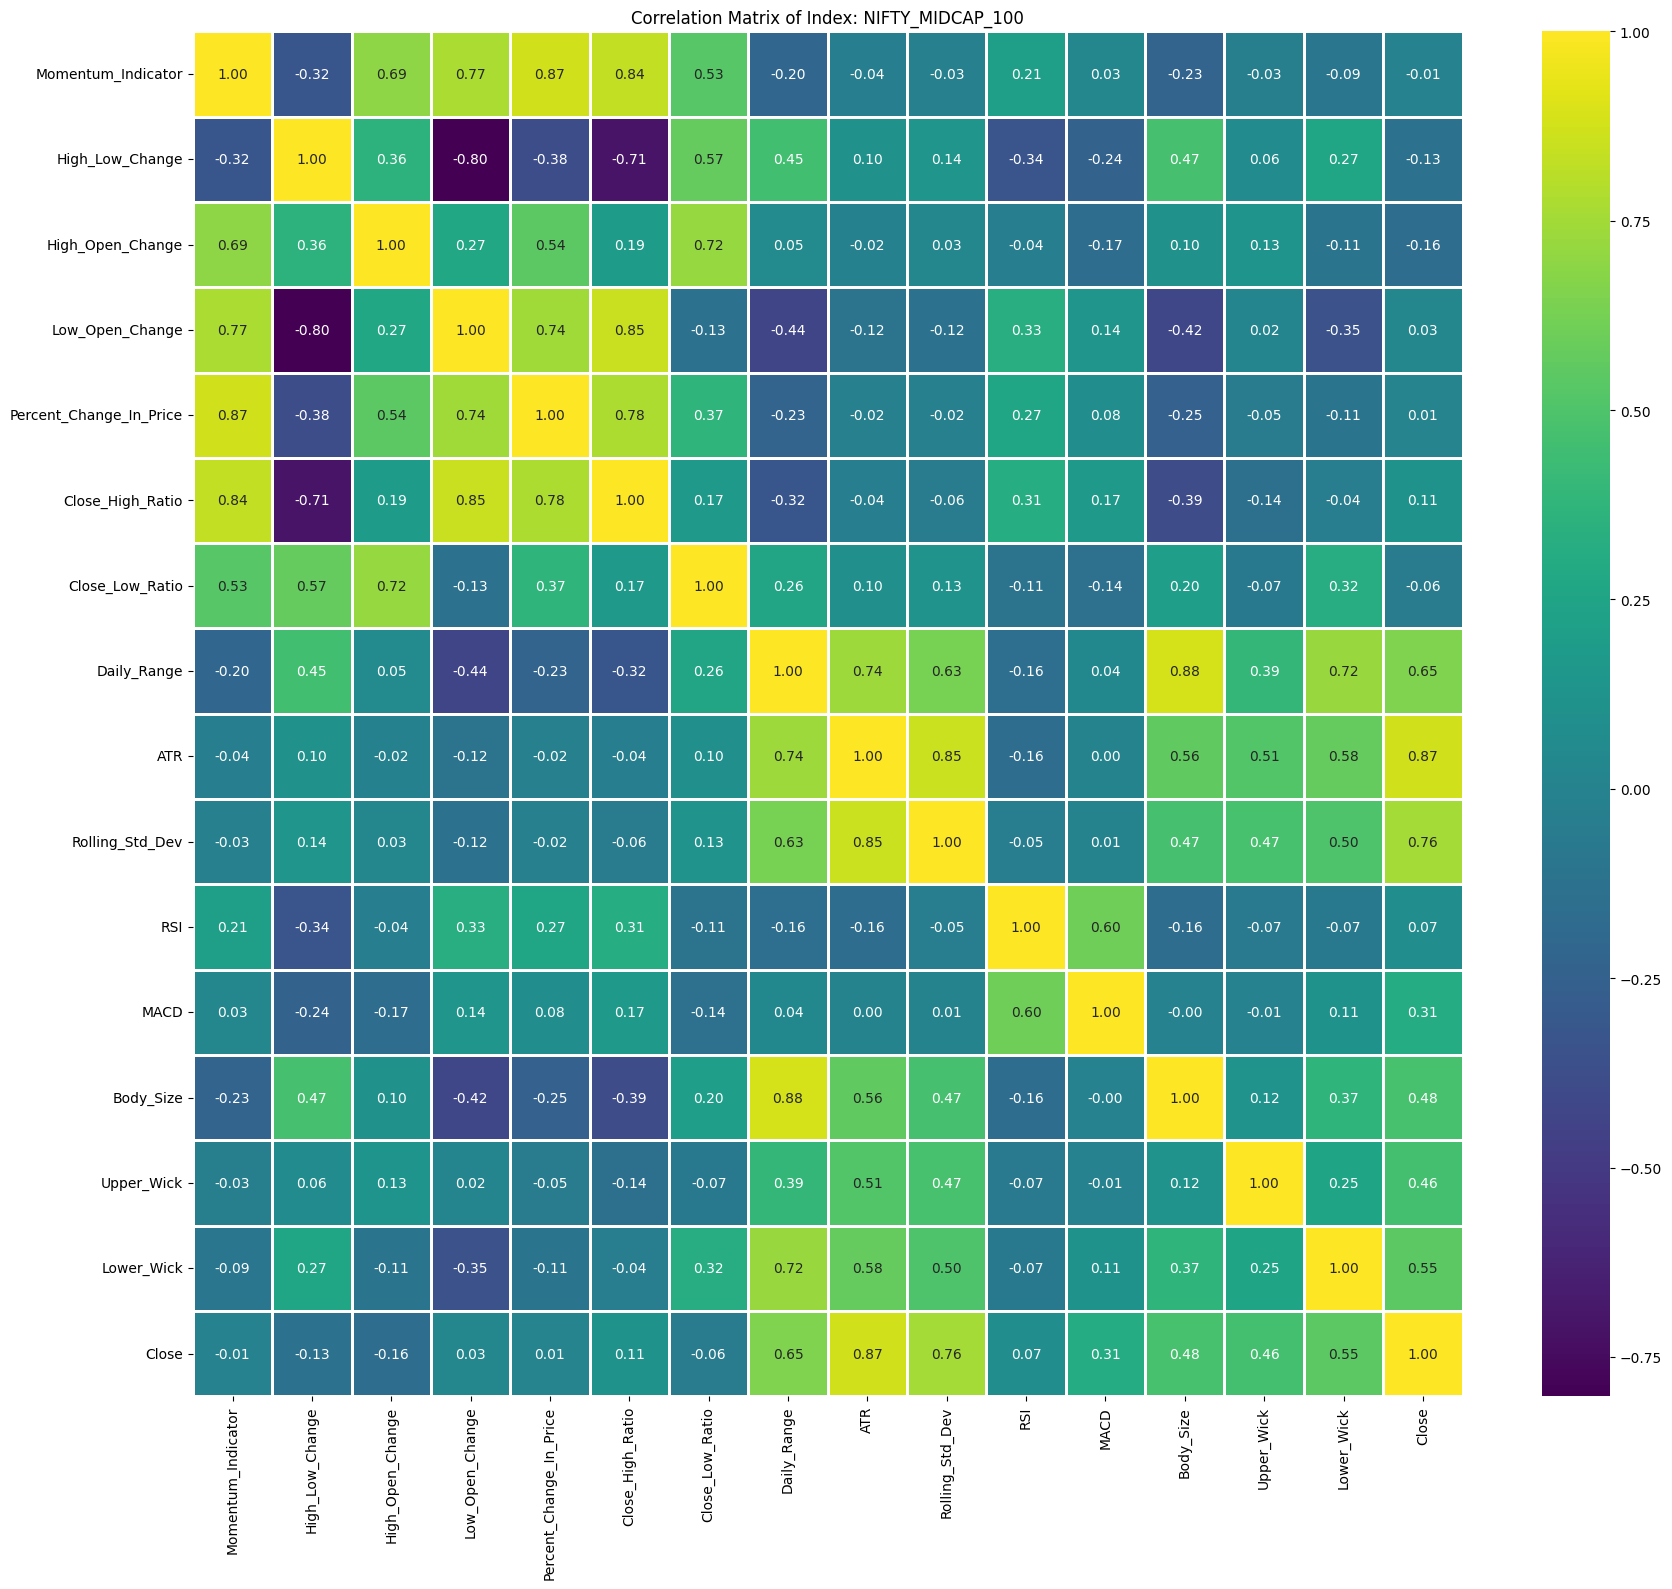


Processing Index: CNXPSUBANK
R-squared: -0.6352610081981533

Index: CNXPSUBANK - Feature Importances:


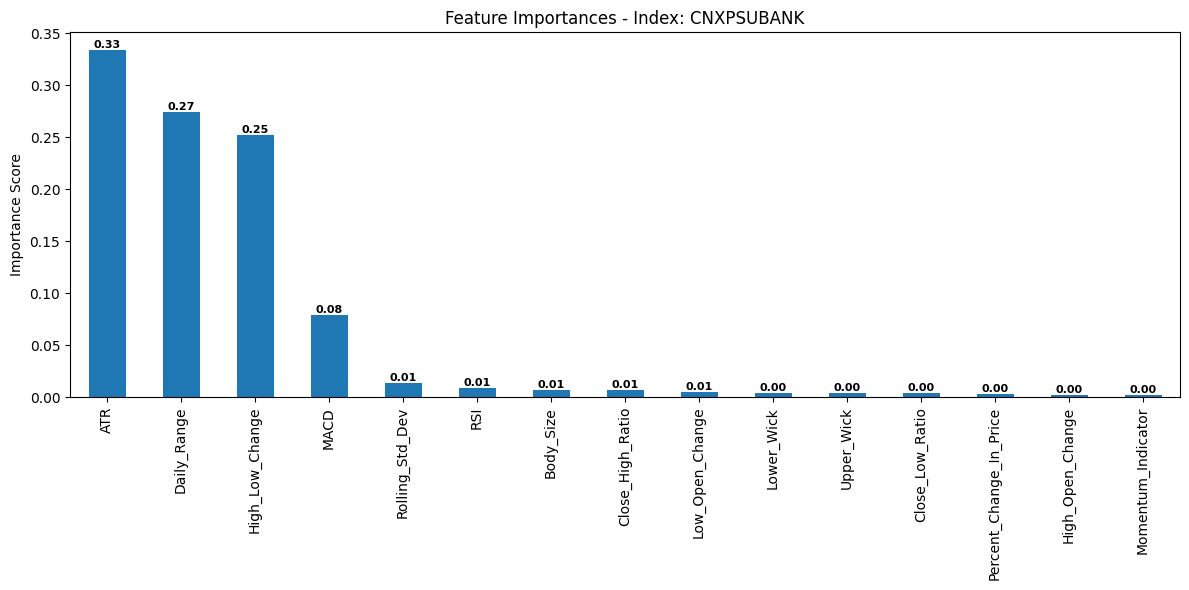

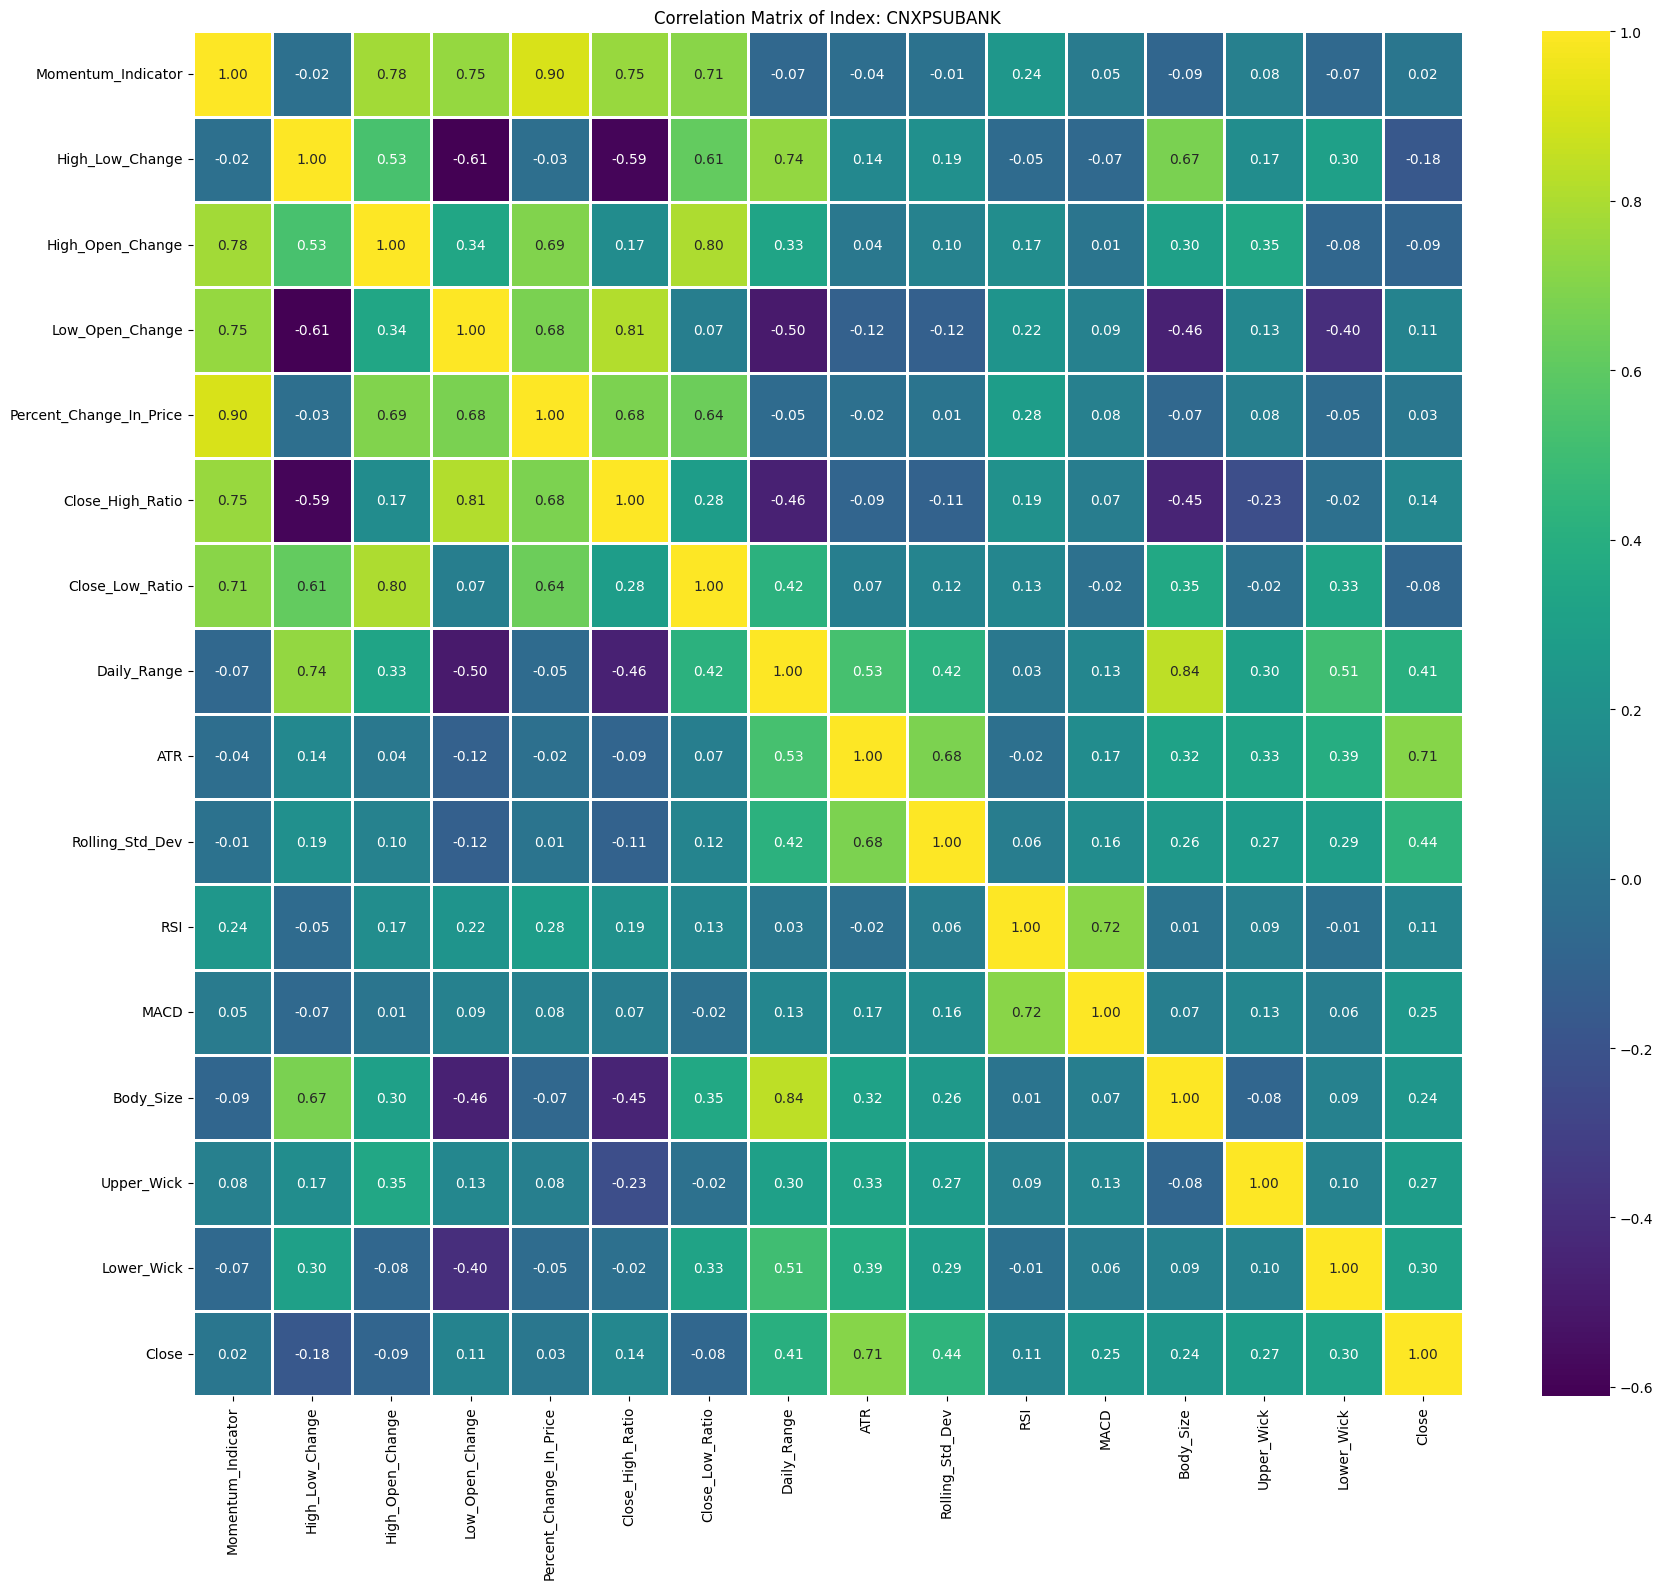


Processing Index: CNXAUTO
R-squared: -1.796837270874272

Index: CNXAUTO - Feature Importances:


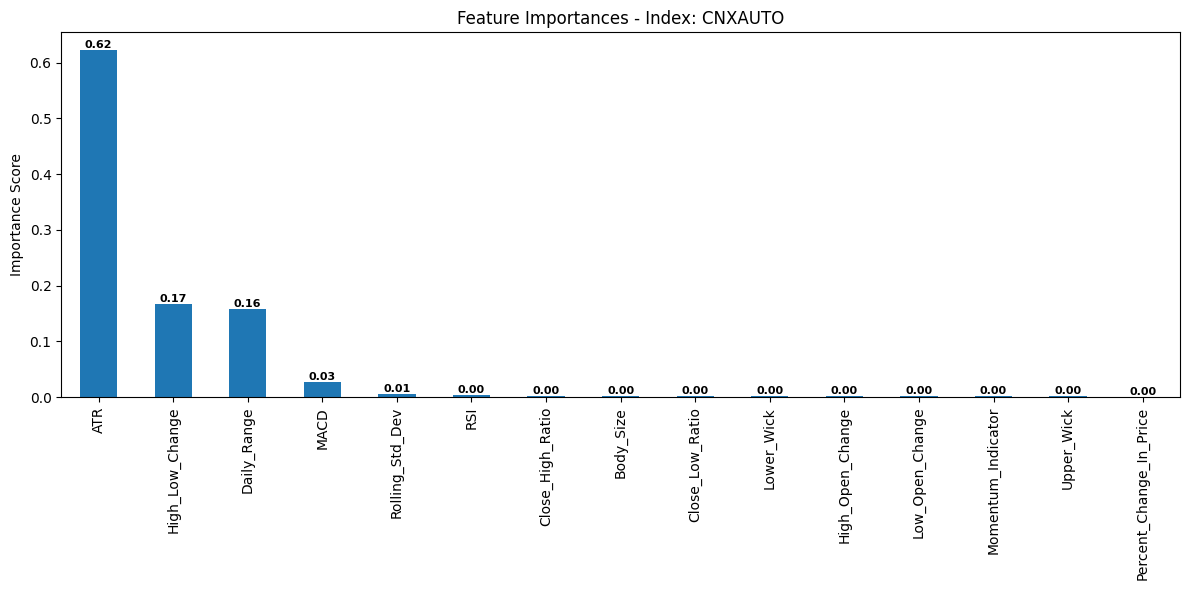

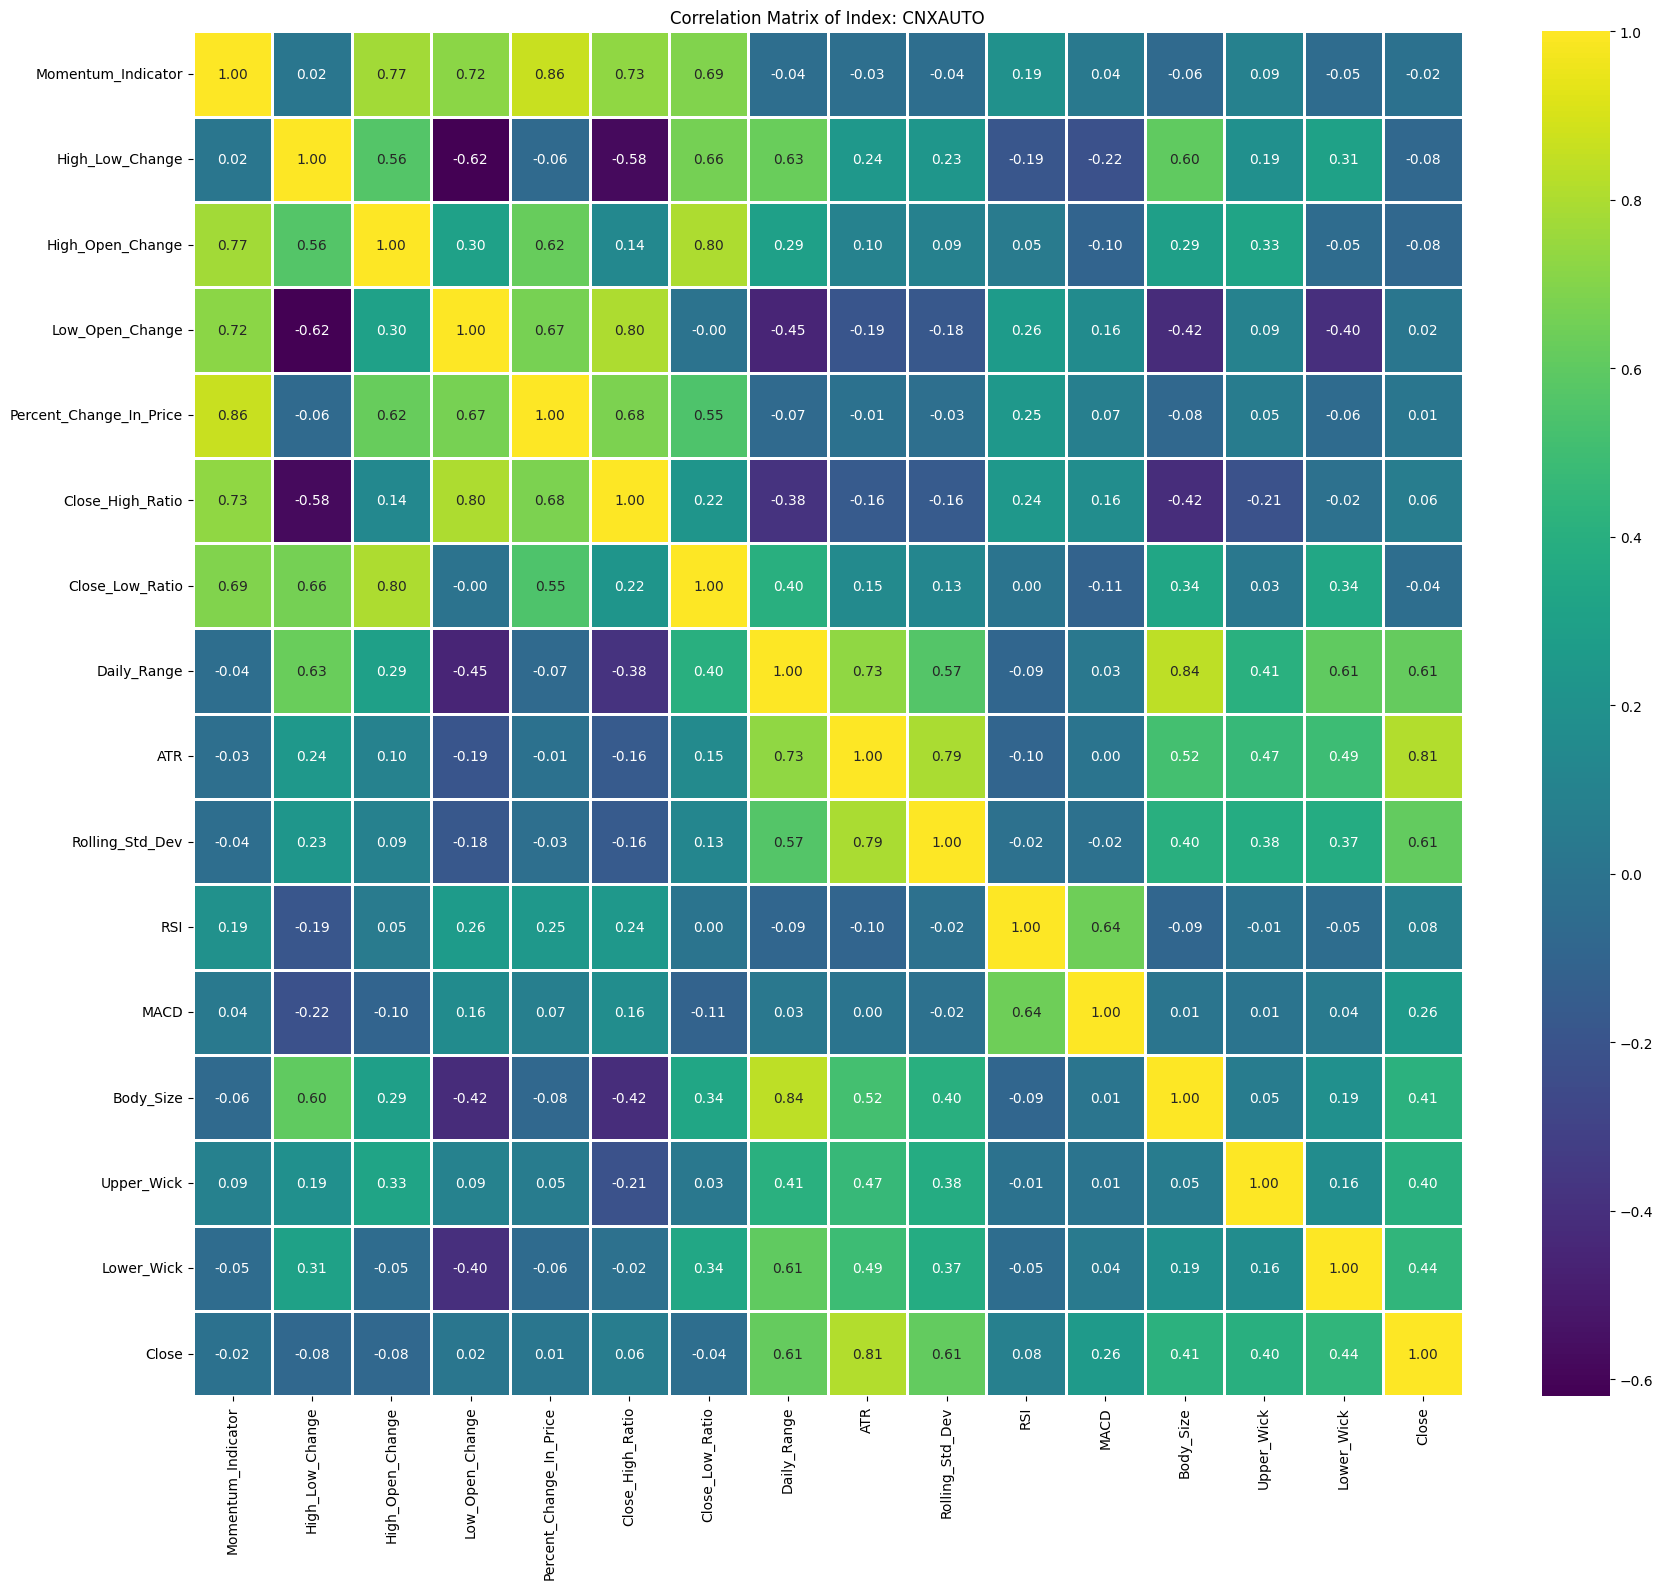


Processing Index: NIFTY_FIN_SERVICE
R-squared: -2.9482920700511452

Index: NIFTY_FIN_SERVICE - Feature Importances:


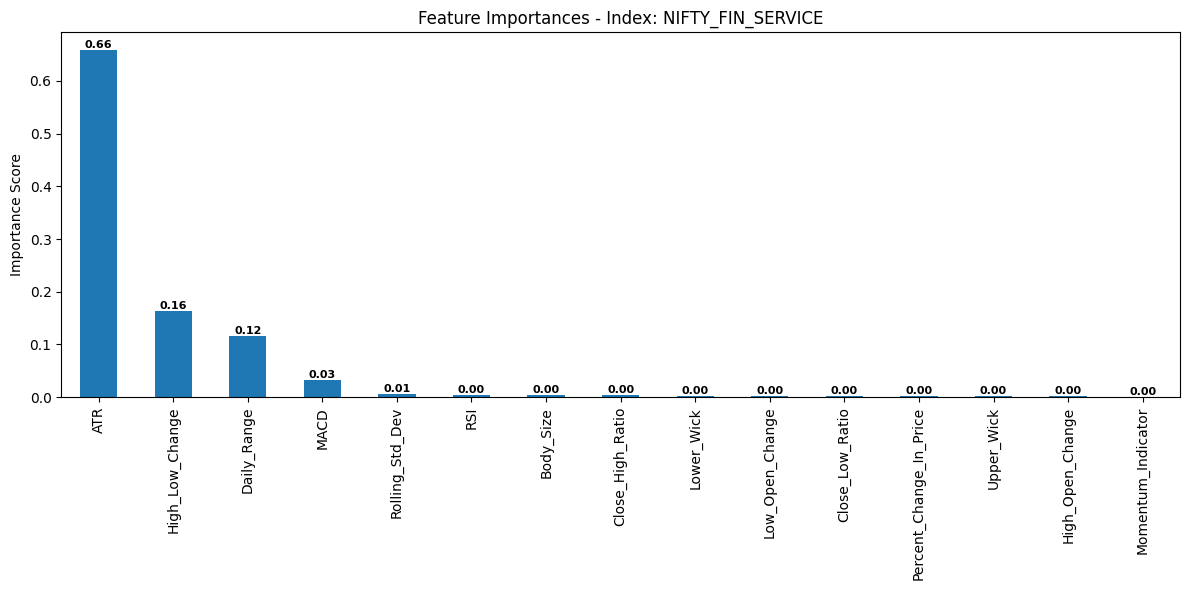

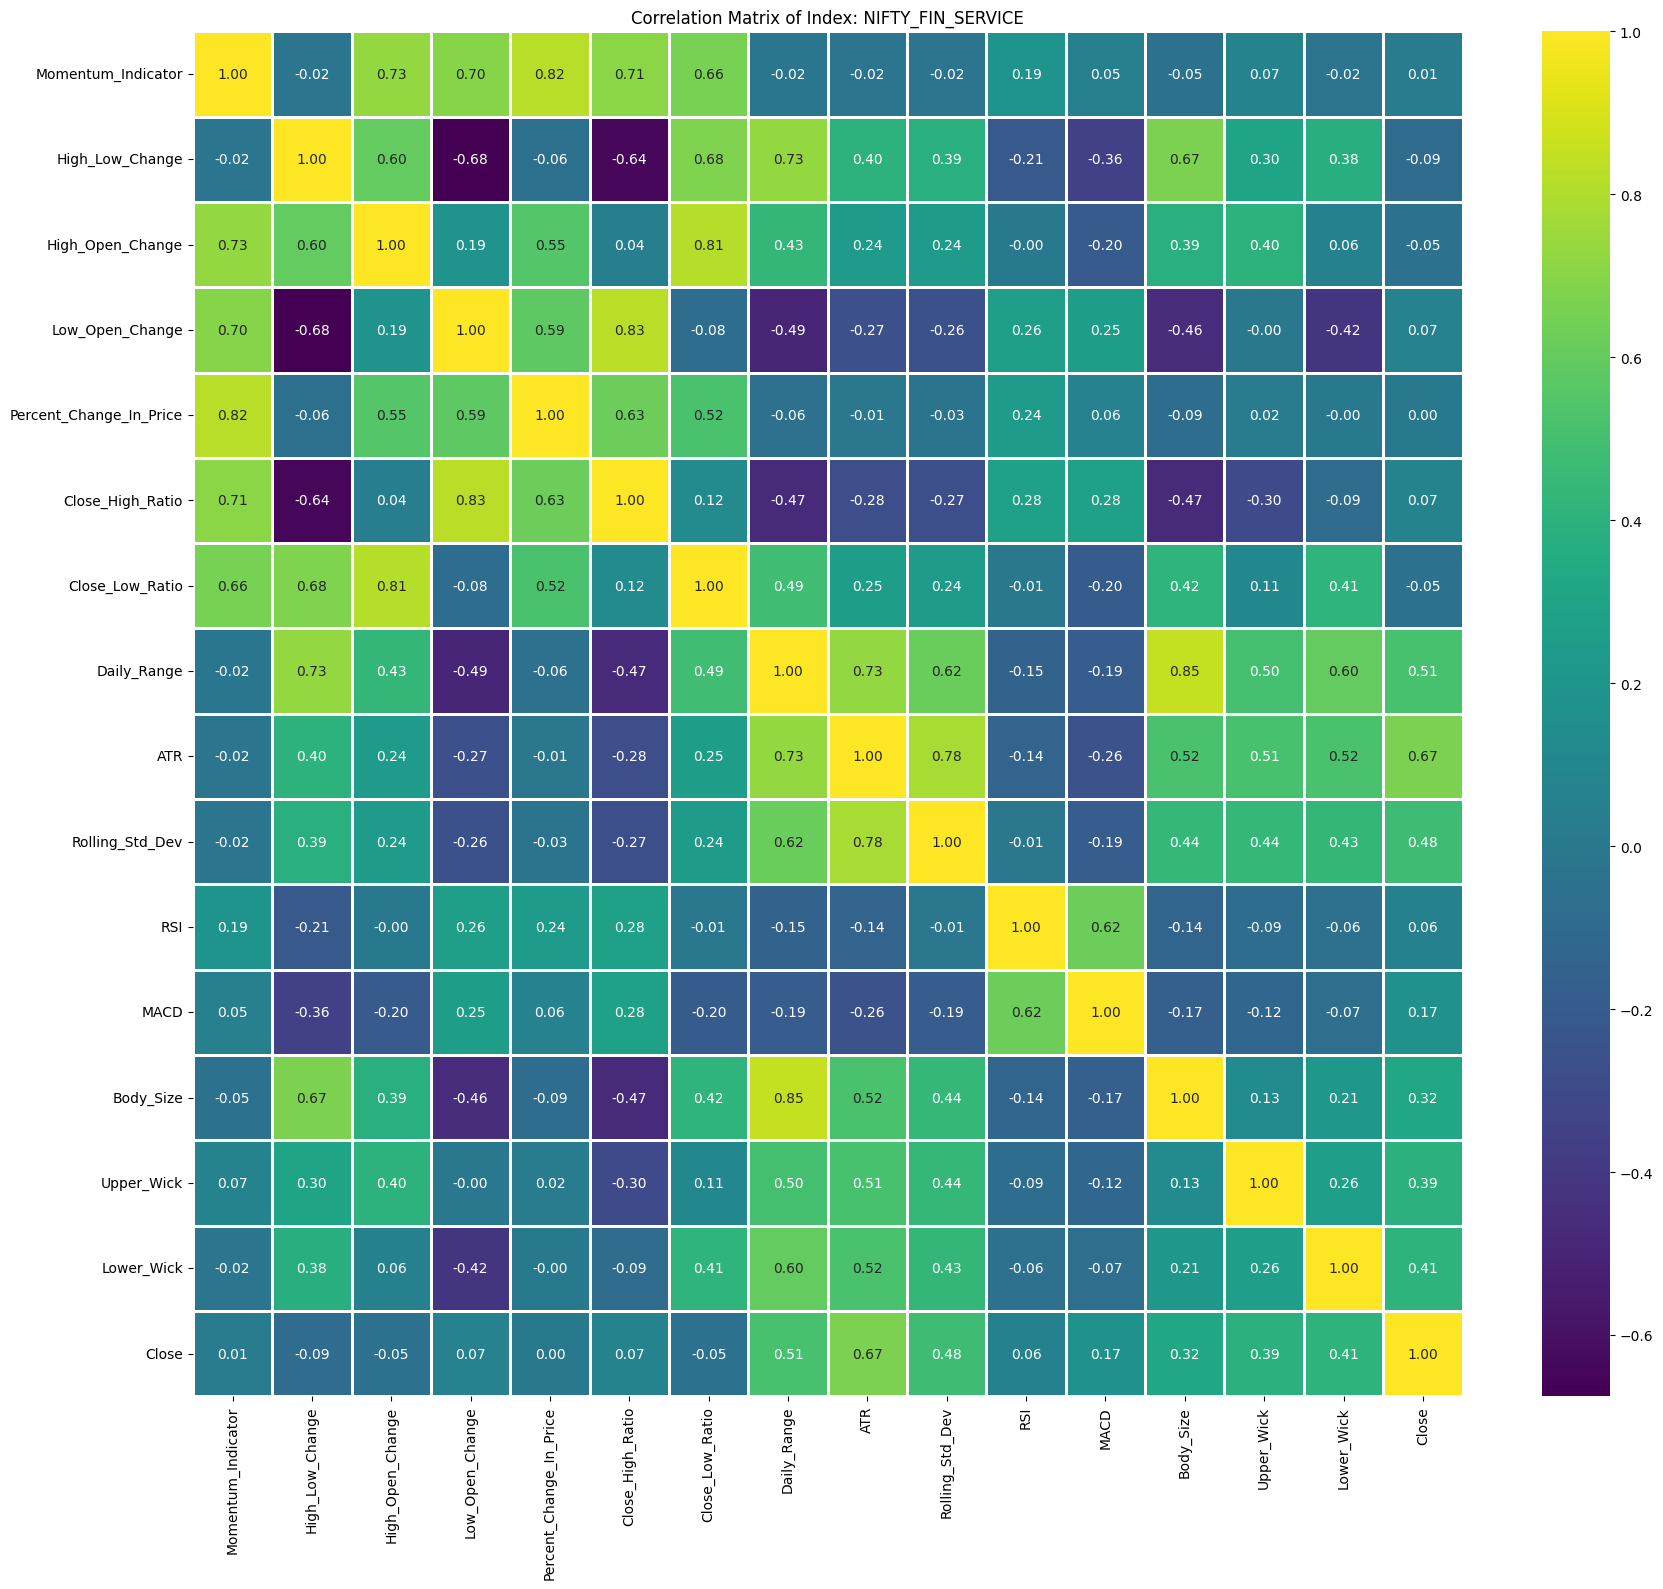

In [39]:
index_excel_file = '../Data/Index_Data.xlsx'
all_indexes = pd.read_excel(index_excel_file, sheet_name=None)

print("### Feature Selection for Each Index ###")
for sheet_name, df in all_indexes.items():
    asset_identifier = f"Index: {sheet_name}"
    print(f"\nProcessing {asset_identifier}")
    feat_imp = select_features_rf(df, asset_name=asset_identifier)
    selected_features = filter_features(feat_imp, threshold=0.01)
    index_features_dict[sheet_name] = selected_features

### Feature Selection for Mutual Funds

### Feature Selection for Each Mutual Fund ###

Processing Mutual Fund: 0P00005WL6
R-squared: -19.49944849599825

Mutual Fund: 0P00005WL6 - Feature Importances:


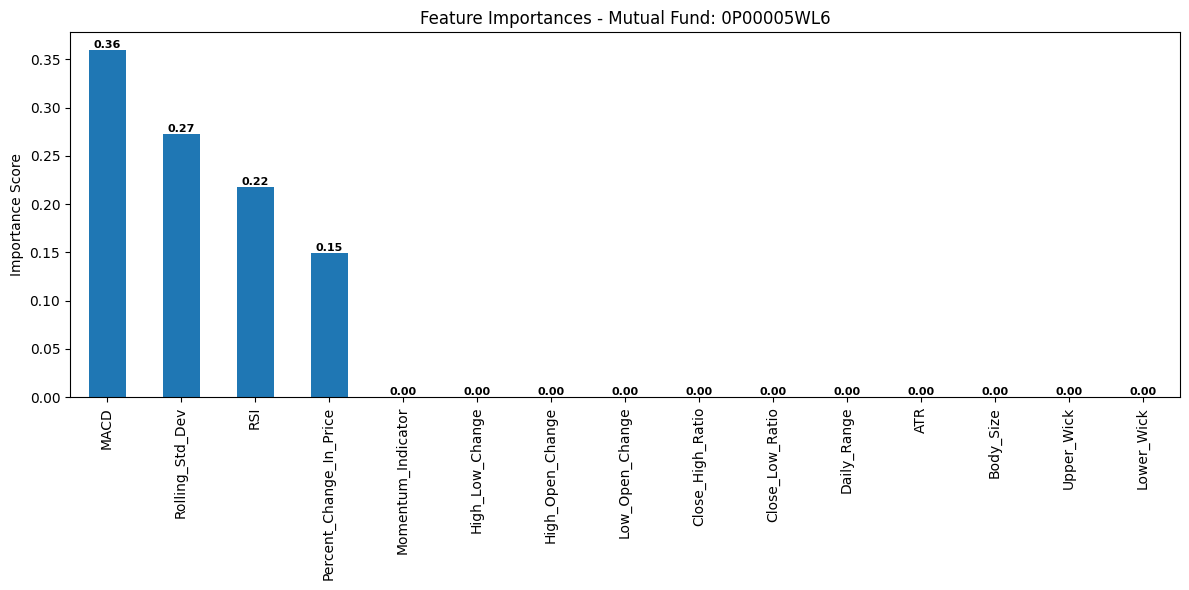

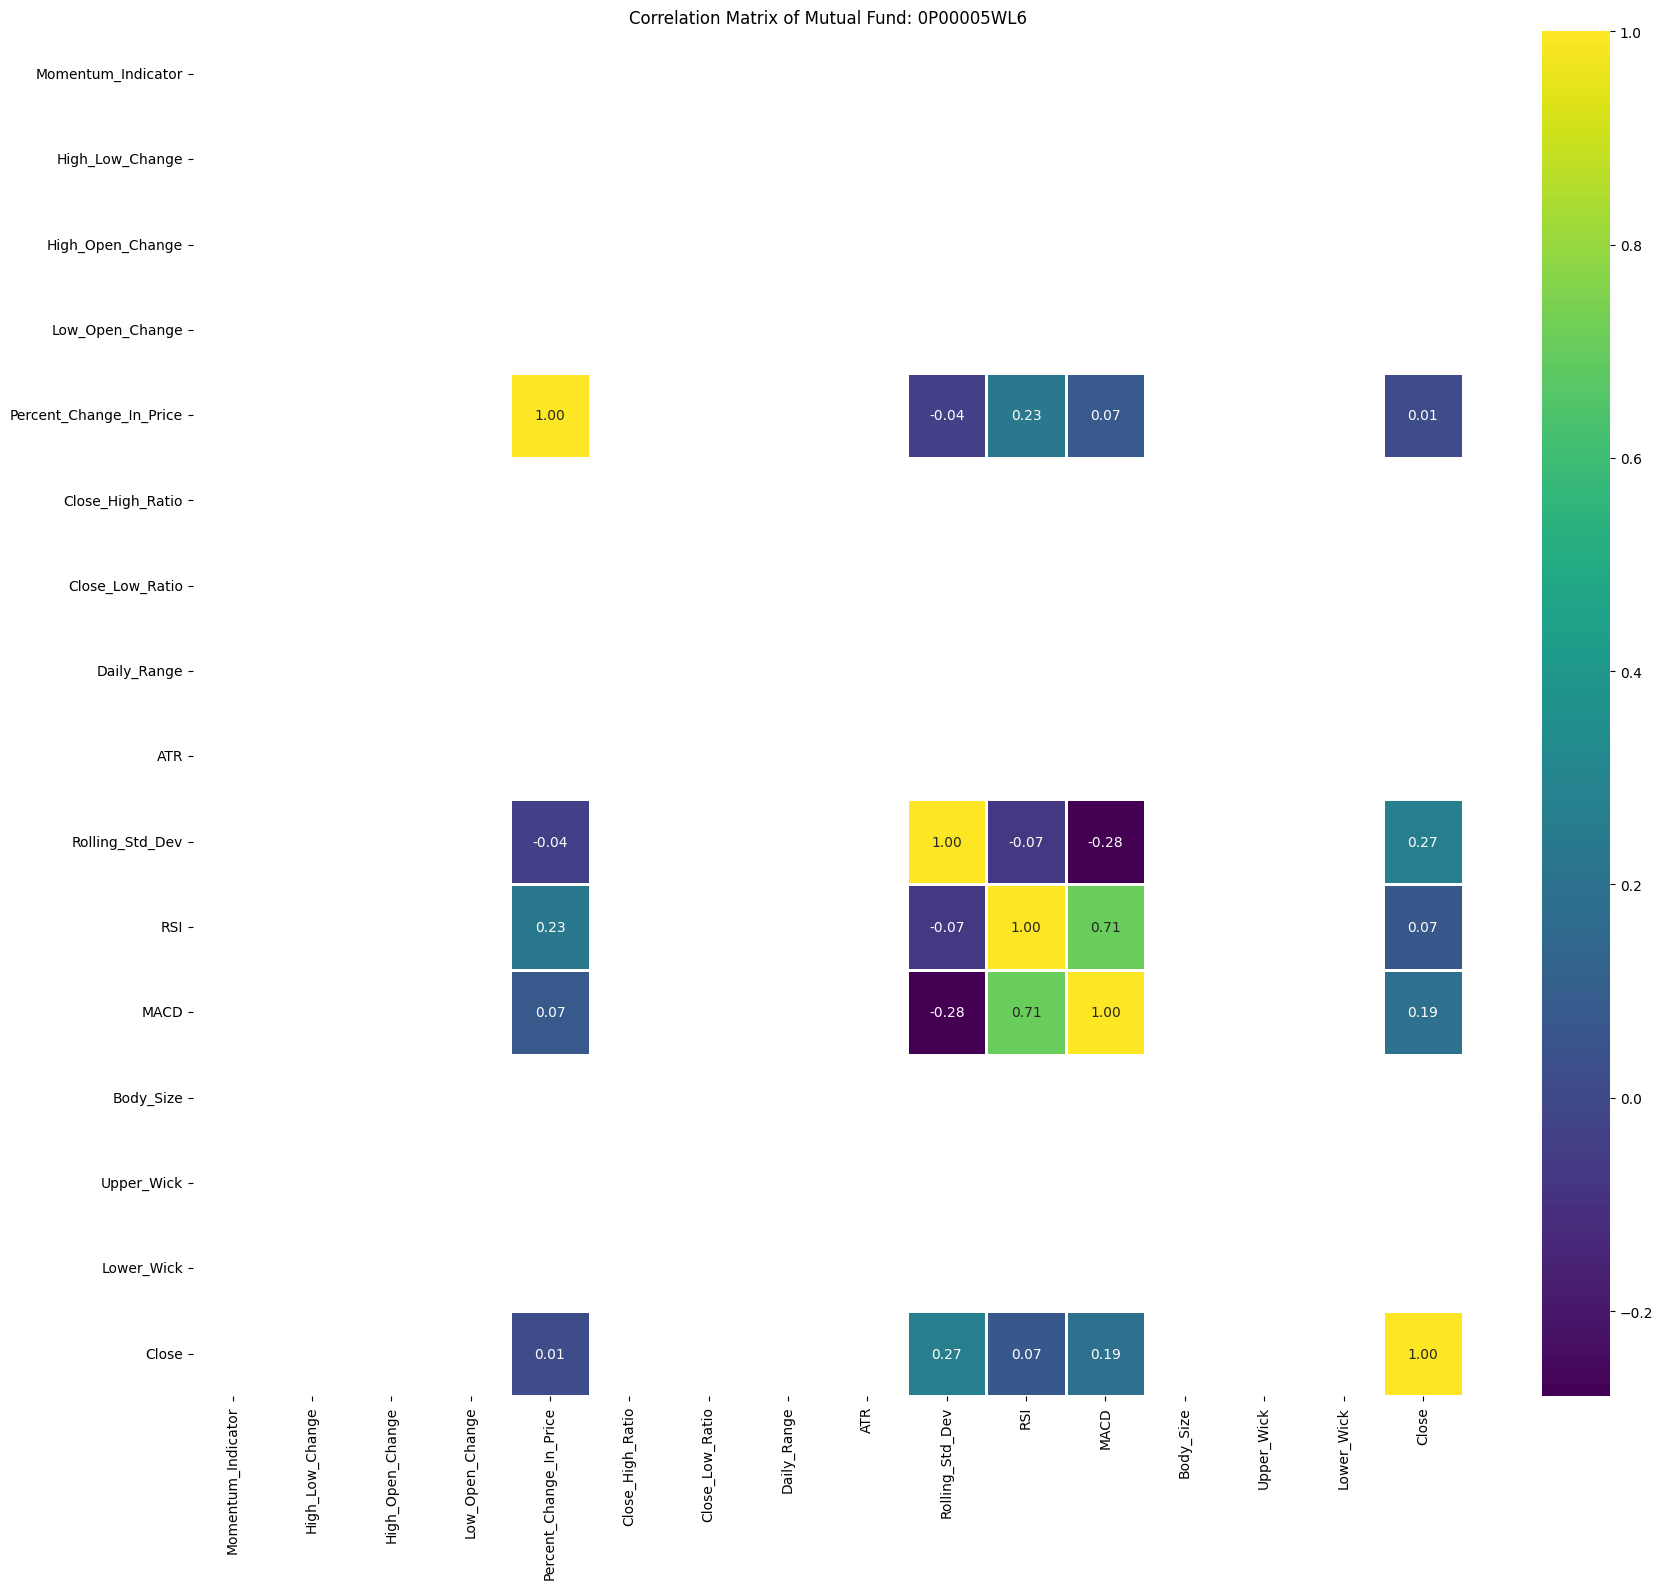


Processing Mutual Fund: UTINEXT50
R-squared: -4.740510923530757

Mutual Fund: UTINEXT50 - Feature Importances:


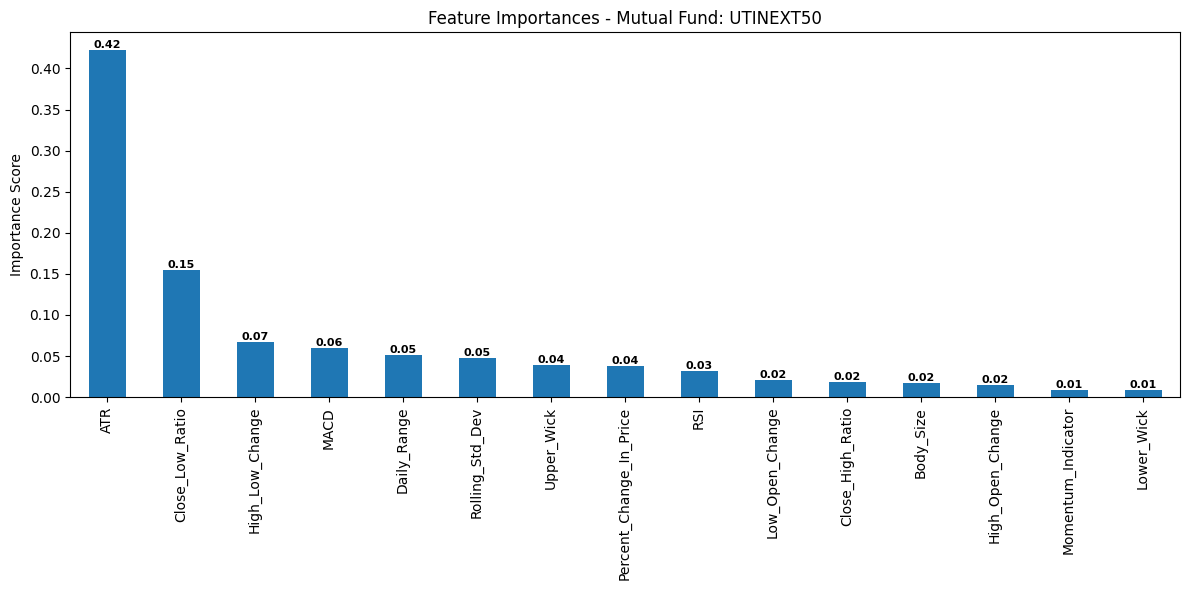

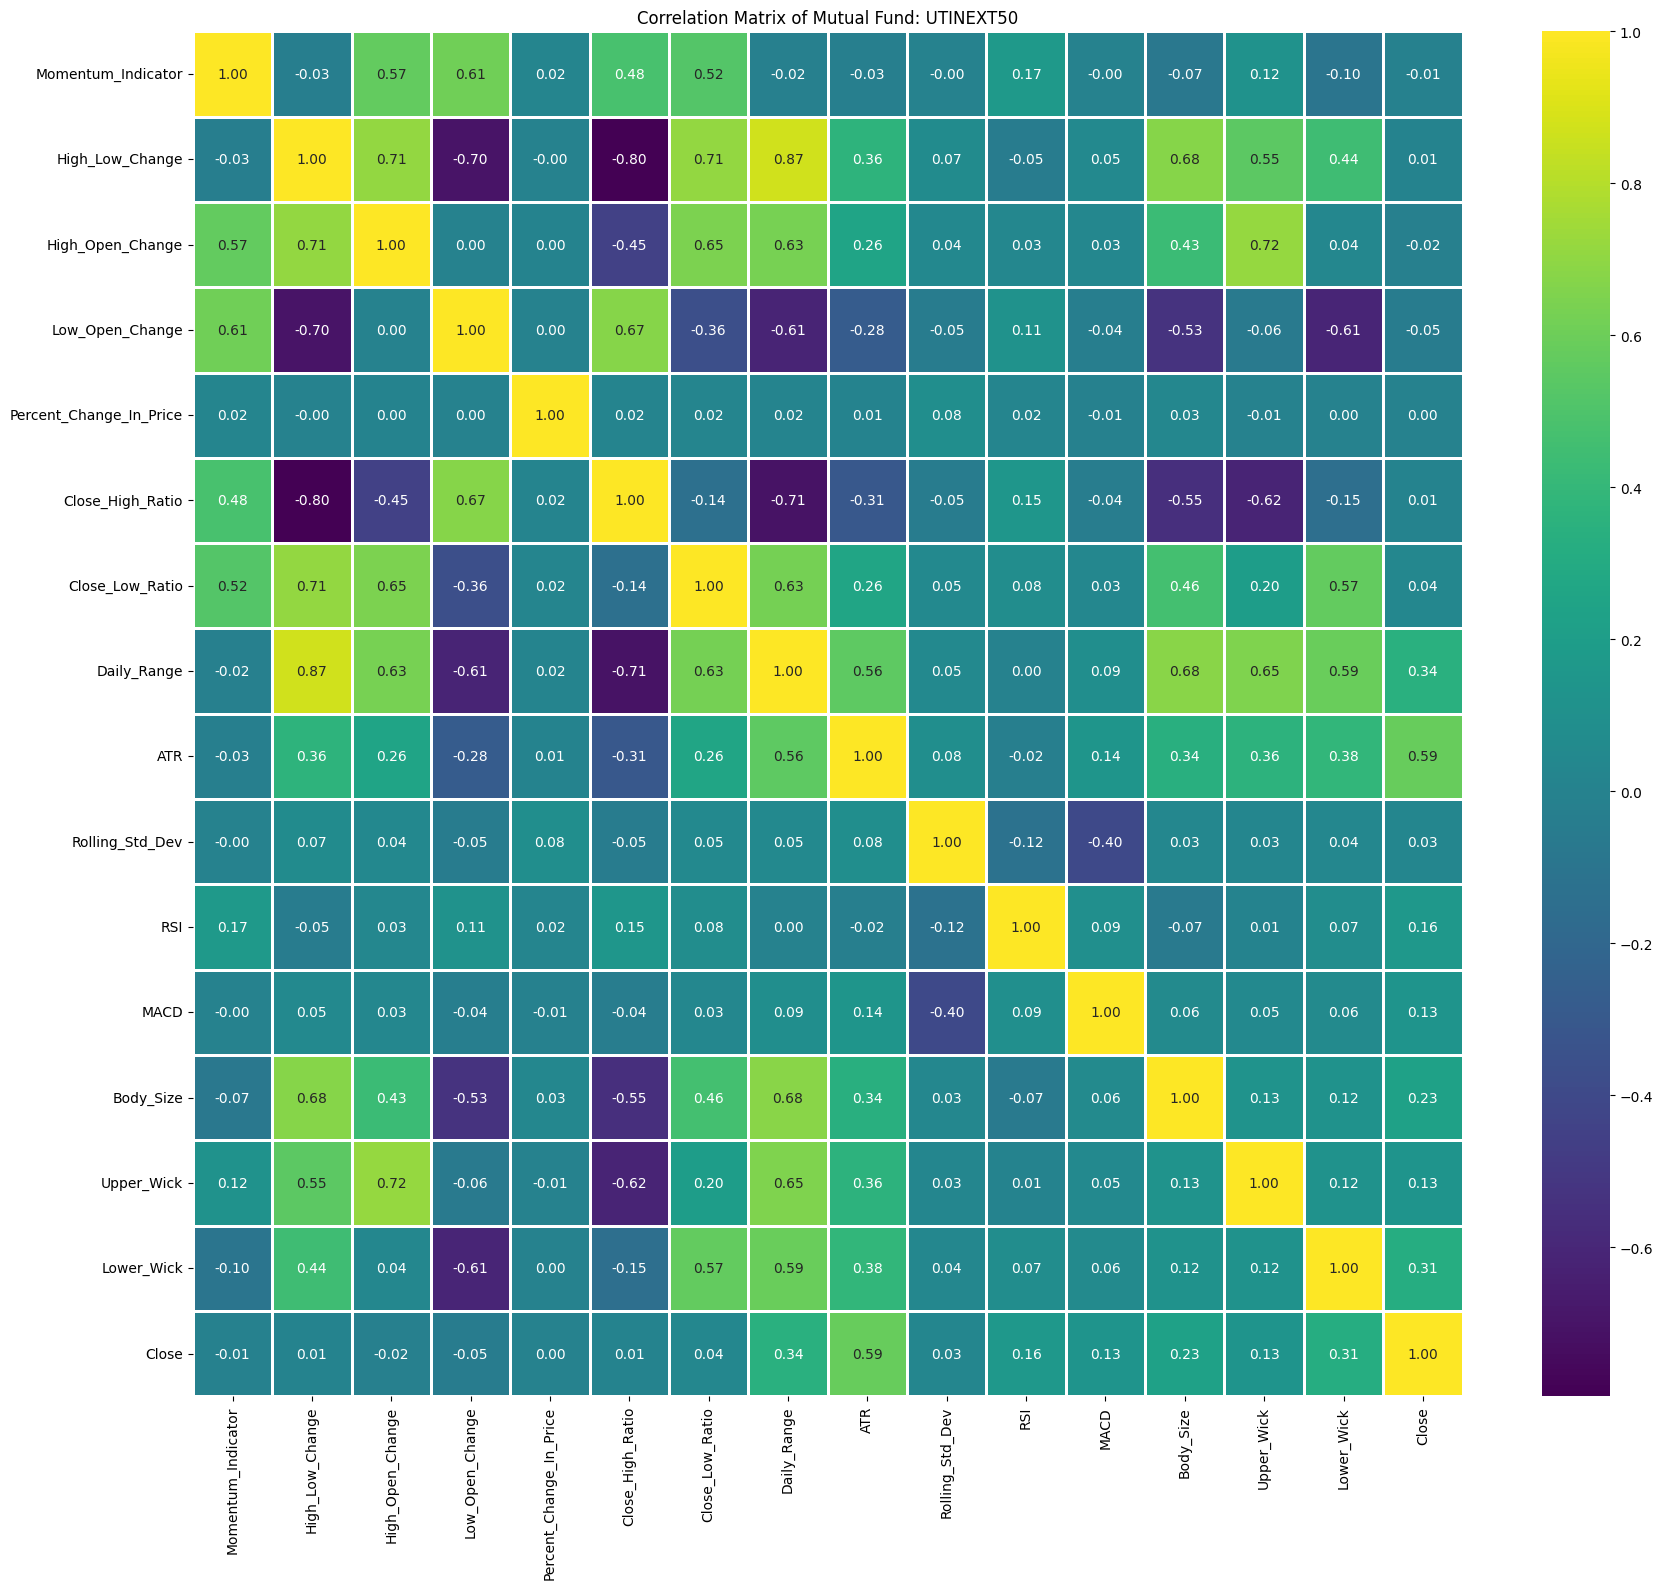


Processing Mutual Fund: 0P0000MLHH
R-squared: -11.48212309348224

Mutual Fund: 0P0000MLHH - Feature Importances:


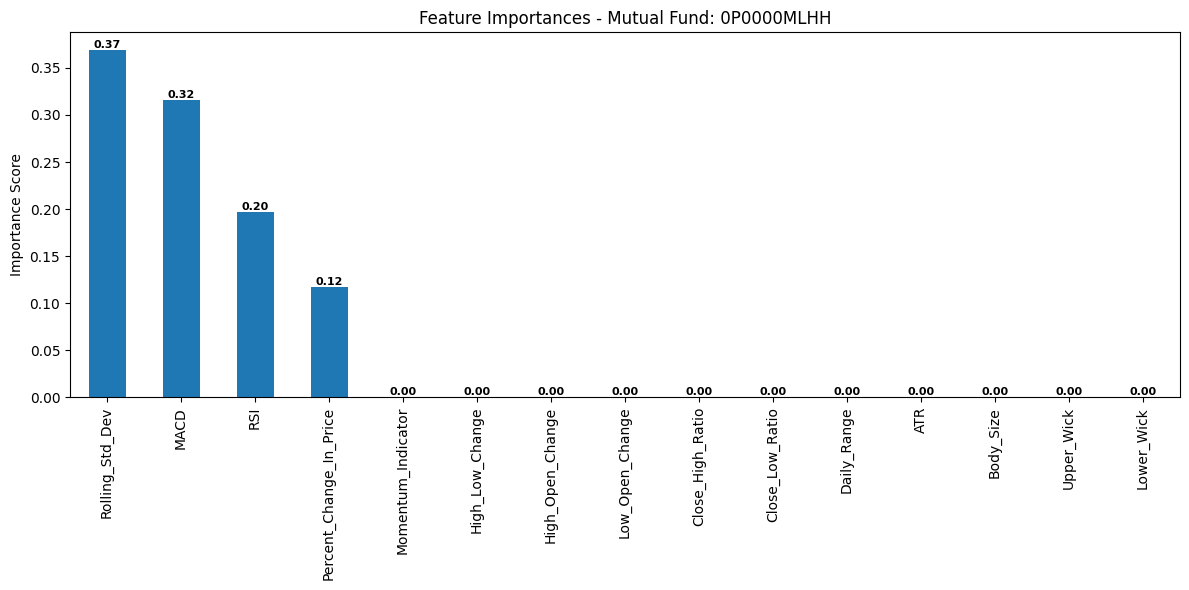

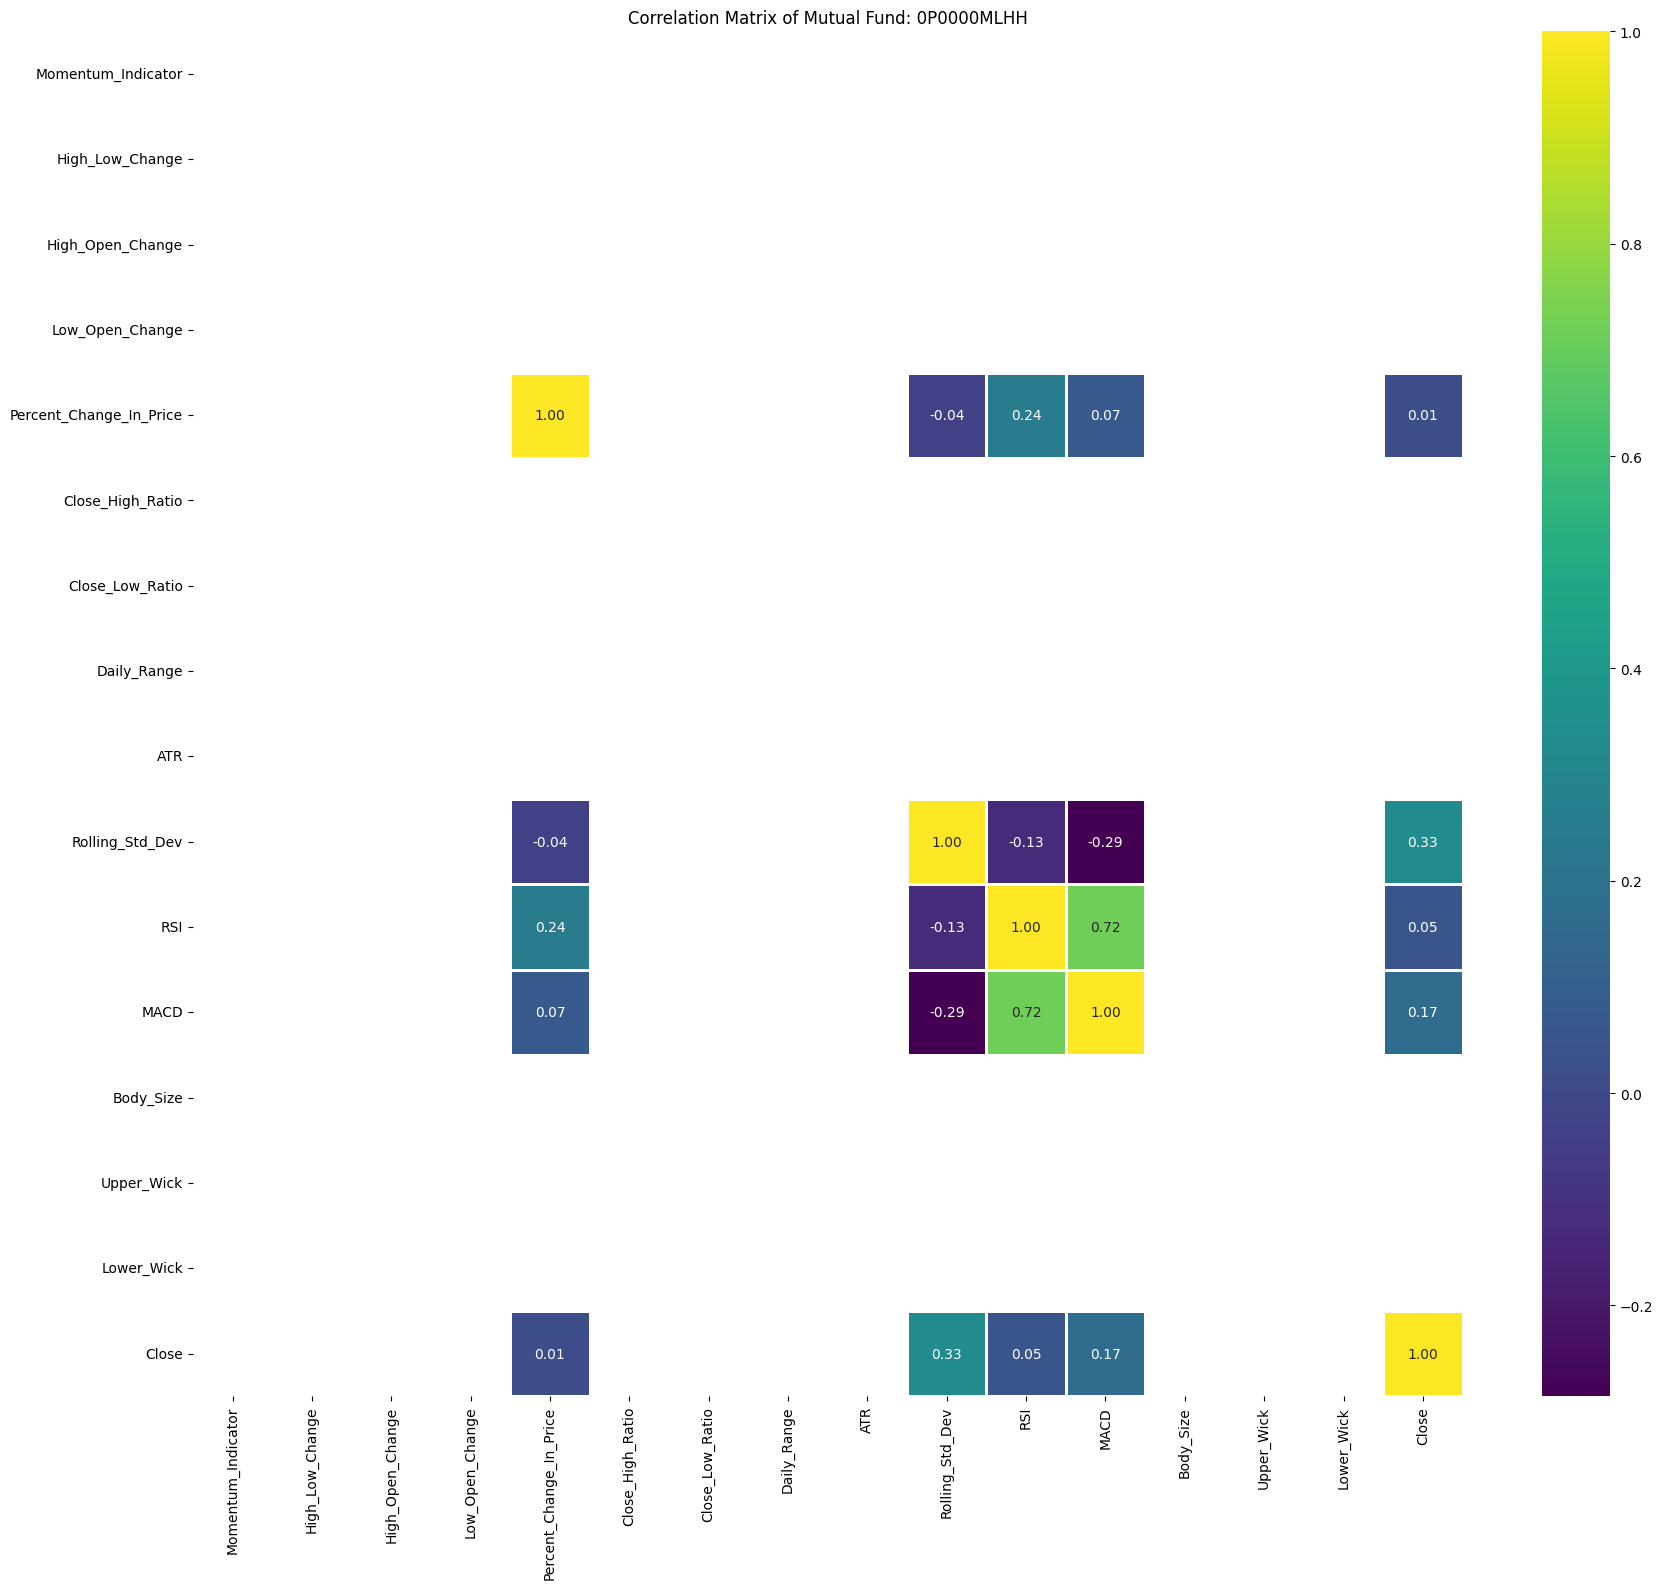


Processing Mutual Fund: 0P0000KV39
R-squared: -16.044540964184993

Mutual Fund: 0P0000KV39 - Feature Importances:


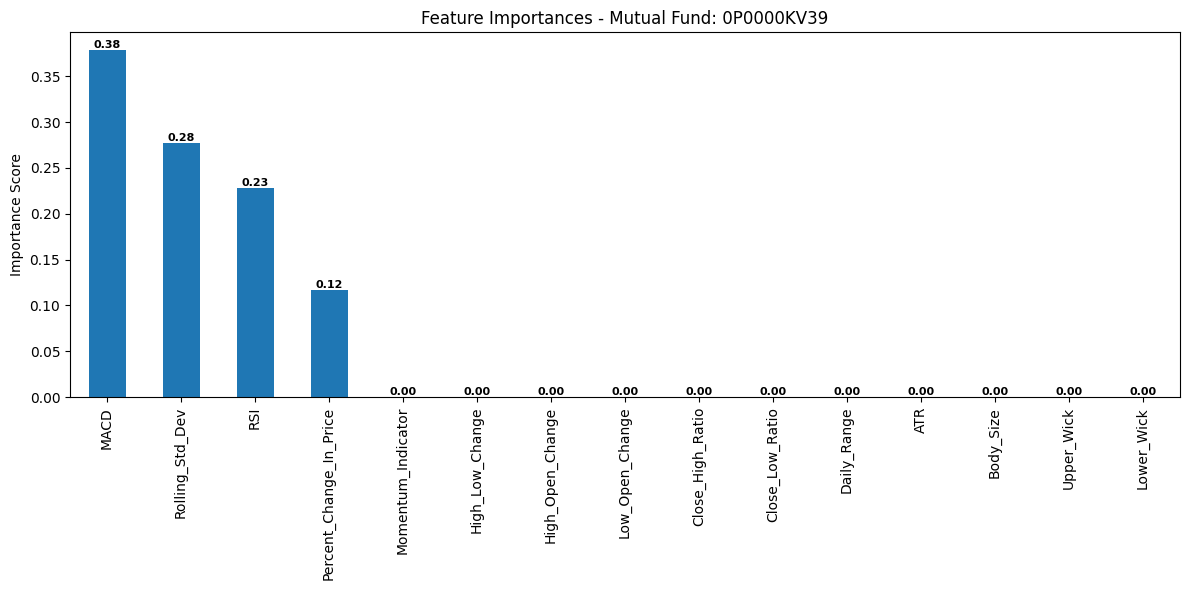

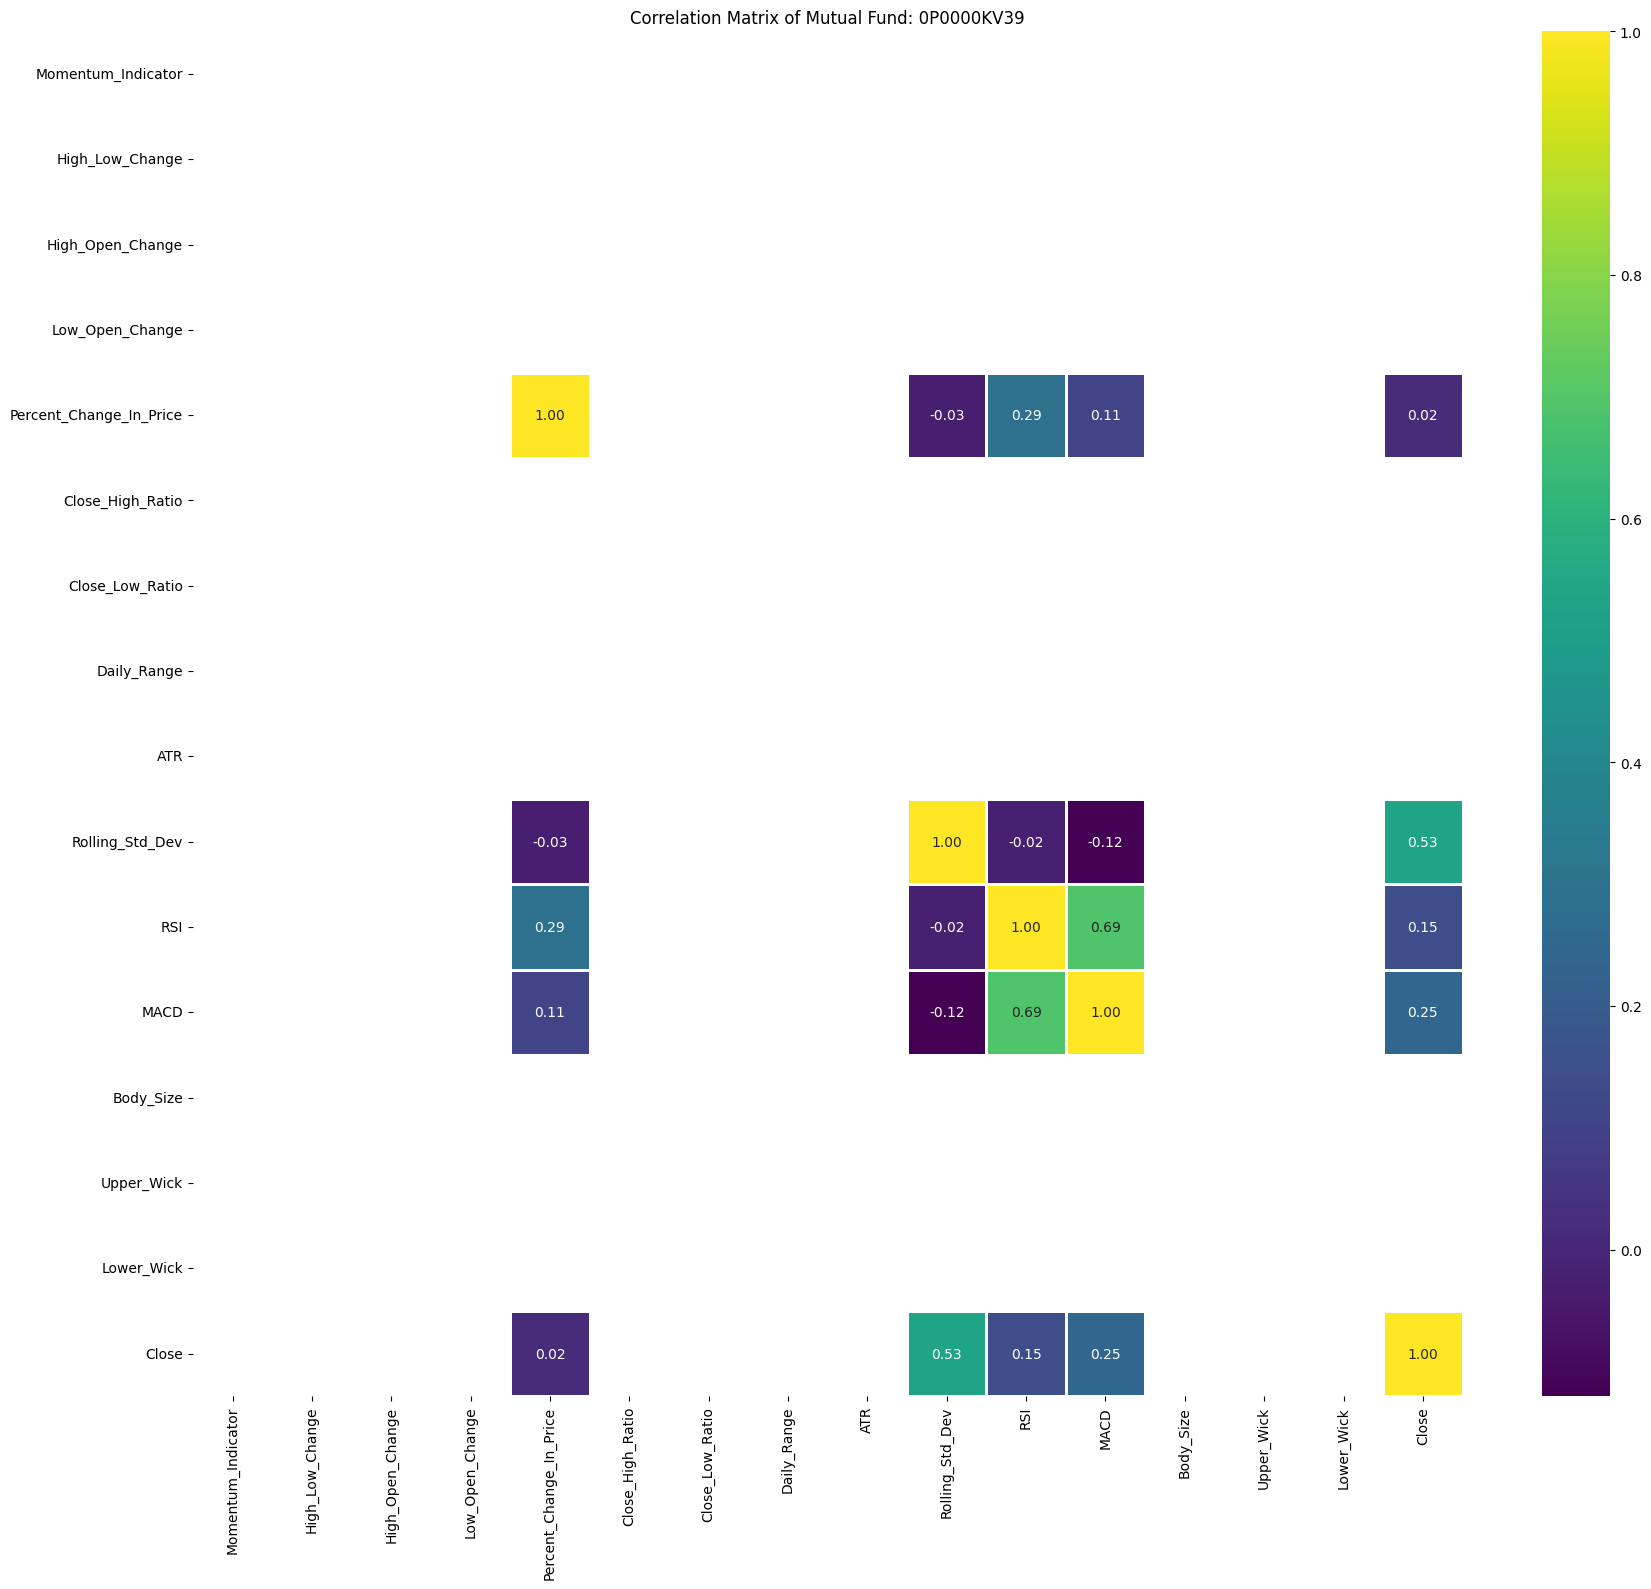


Processing Mutual Fund: 0P00009J3K
R-squared: -12.844377710597424

Mutual Fund: 0P00009J3K - Feature Importances:


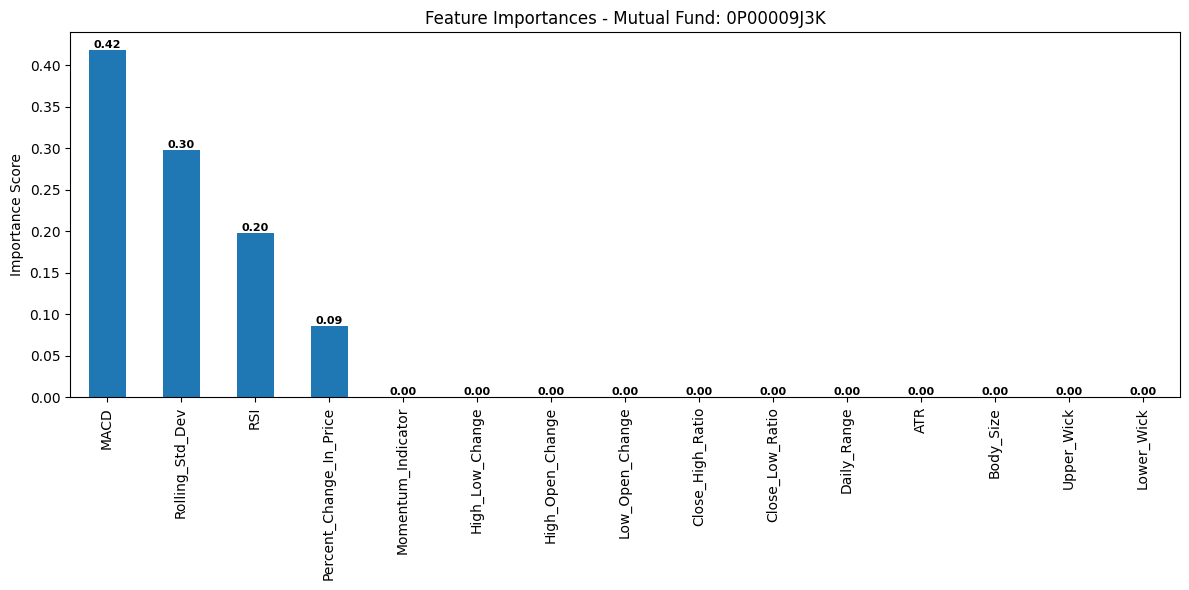

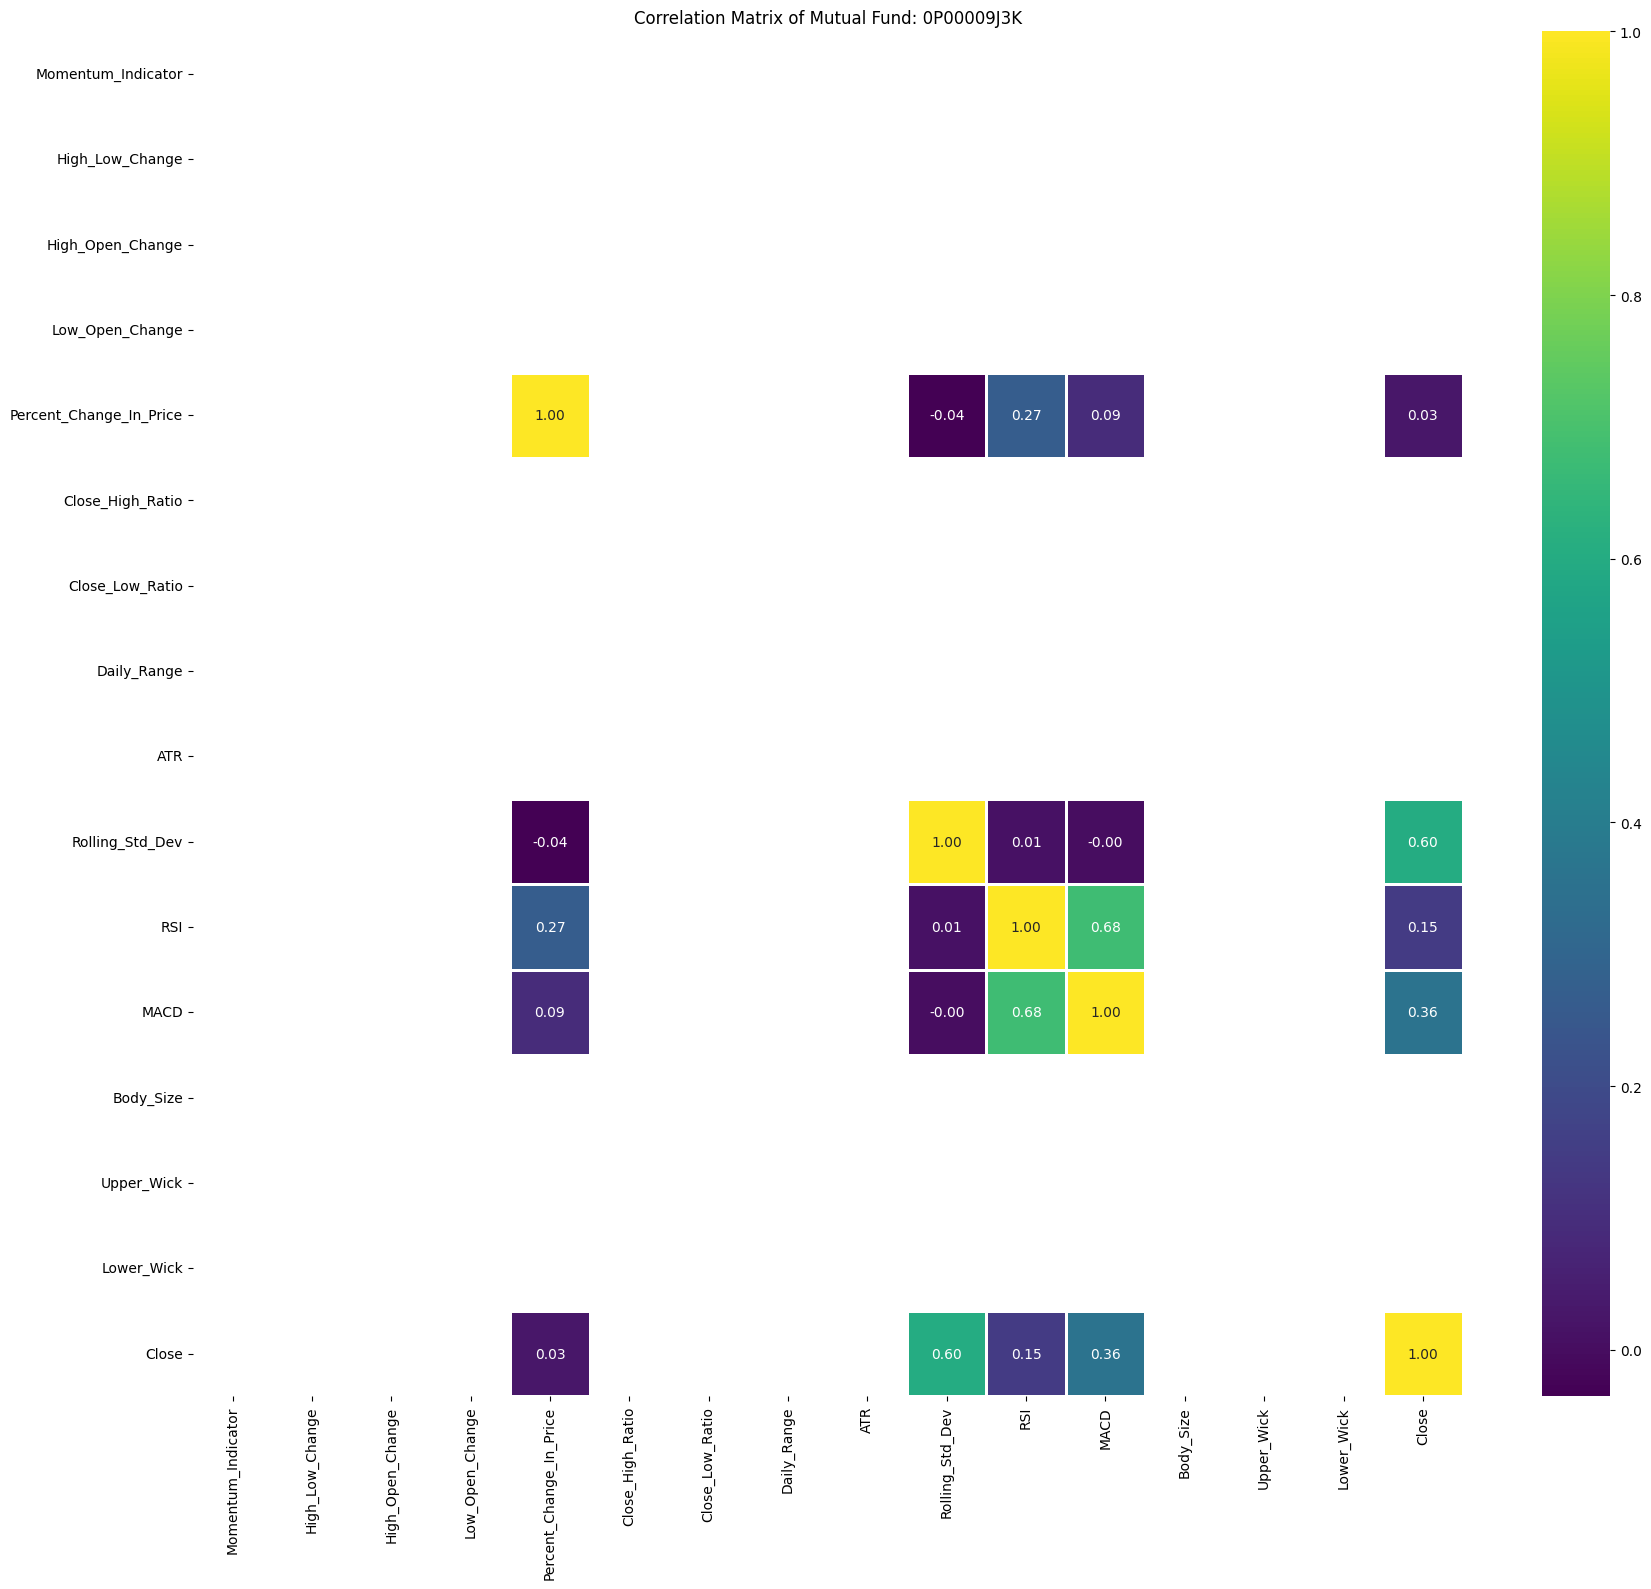


Processing Mutual Fund: 0P0001BAB5
R-squared: -13.953572616157066

Mutual Fund: 0P0001BAB5 - Feature Importances:


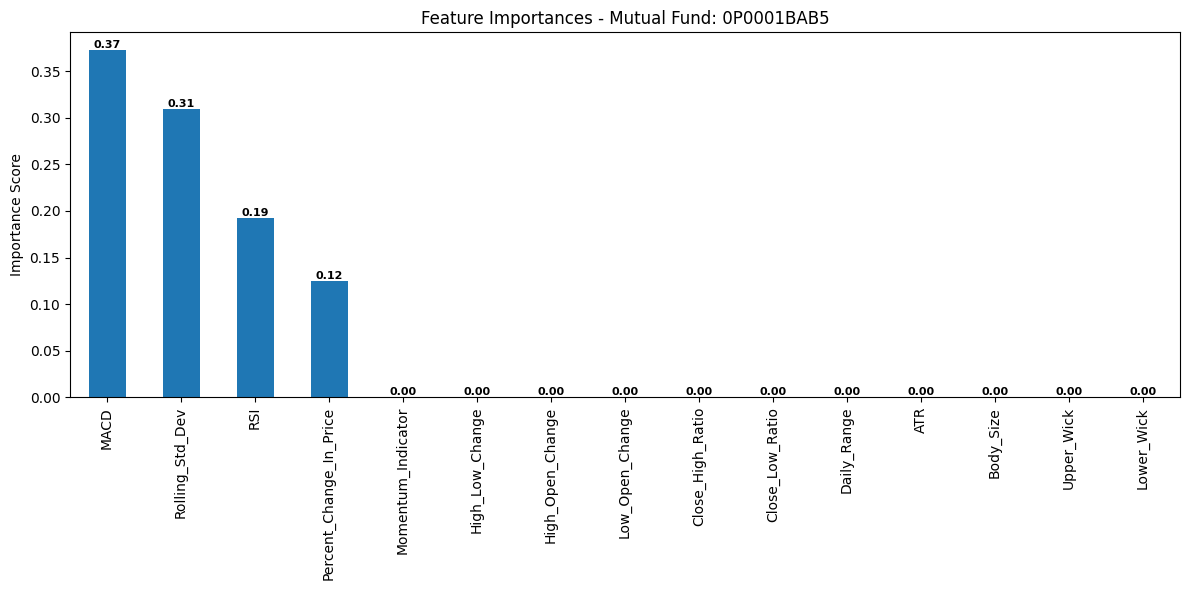

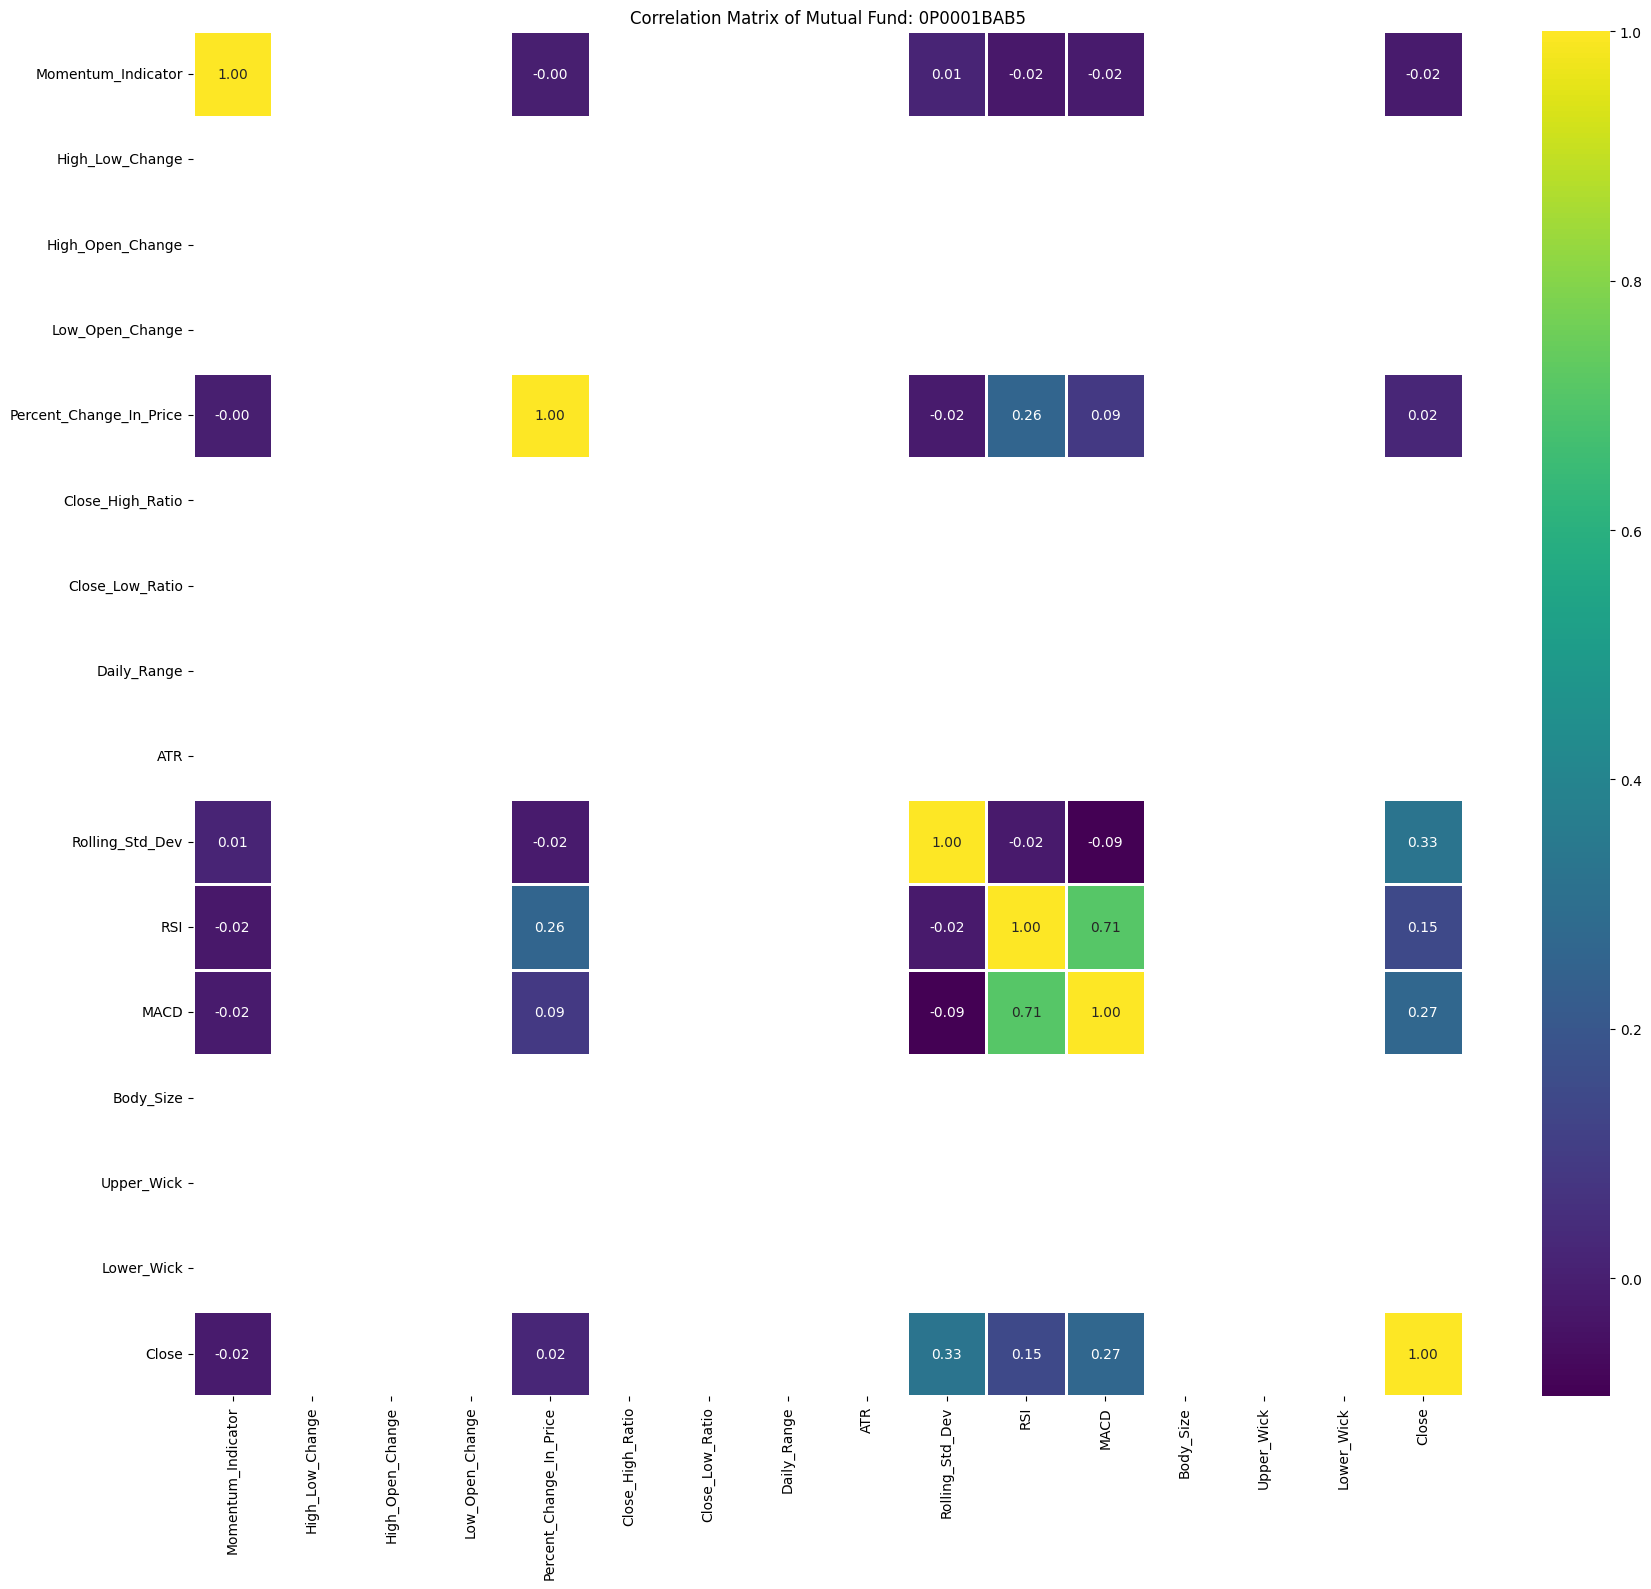


Processing Mutual Fund: 0P0001EI18
R-squared: -24.223630850890643

Mutual Fund: 0P0001EI18 - Feature Importances:


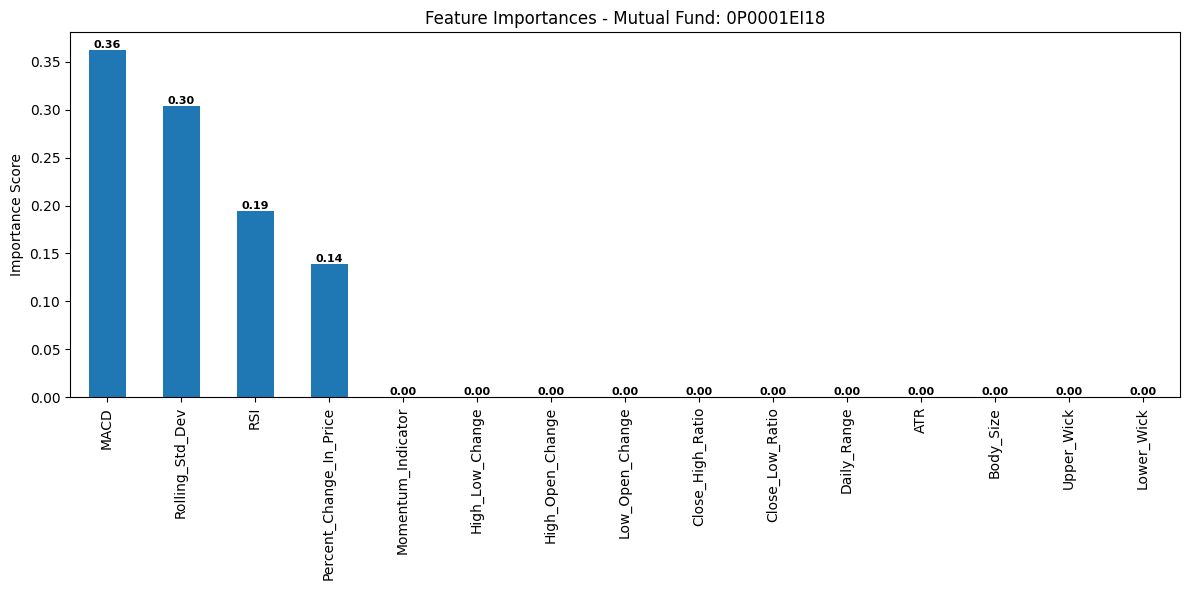

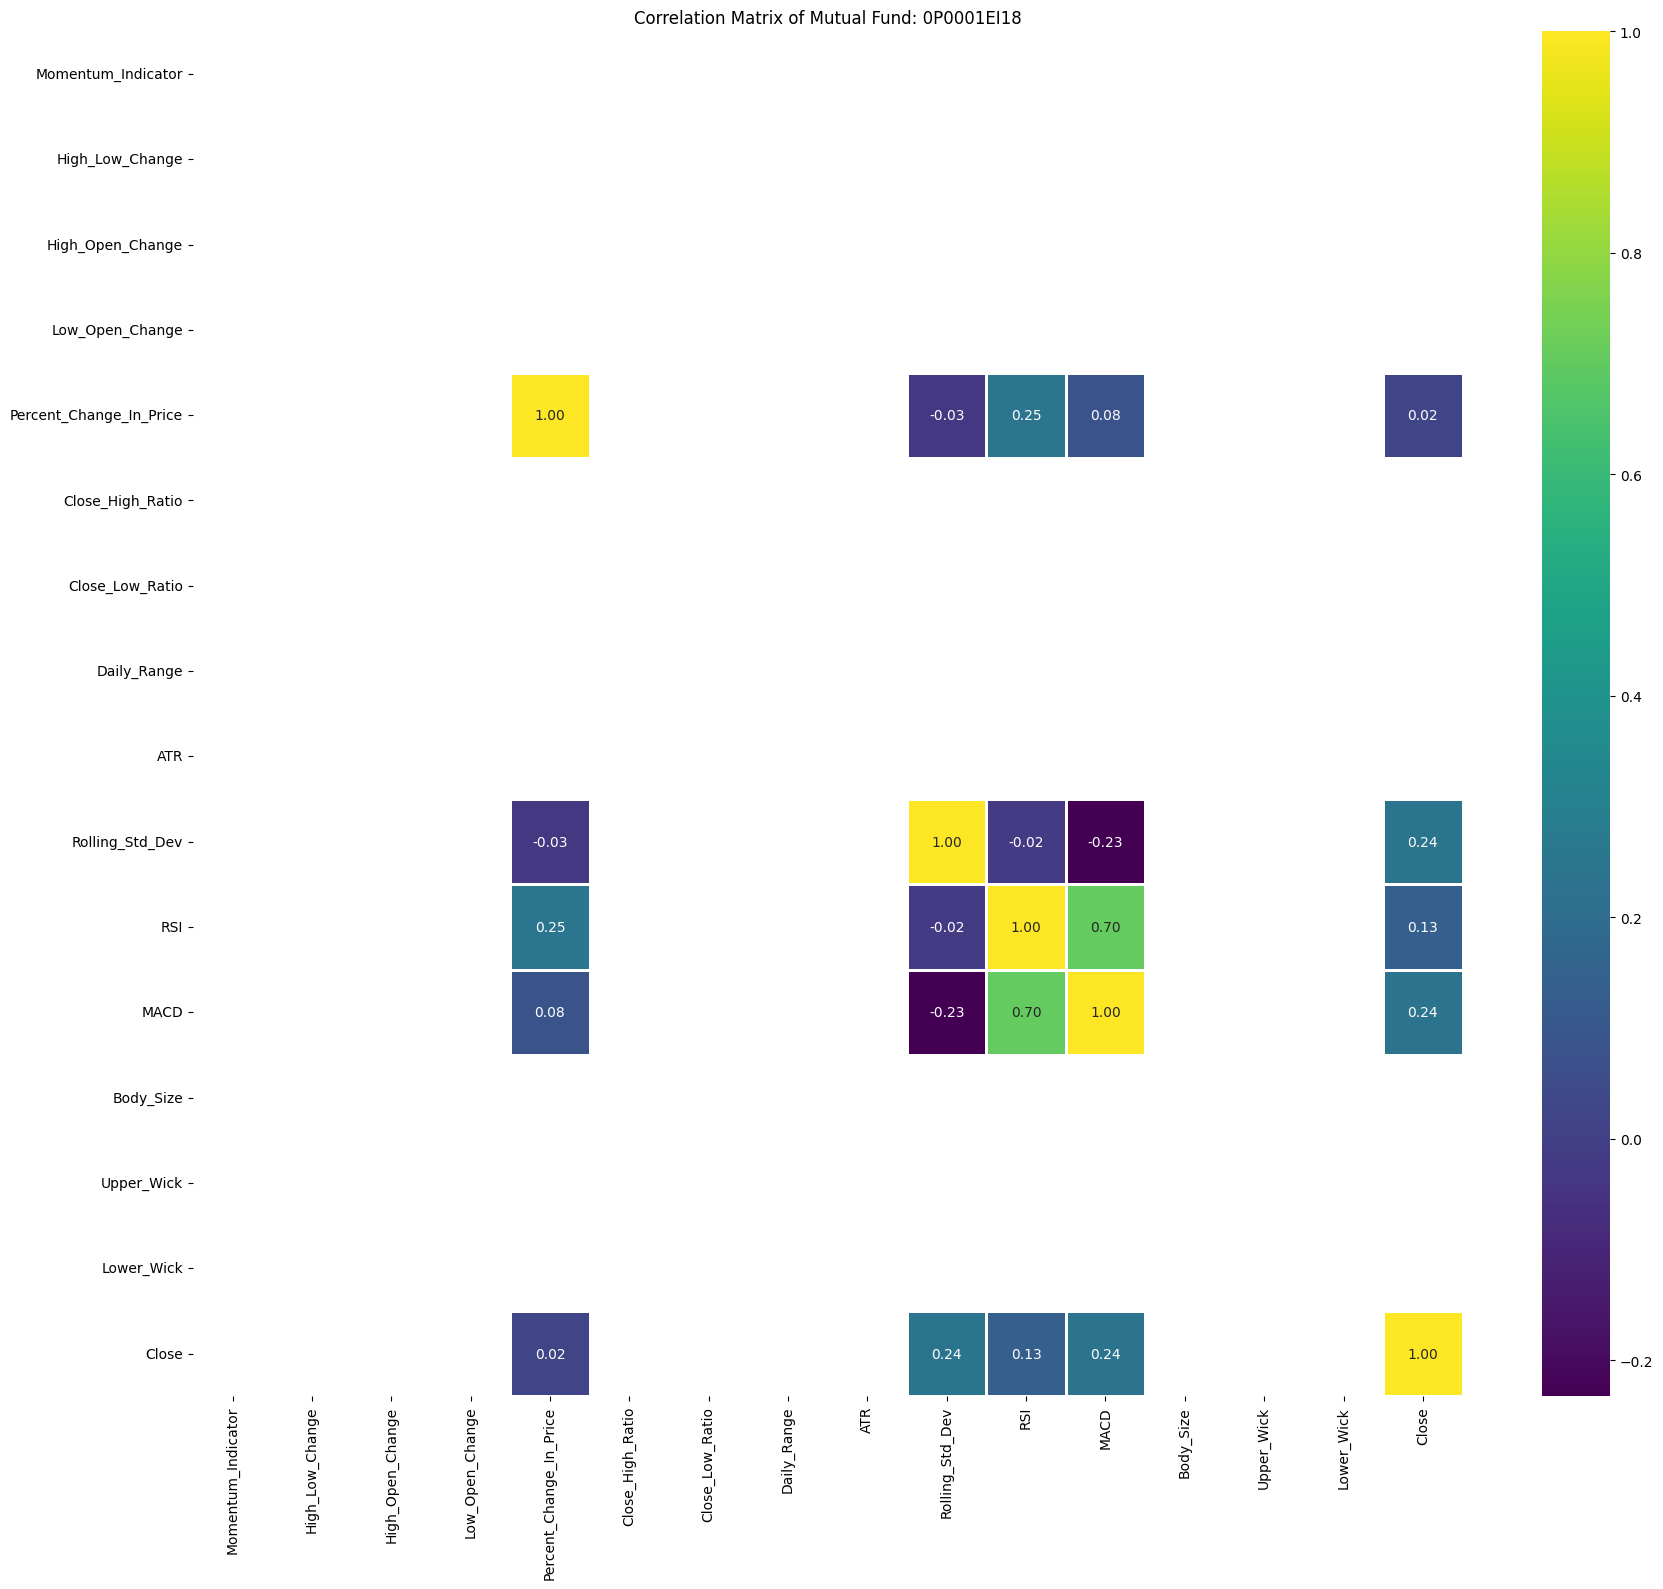


Processing Mutual Fund: 0P0001BA1R
R-squared: -19.37537935235854

Mutual Fund: 0P0001BA1R - Feature Importances:


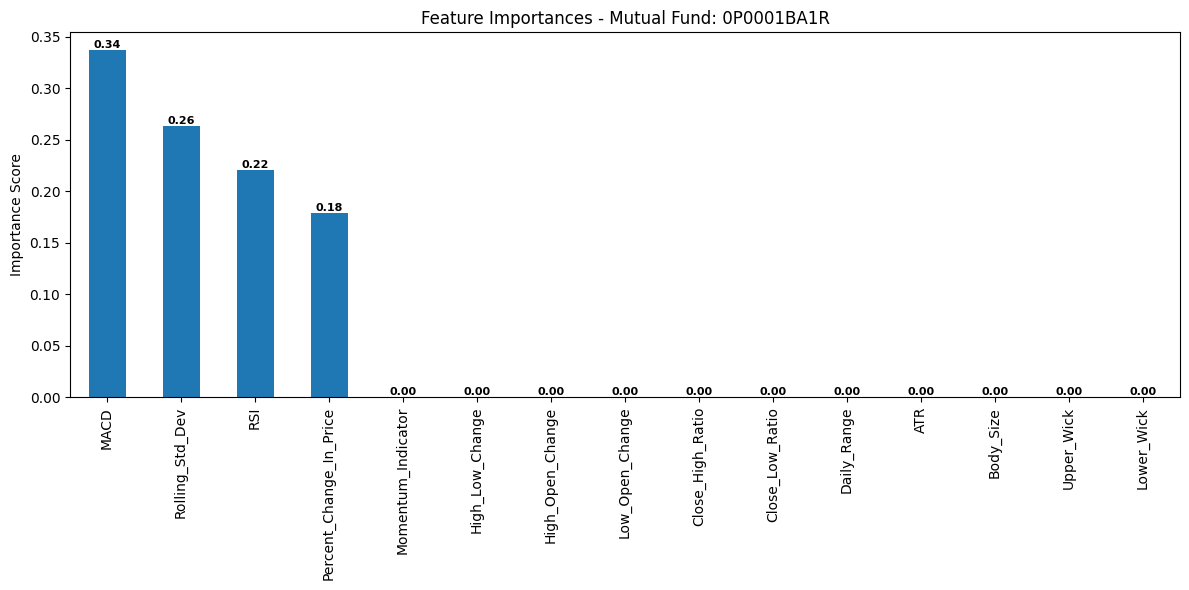

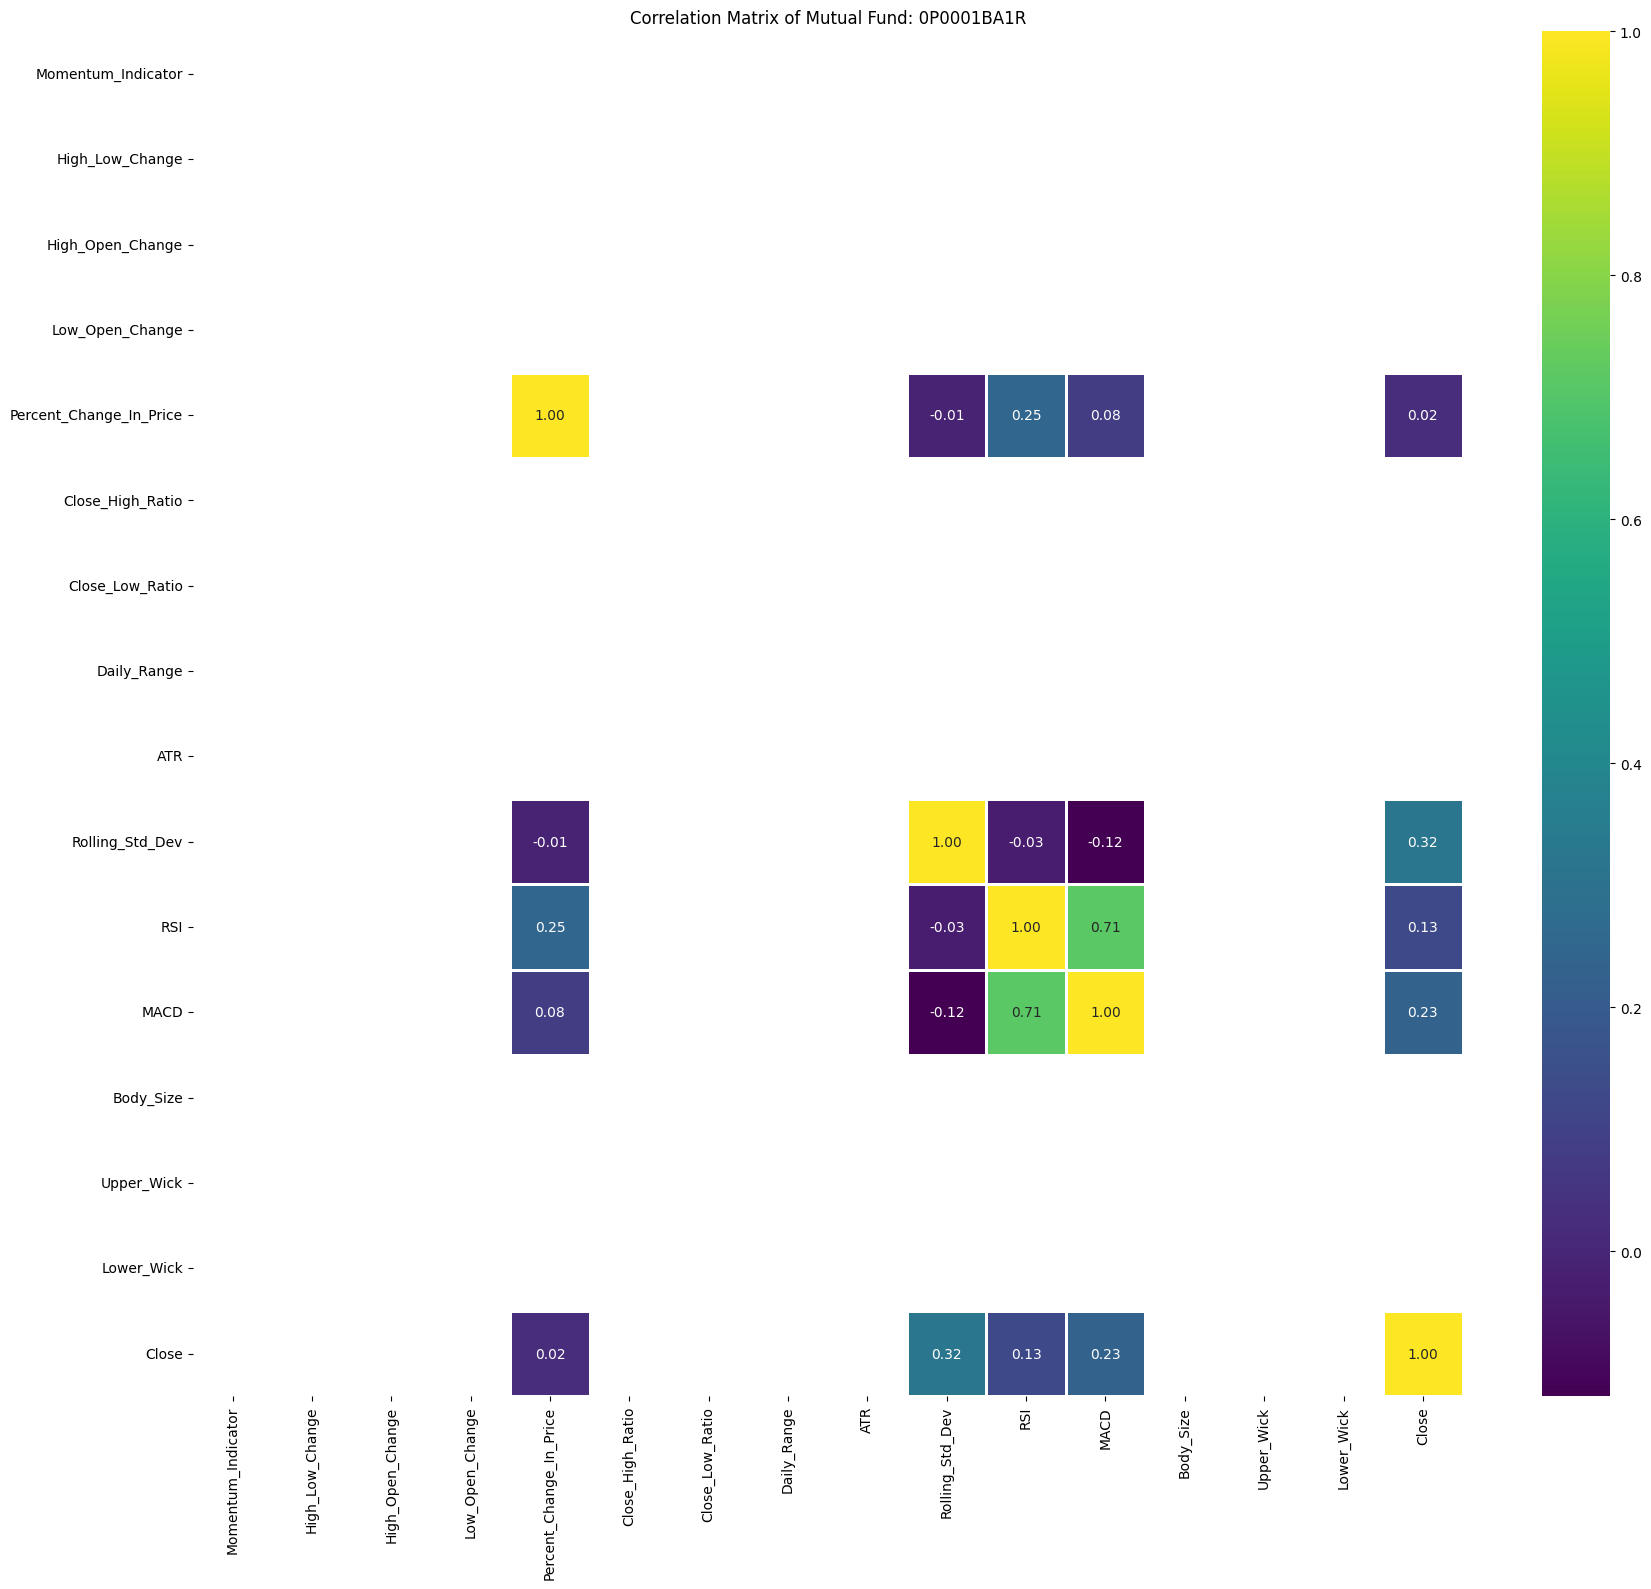


Processing Mutual Fund: 0P00005WEY
R-squared: -17.39731925258503

Mutual Fund: 0P00005WEY - Feature Importances:


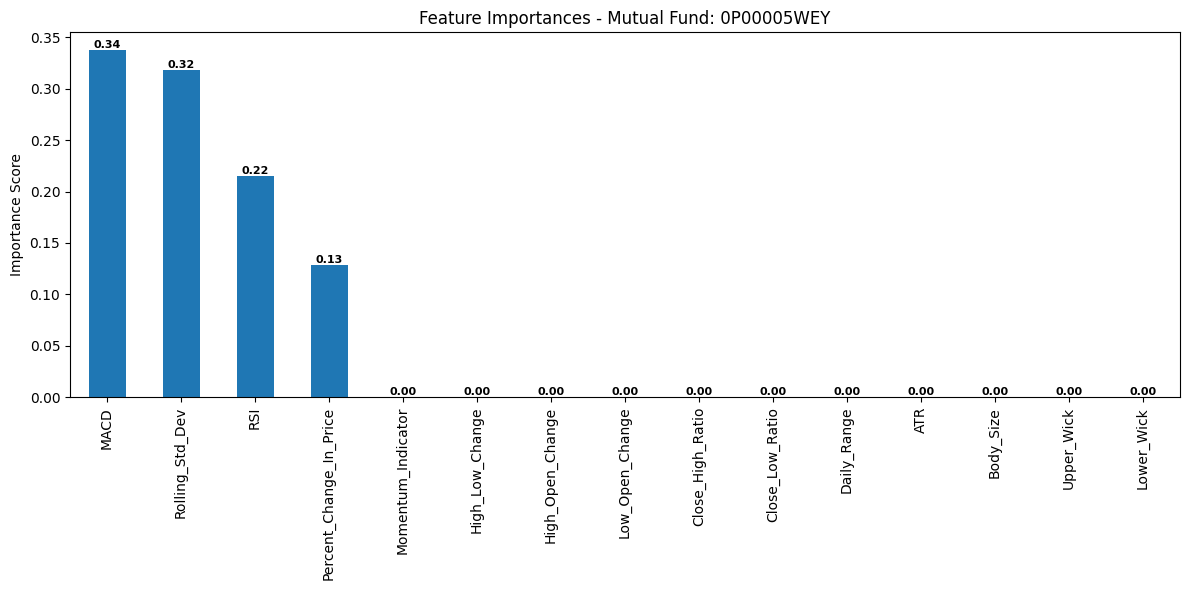

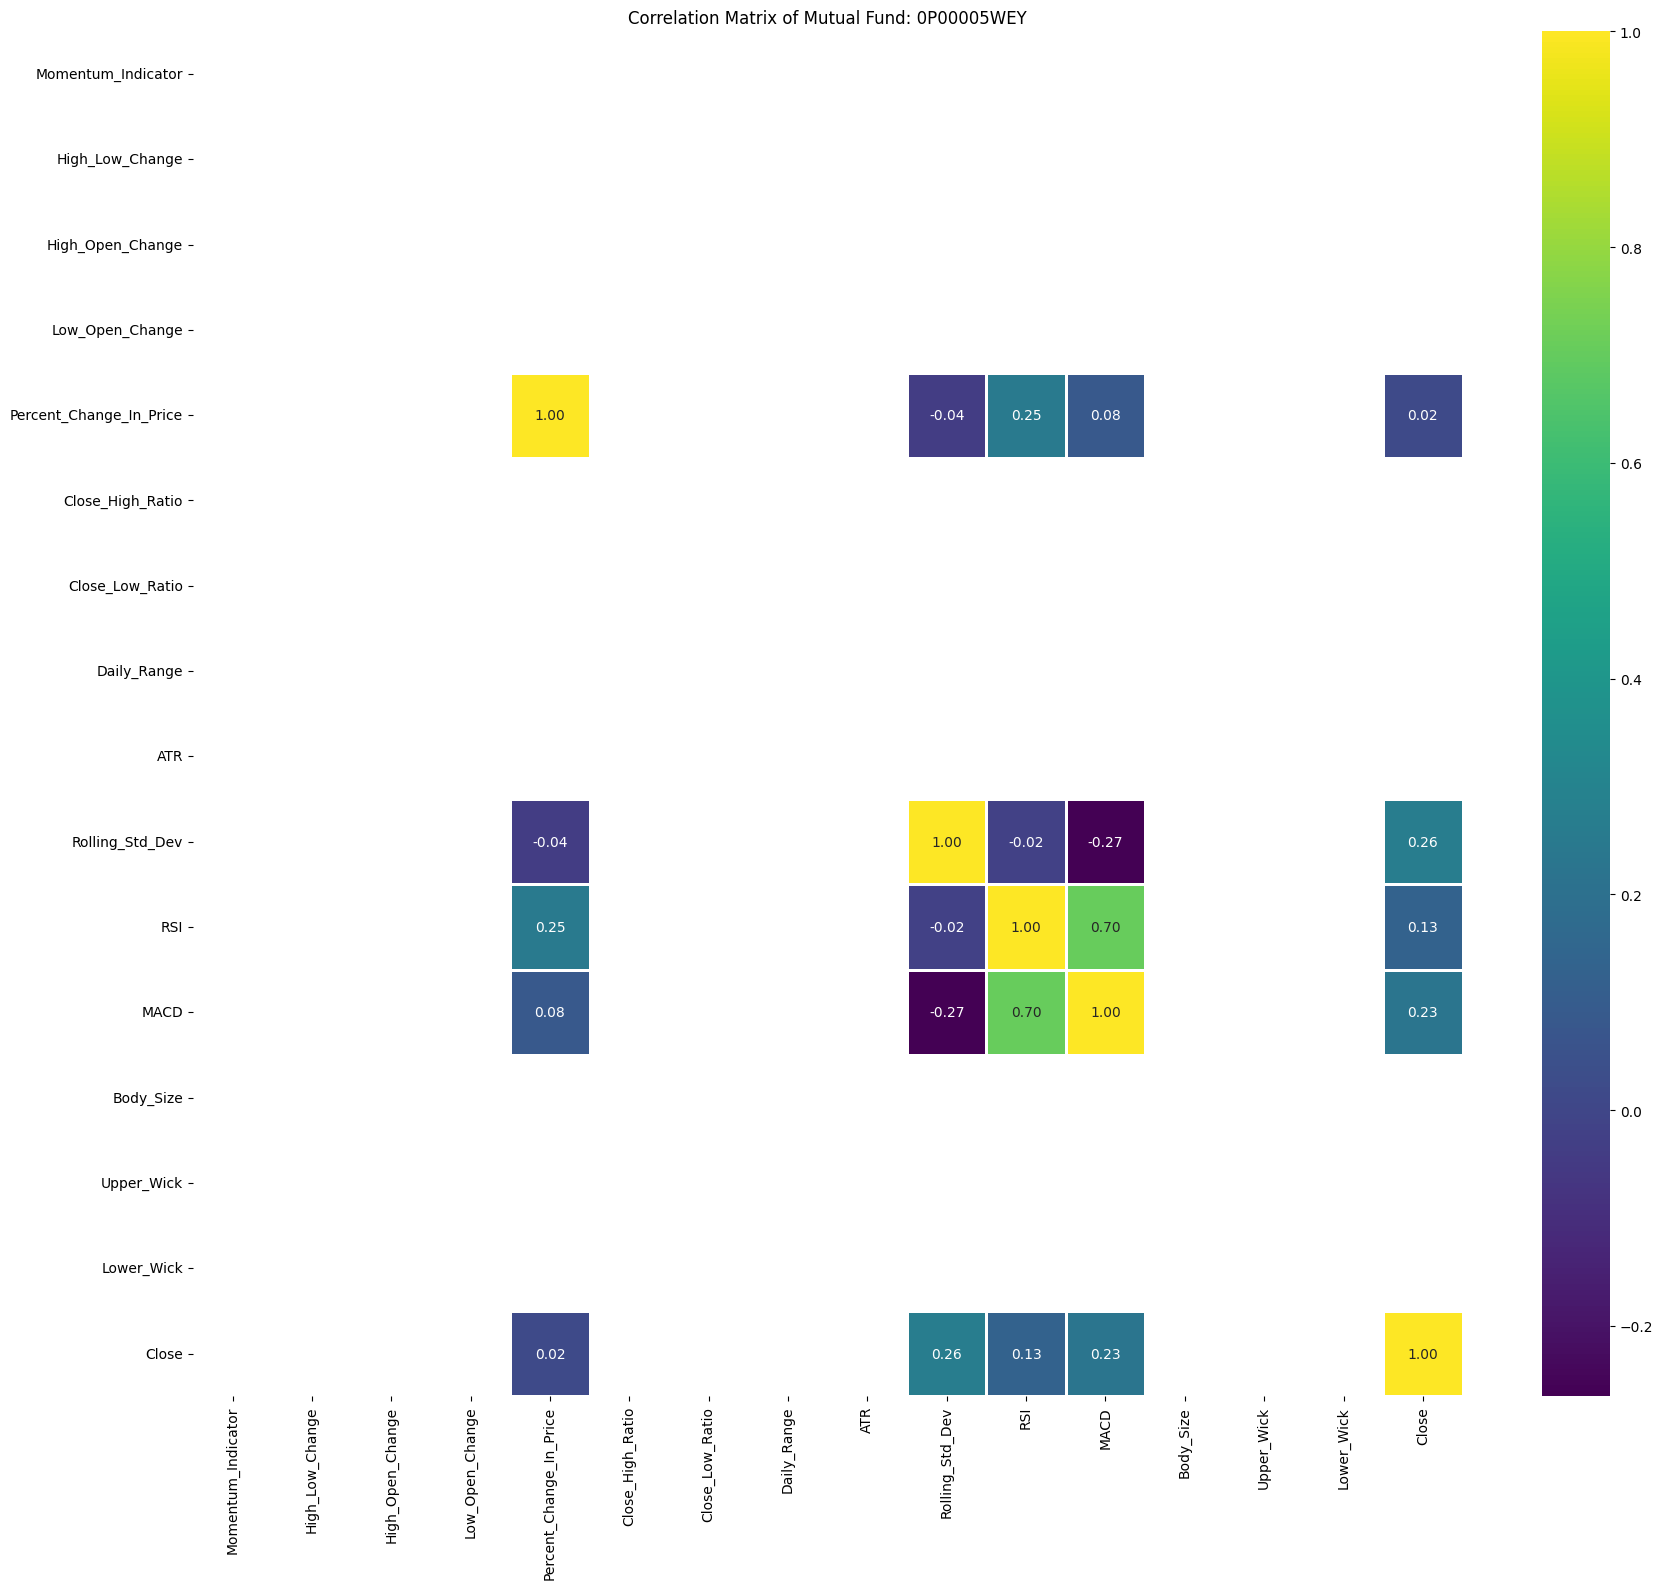


Processing Mutual Fund: 0P0000XUXL
R-squared: -38.729964080808955

Mutual Fund: 0P0000XUXL - Feature Importances:


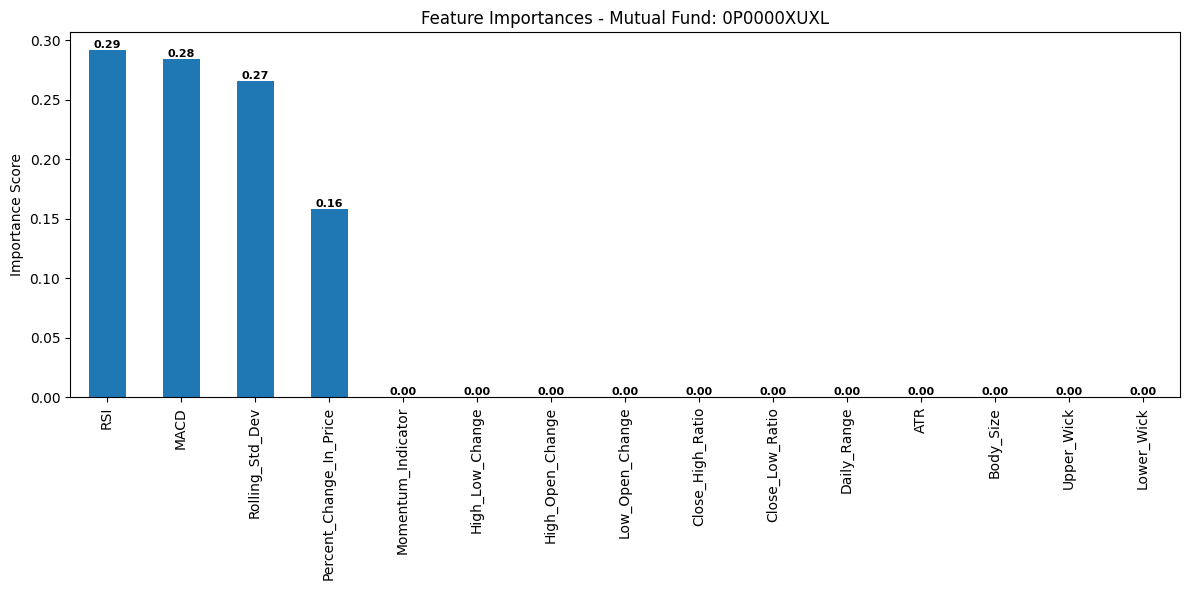

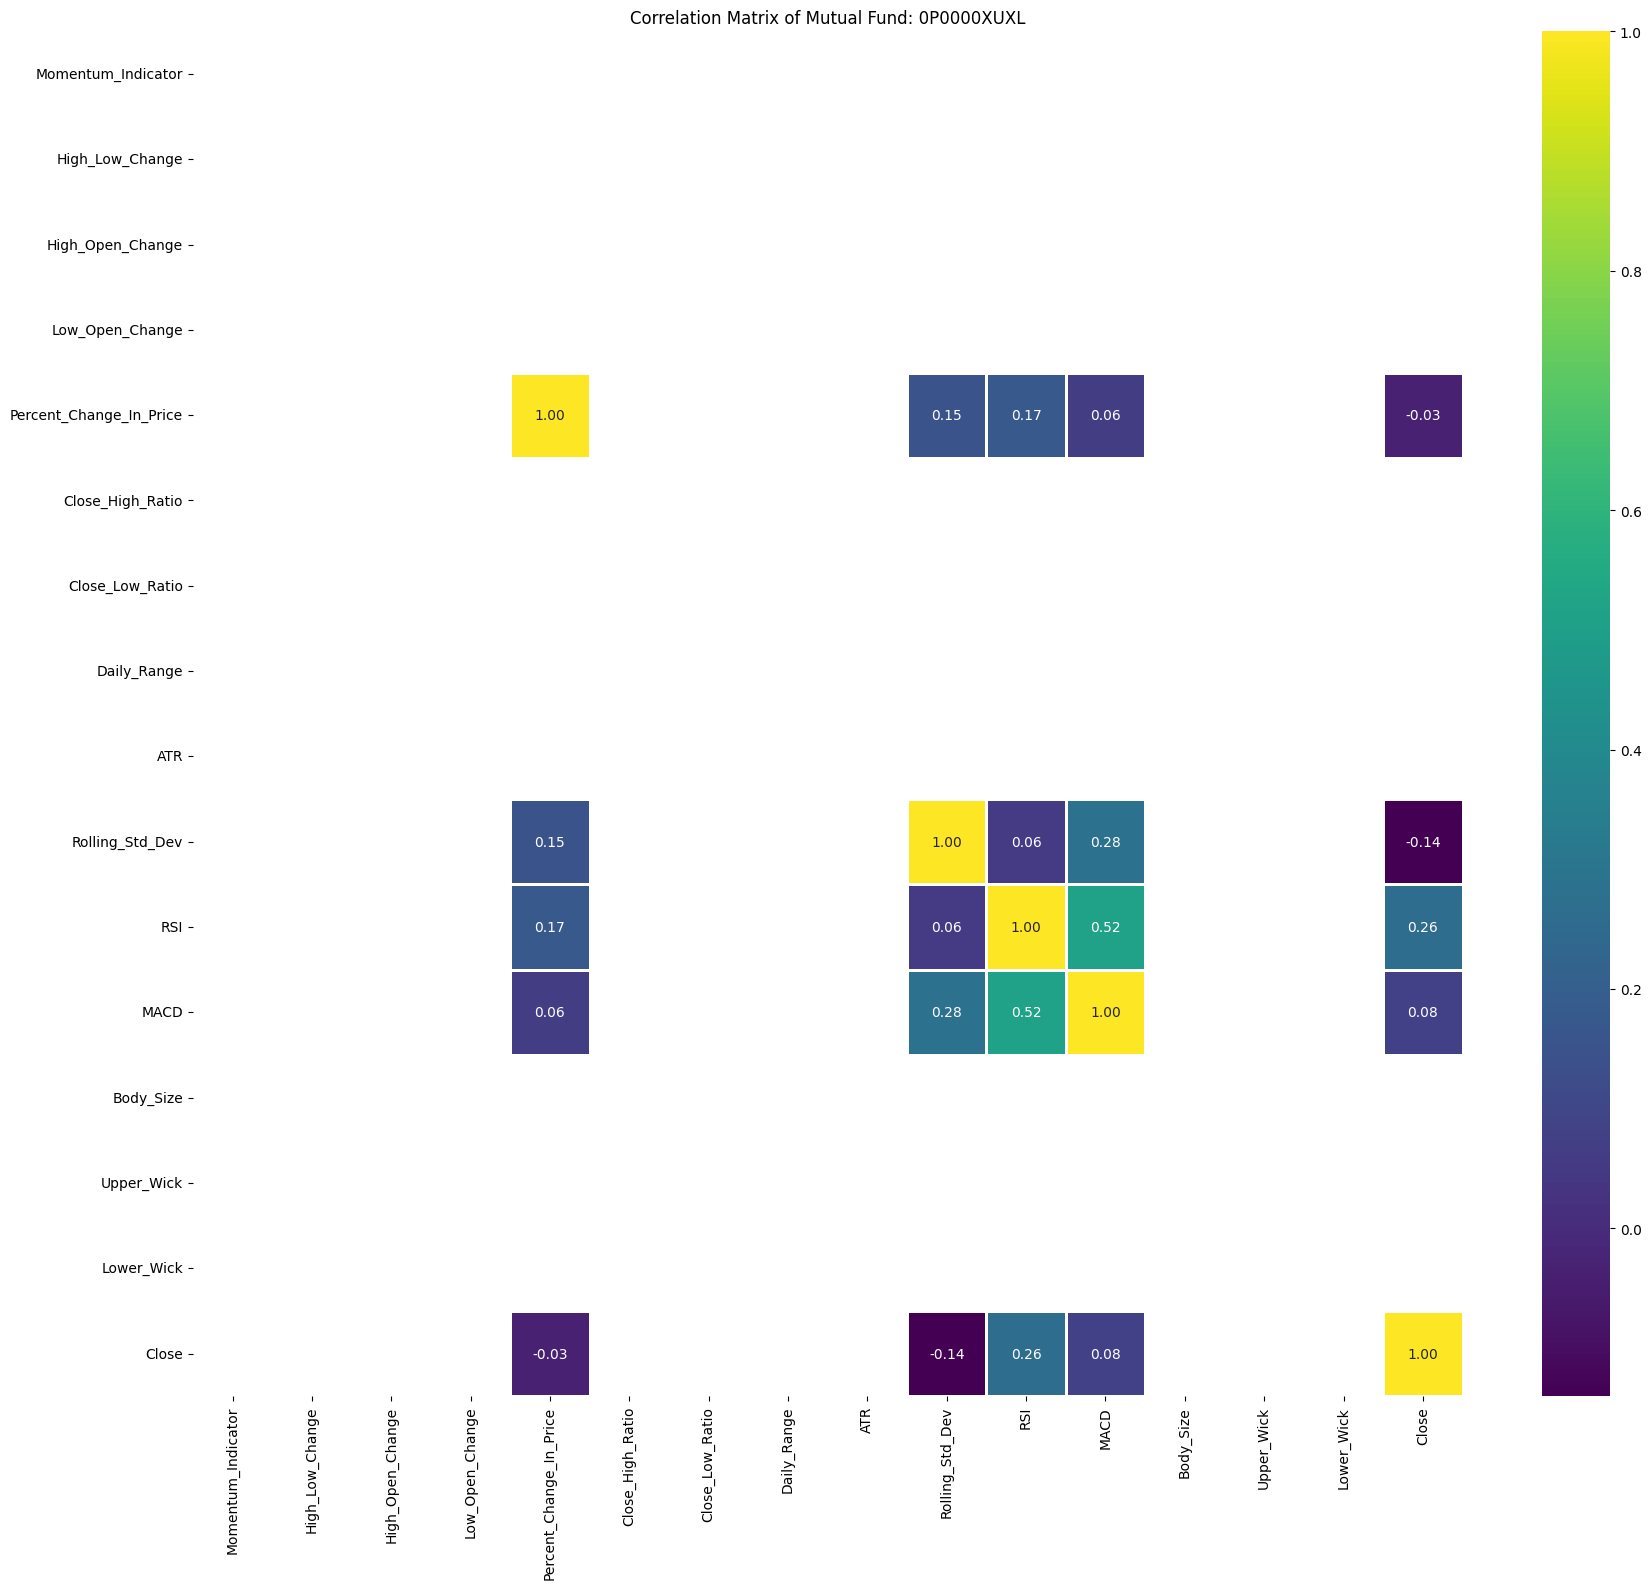


Processing Mutual Fund: 0P0000XUYZ
R-squared: -41.23288139635835

Mutual Fund: 0P0000XUYZ - Feature Importances:


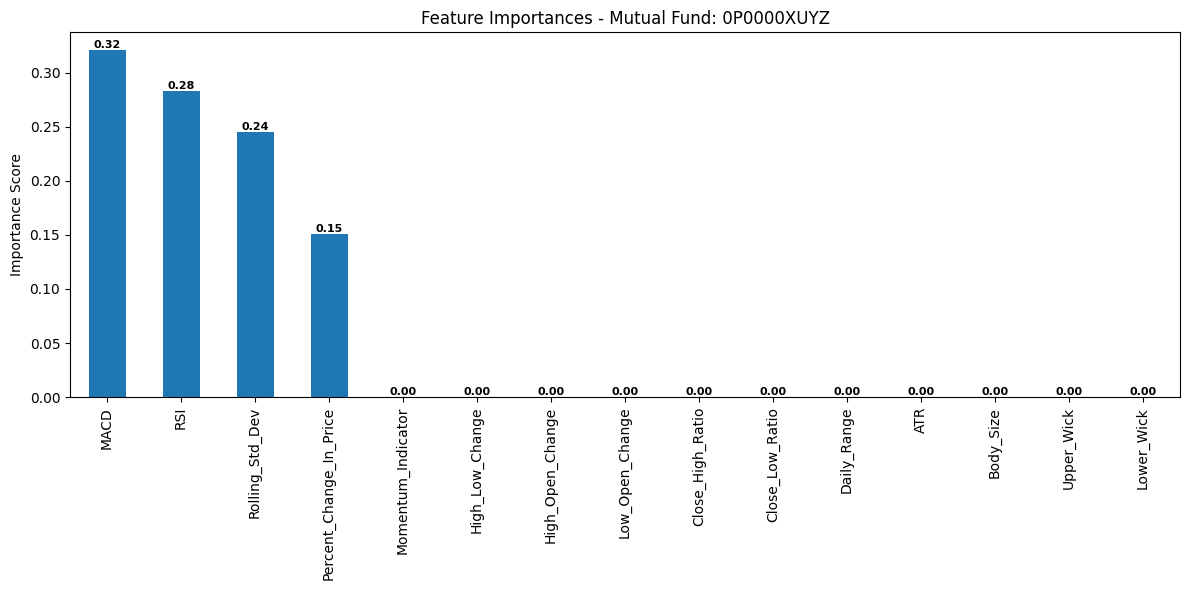

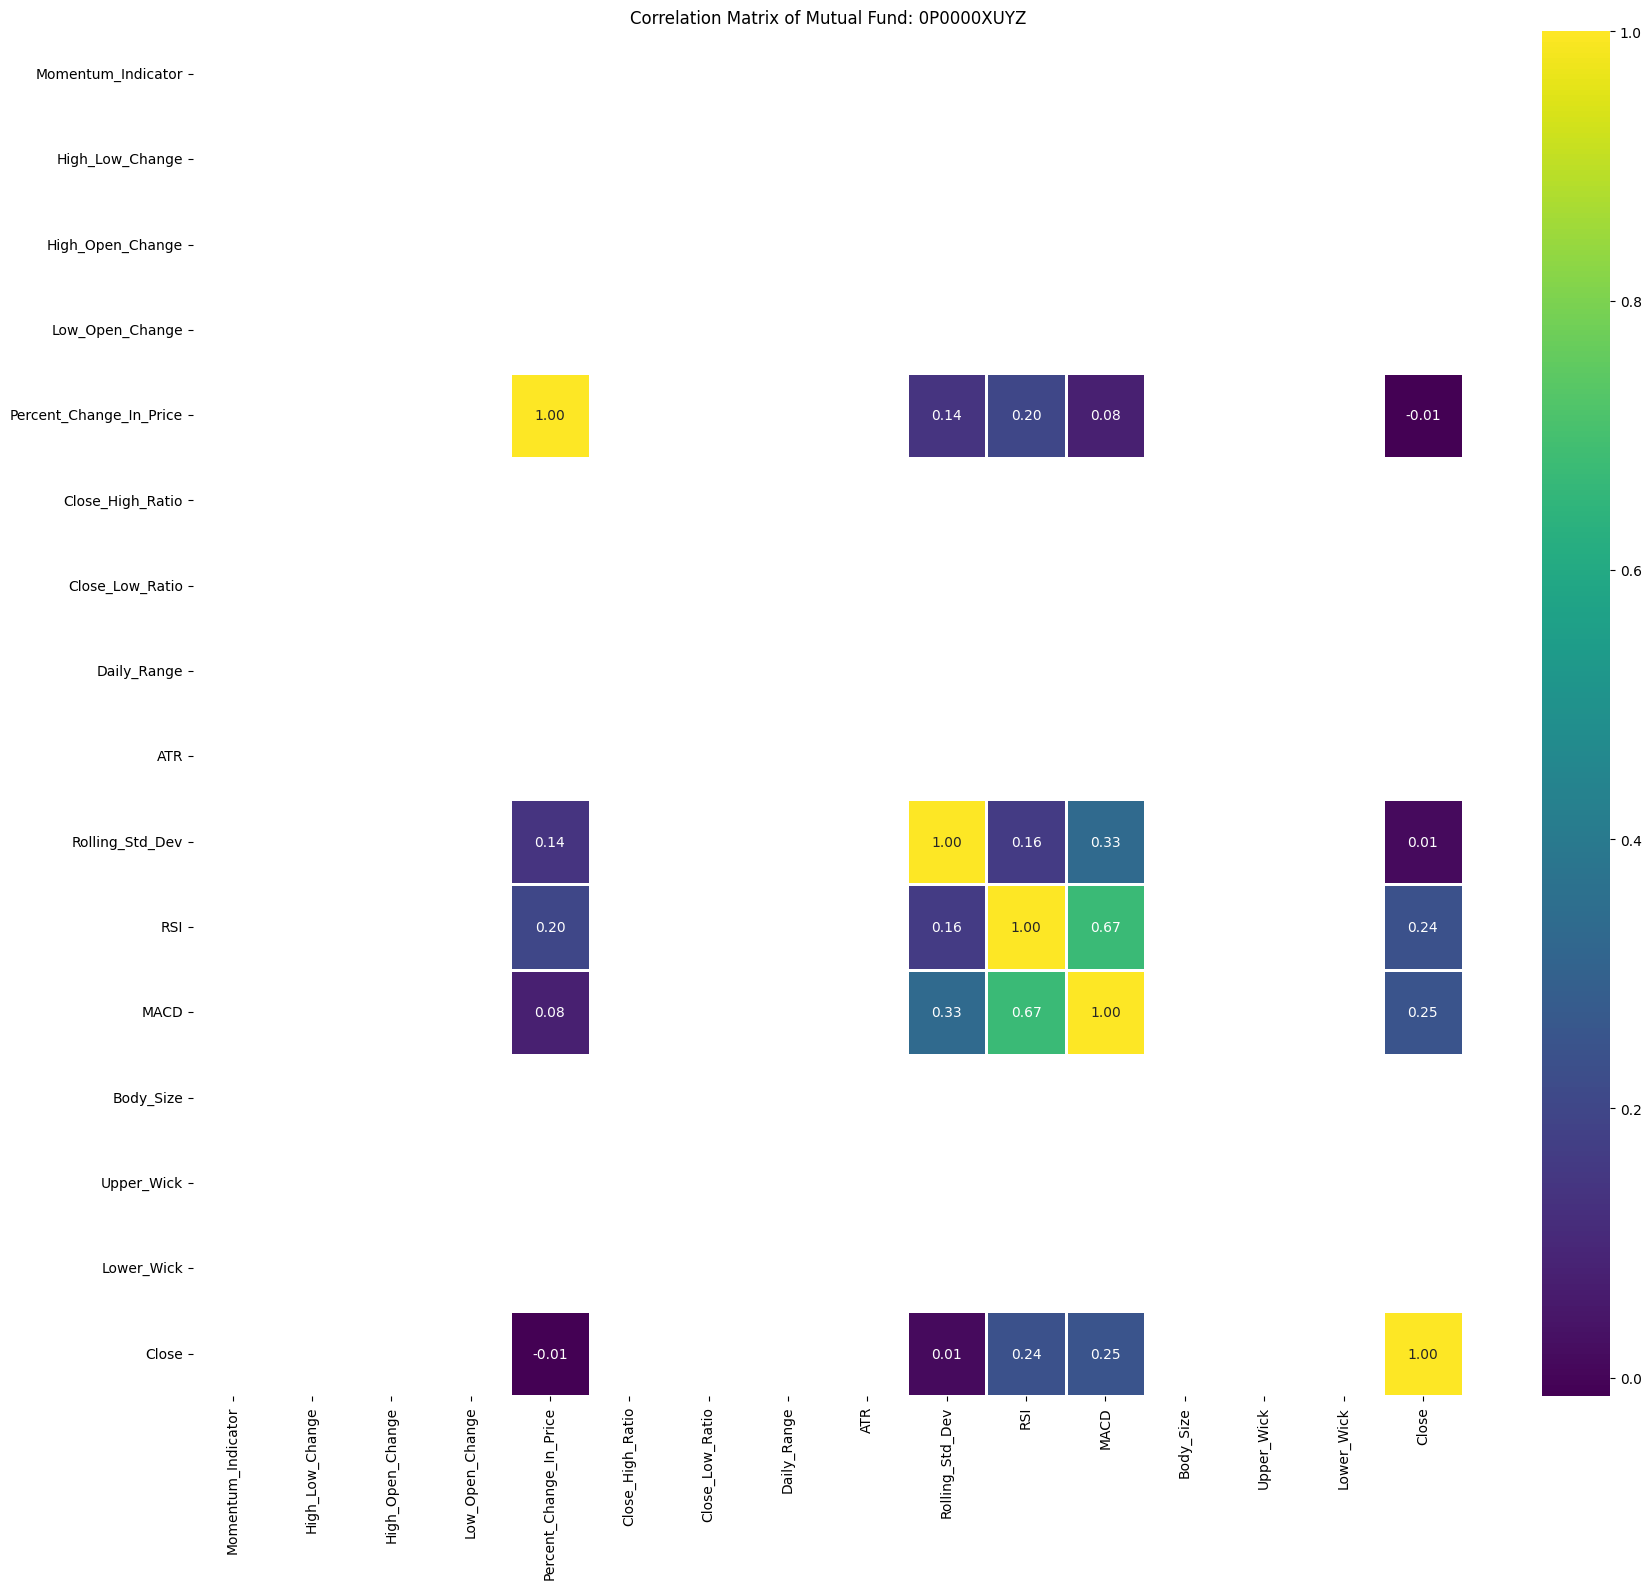


Processing Mutual Fund: 0P0000XW8D
R-squared: -36.20830127497264

Mutual Fund: 0P0000XW8D - Feature Importances:


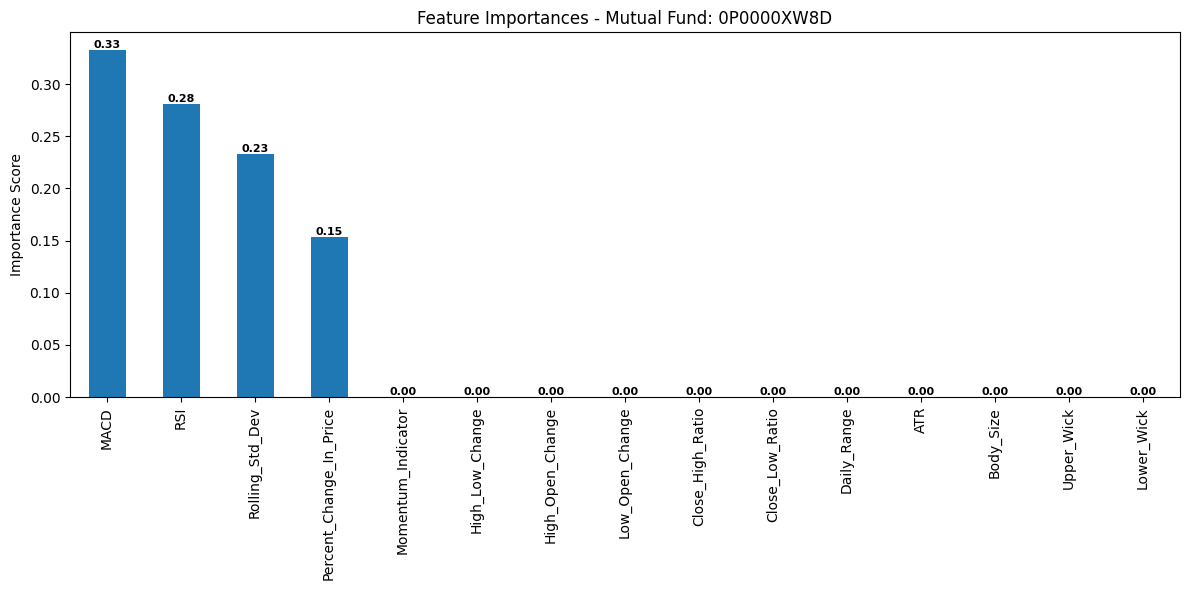

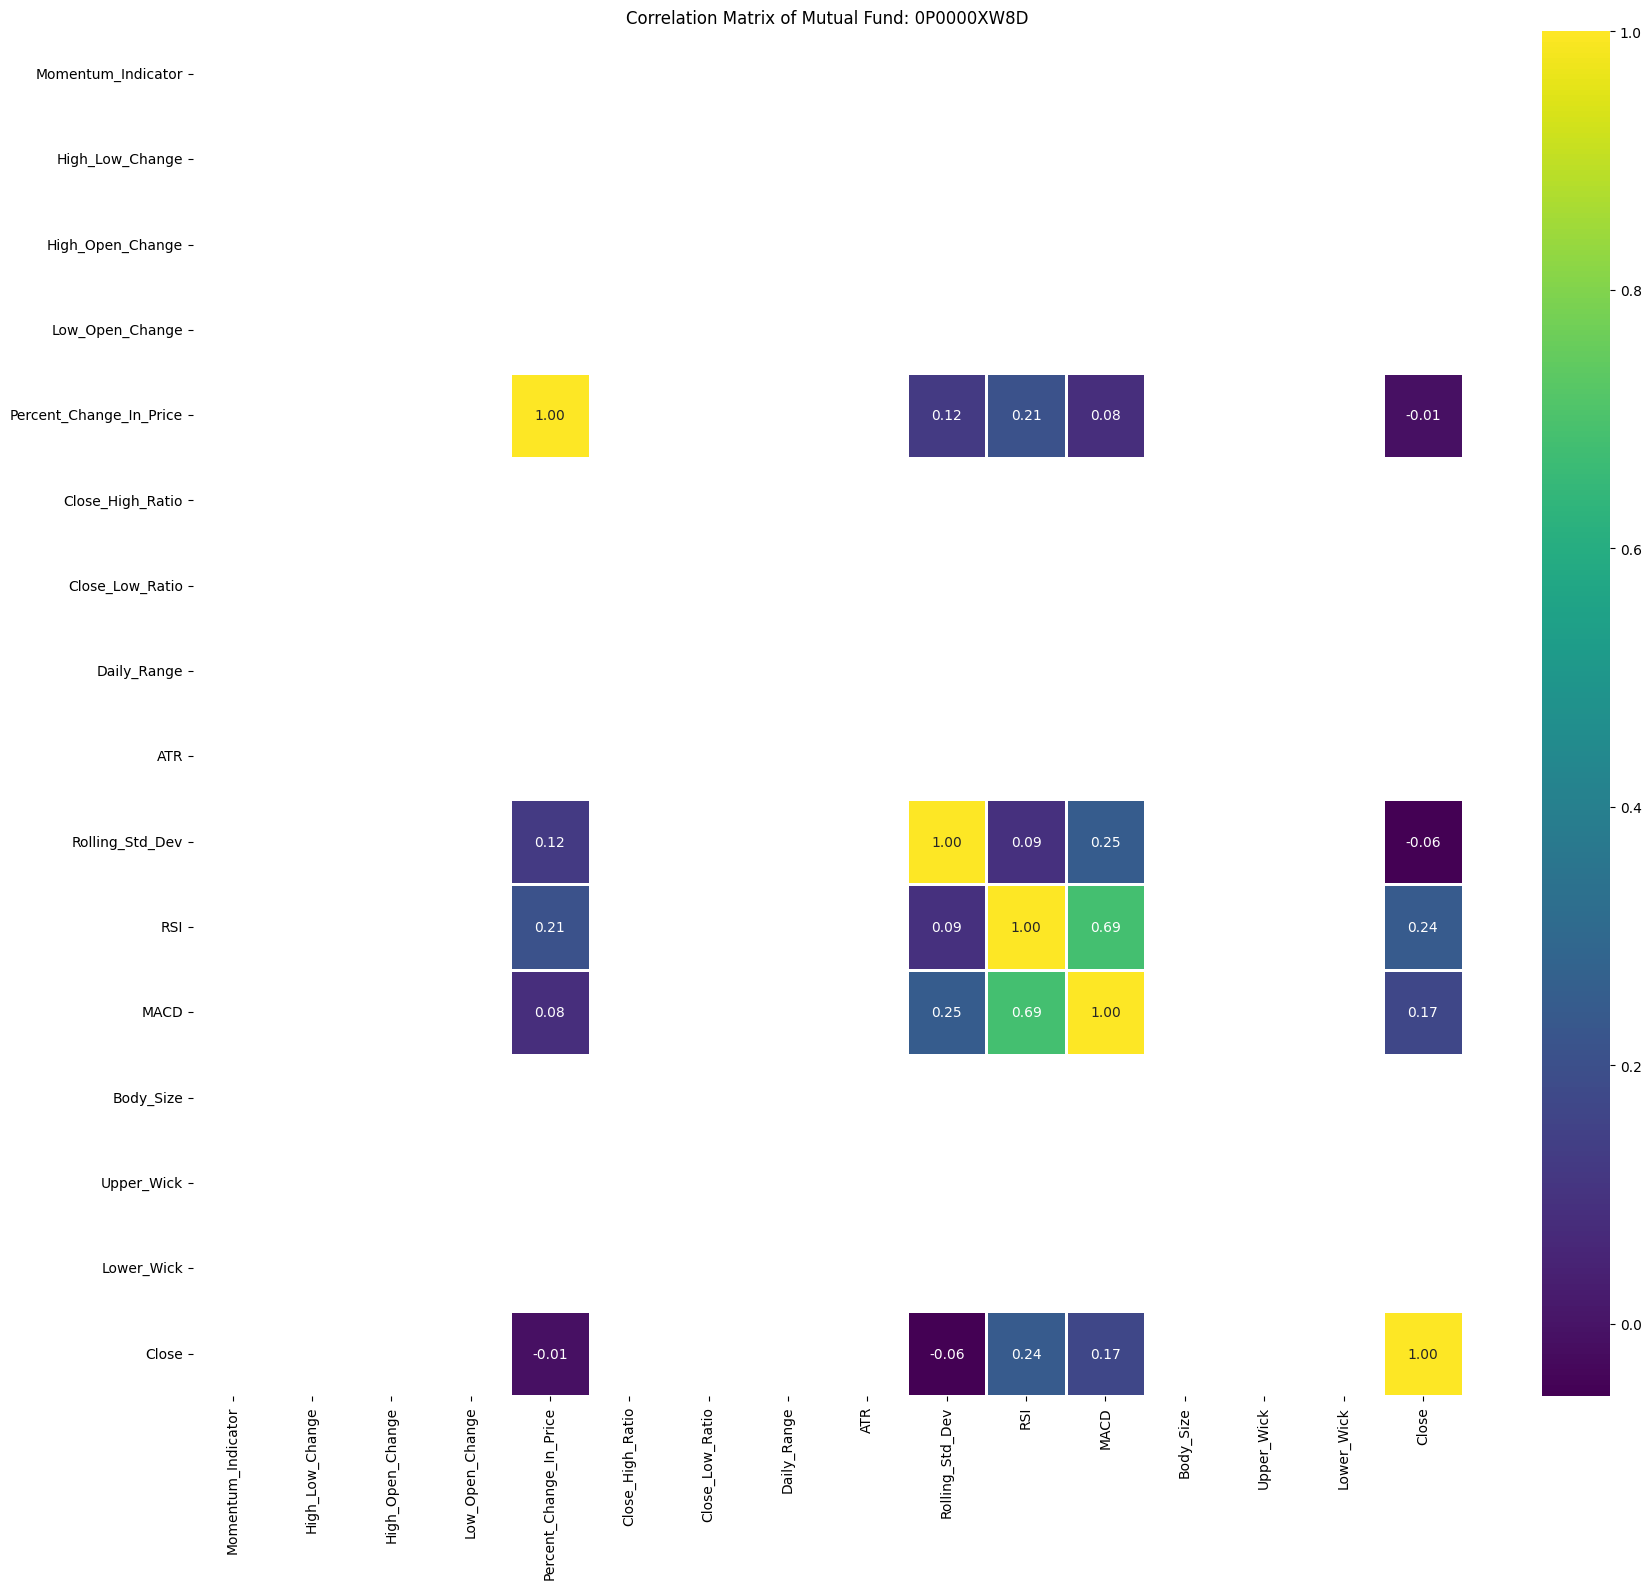


Processing Mutual Fund: 0P0000XVER
R-squared: -7.229706943752749

Mutual Fund: 0P0000XVER - Feature Importances:


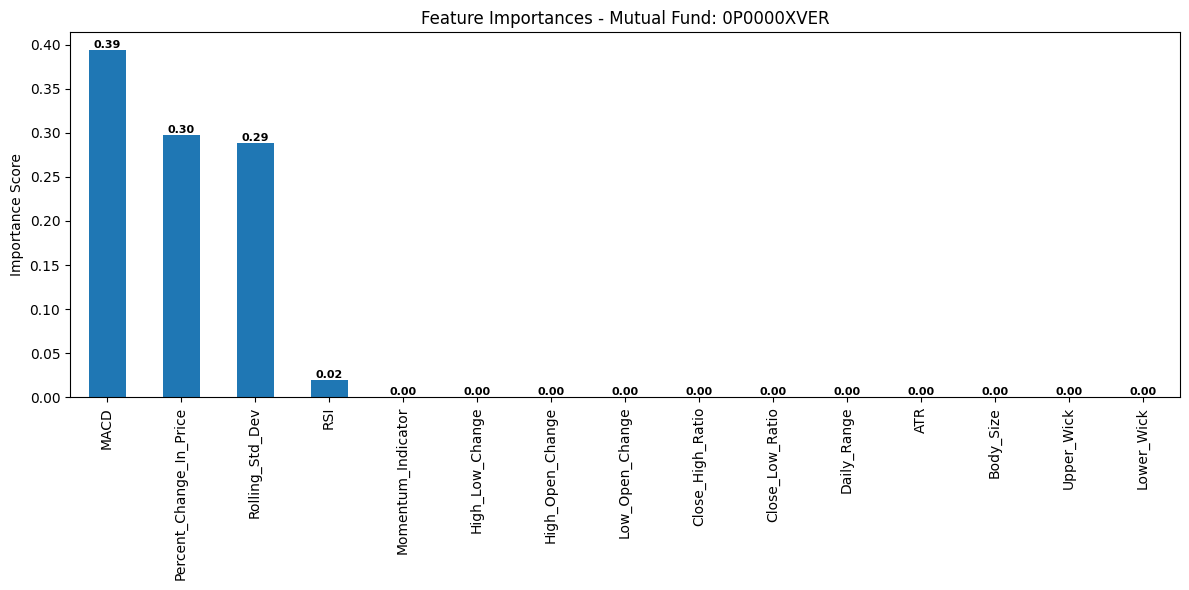

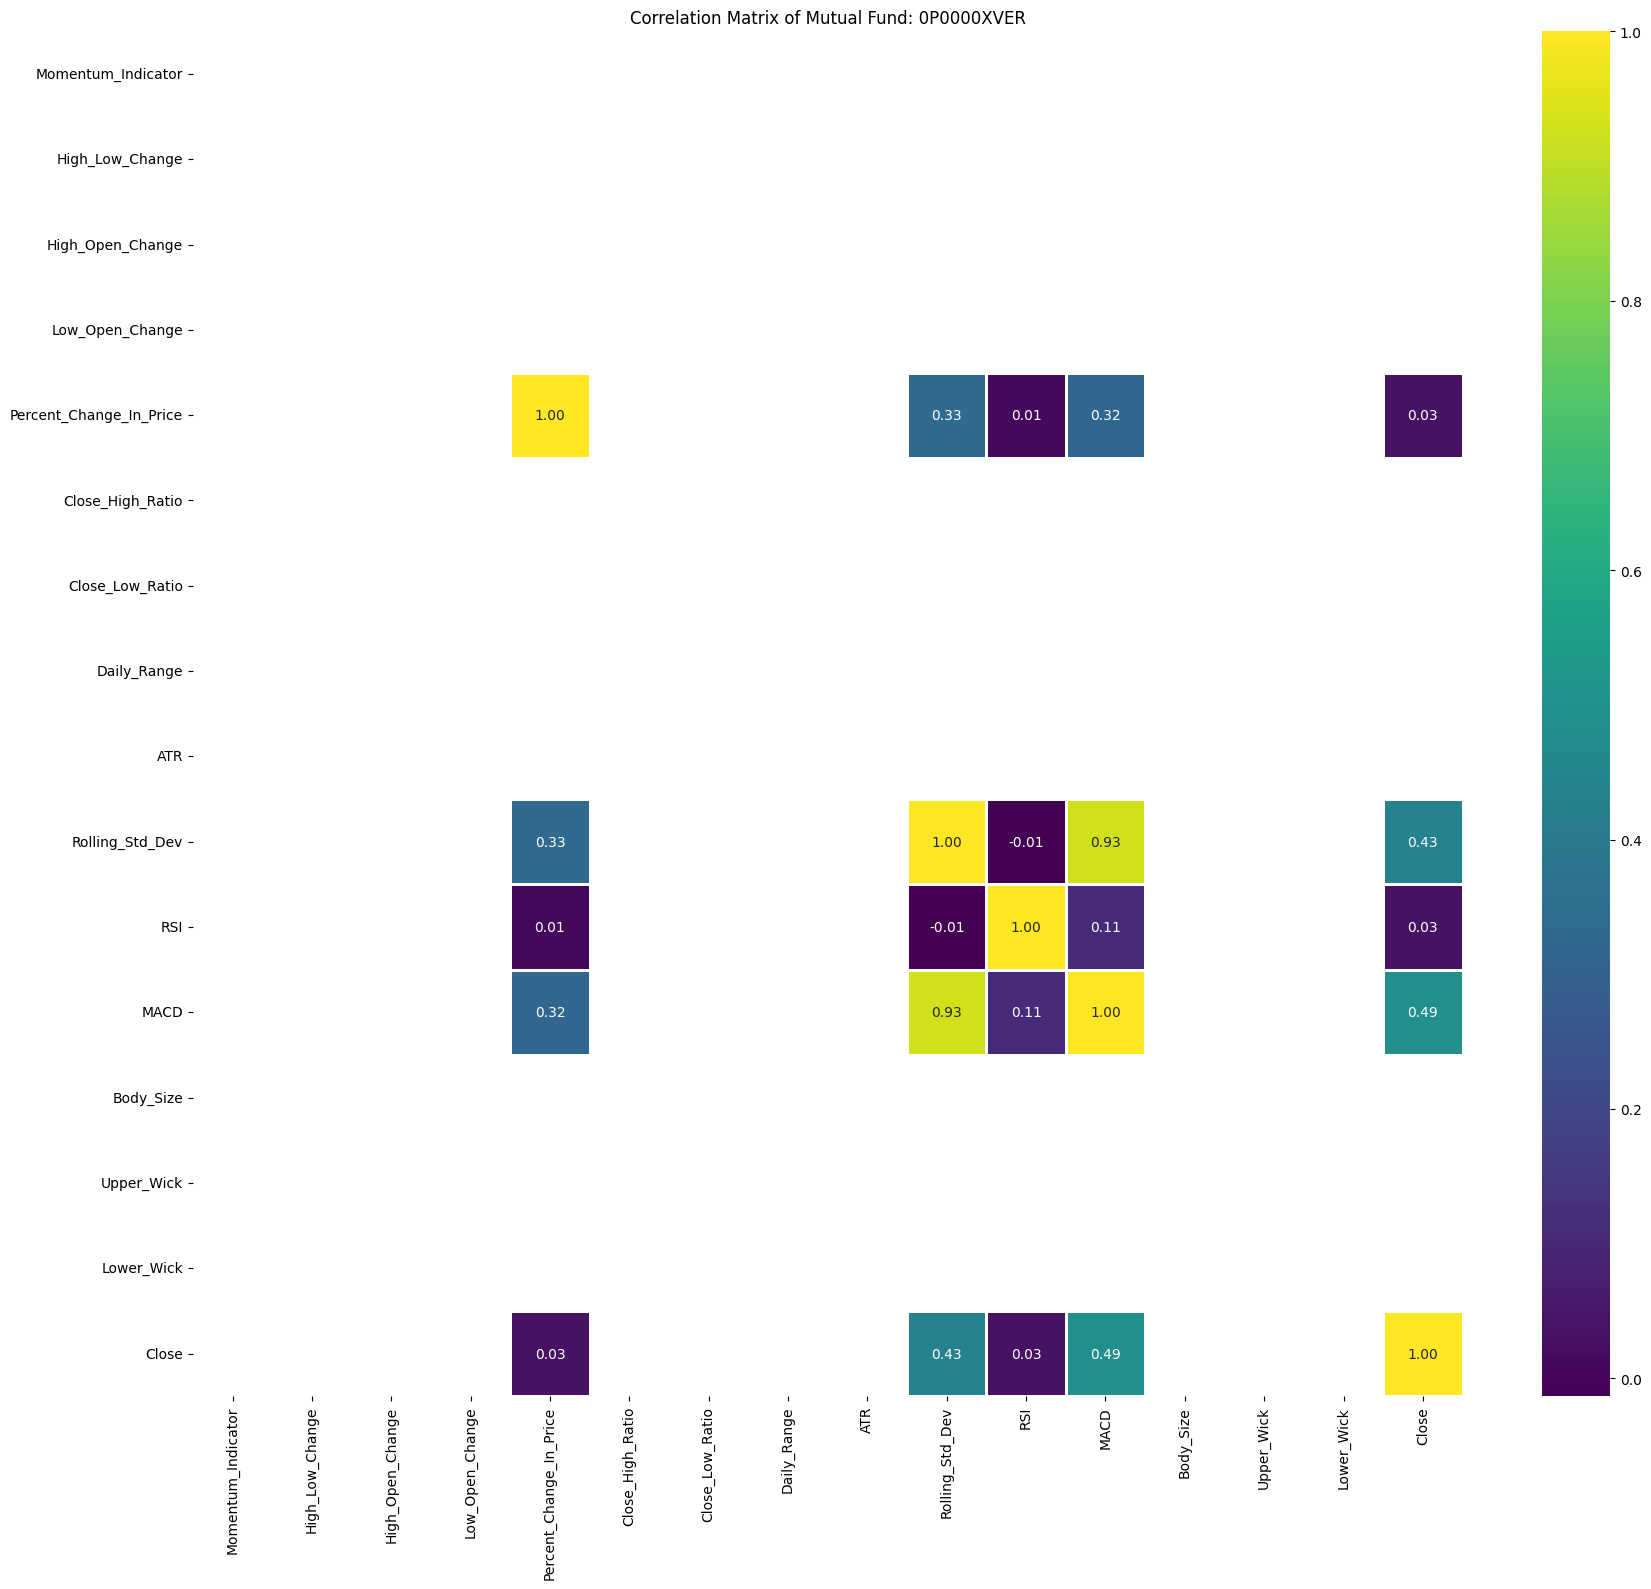


Processing Mutual Fund: 0P0000XUYS
R-squared: -7.060403165376204

Mutual Fund: 0P0000XUYS - Feature Importances:


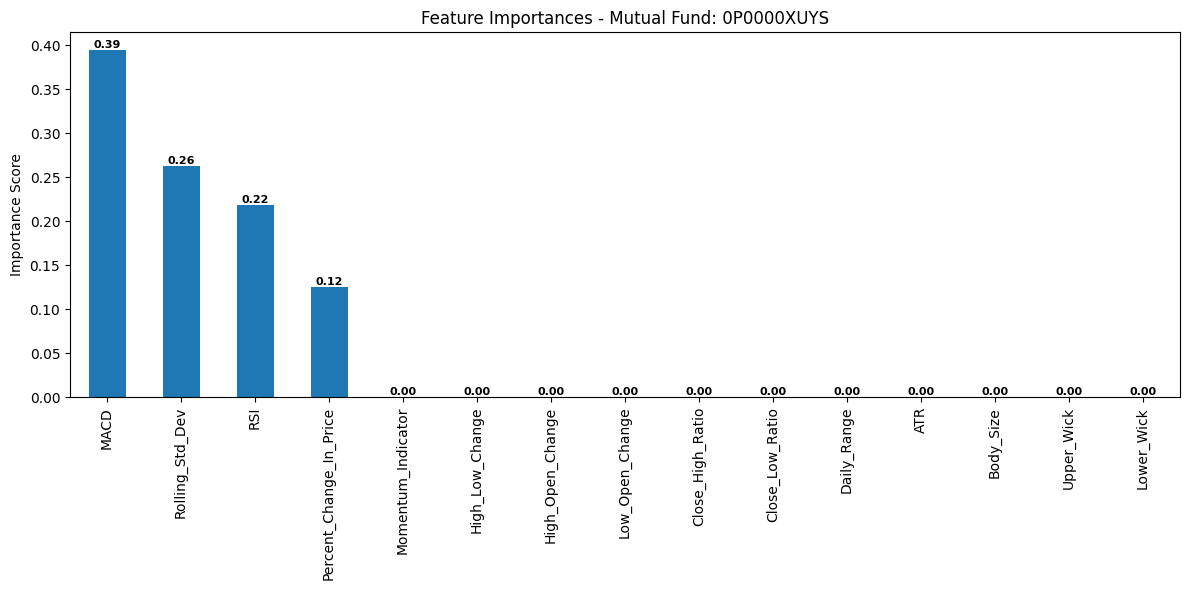

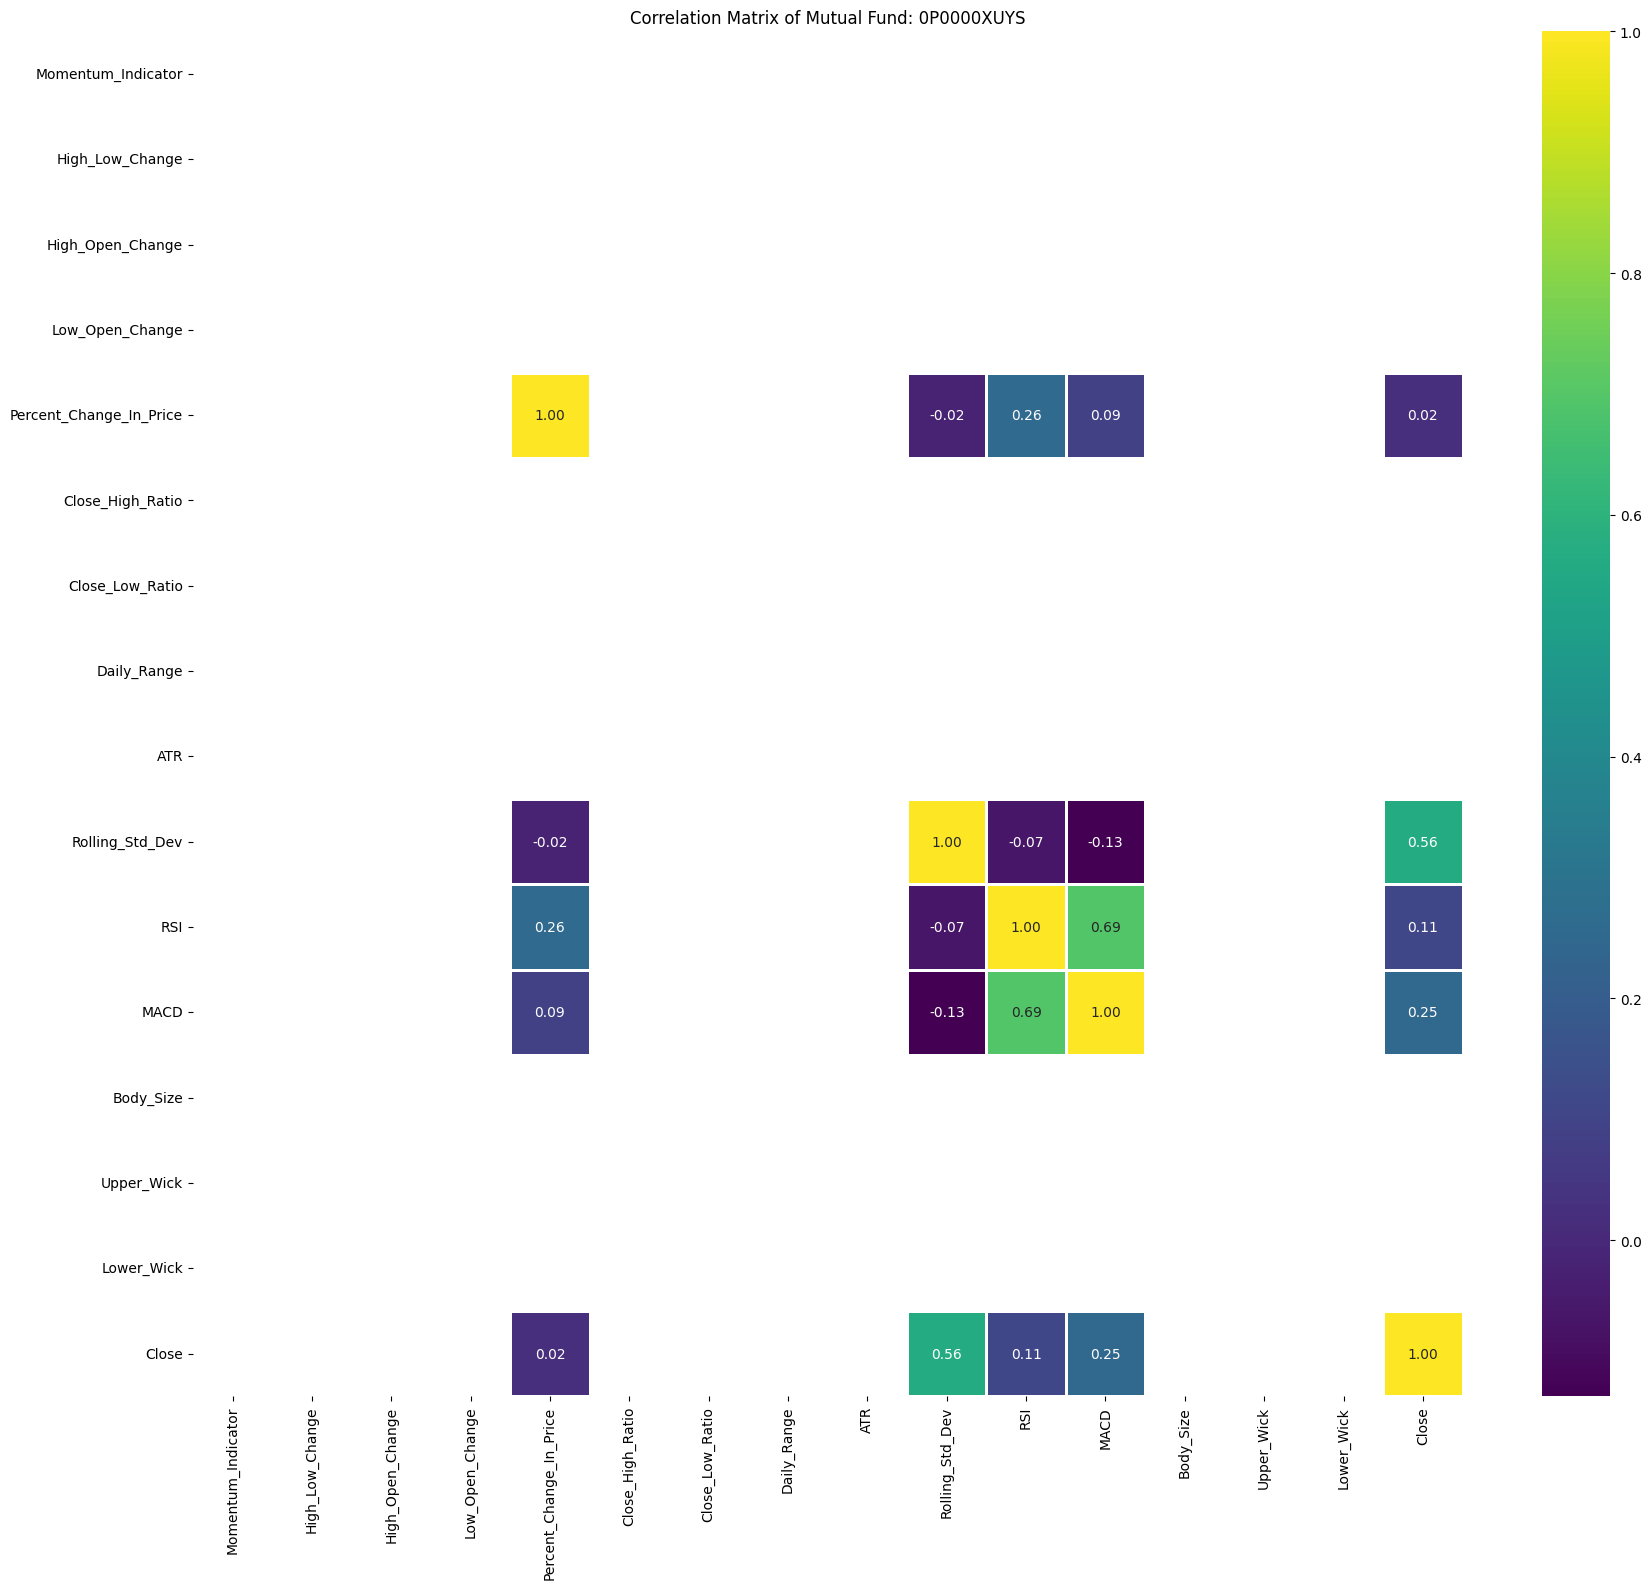


Processing Mutual Fund: 0P0000XW7I
R-squared: -8.893290482882522

Mutual Fund: 0P0000XW7I - Feature Importances:


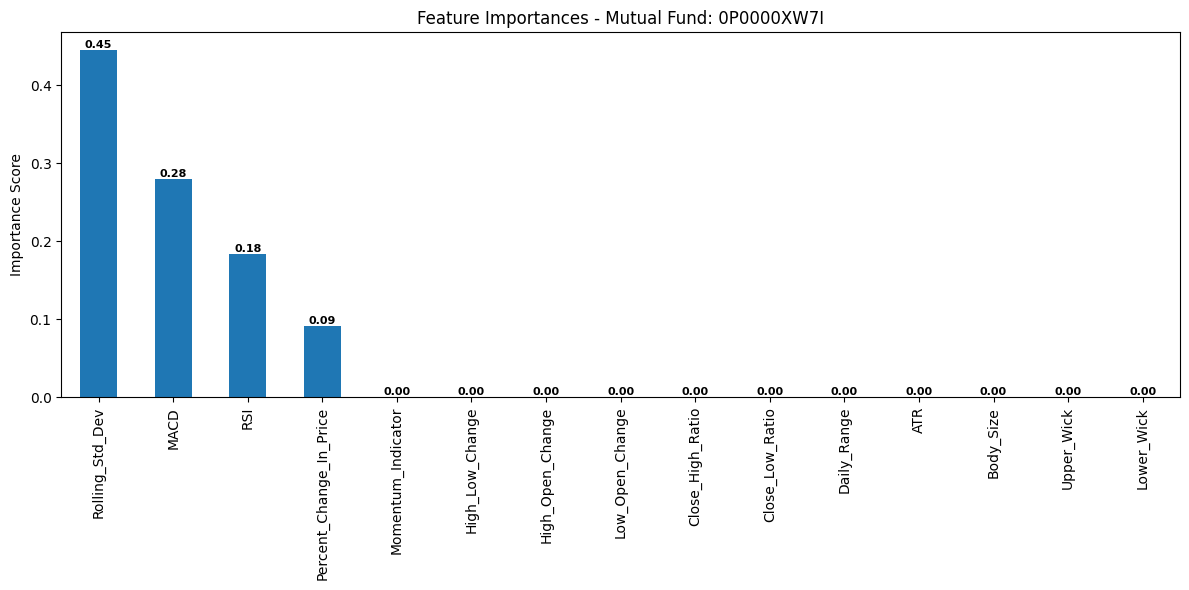

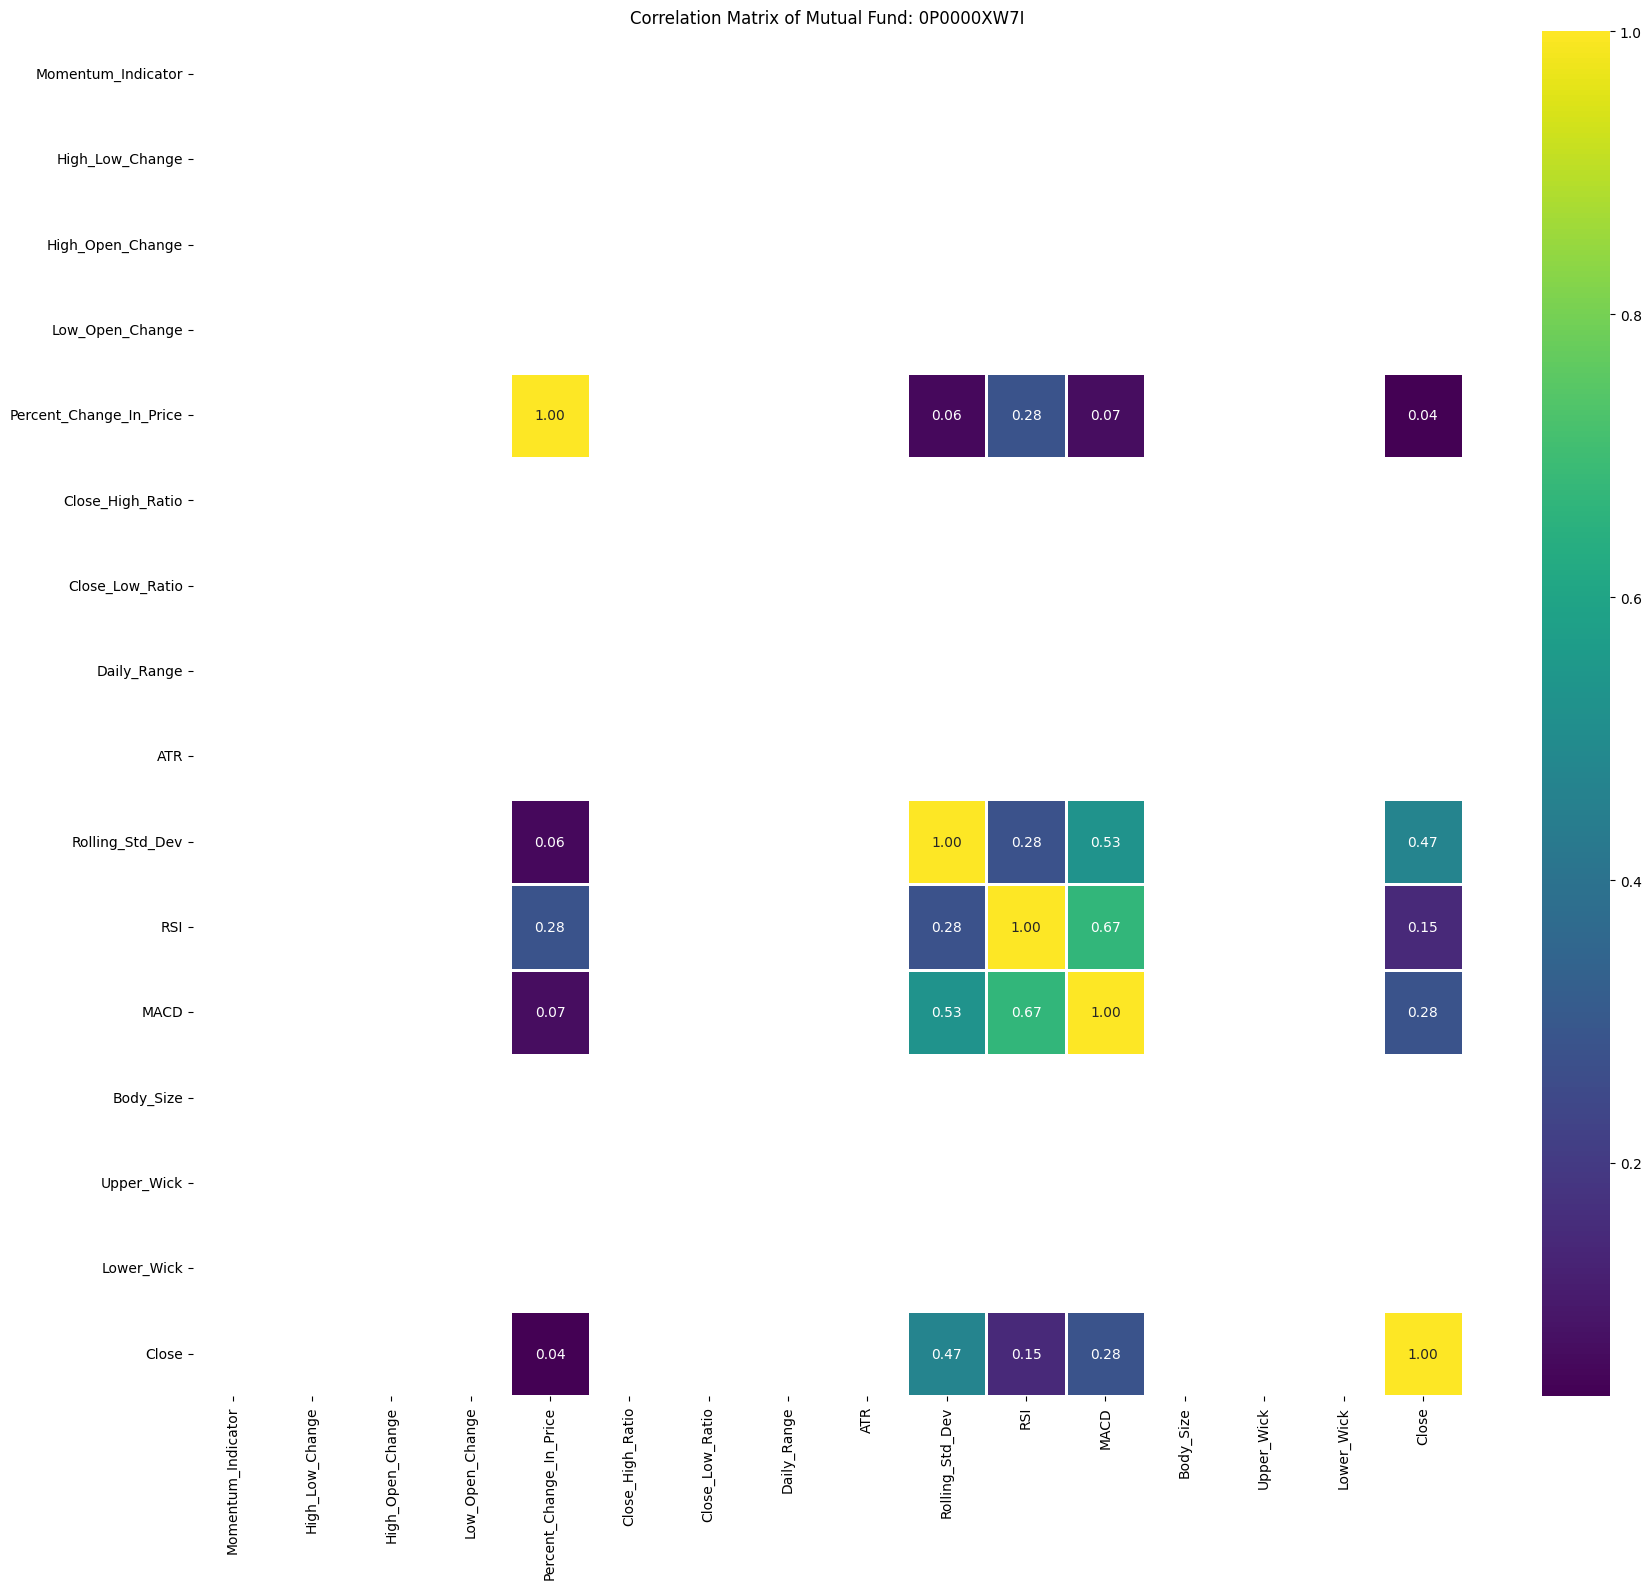


Processing Mutual Fund: 0P0000U3OG
R-squared: -9.020559187027091

Mutual Fund: 0P0000U3OG - Feature Importances:


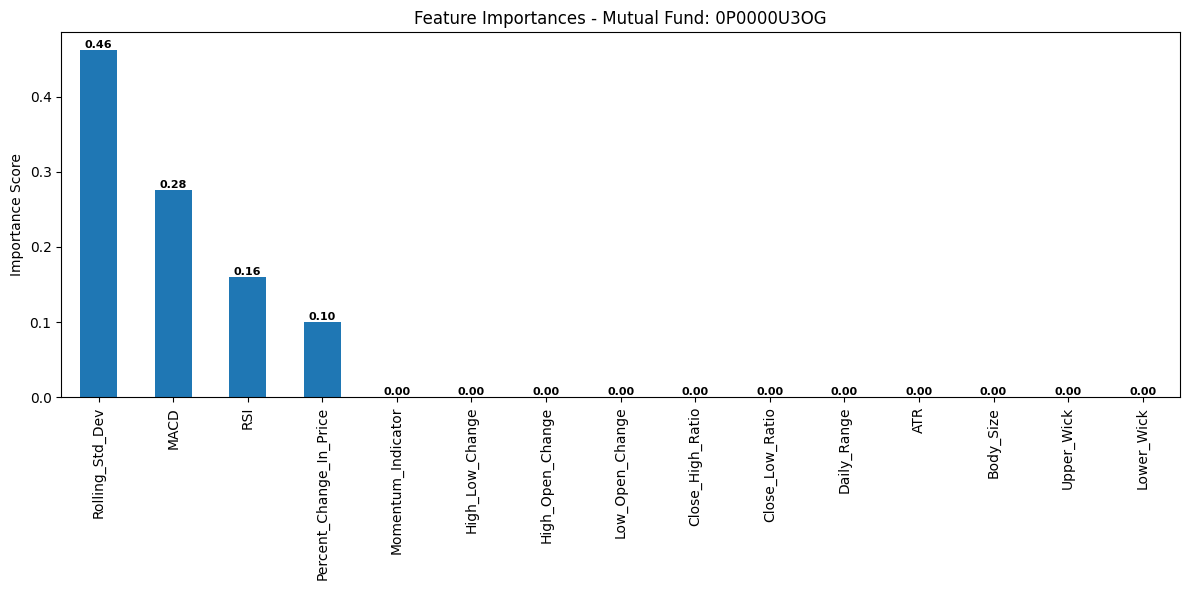

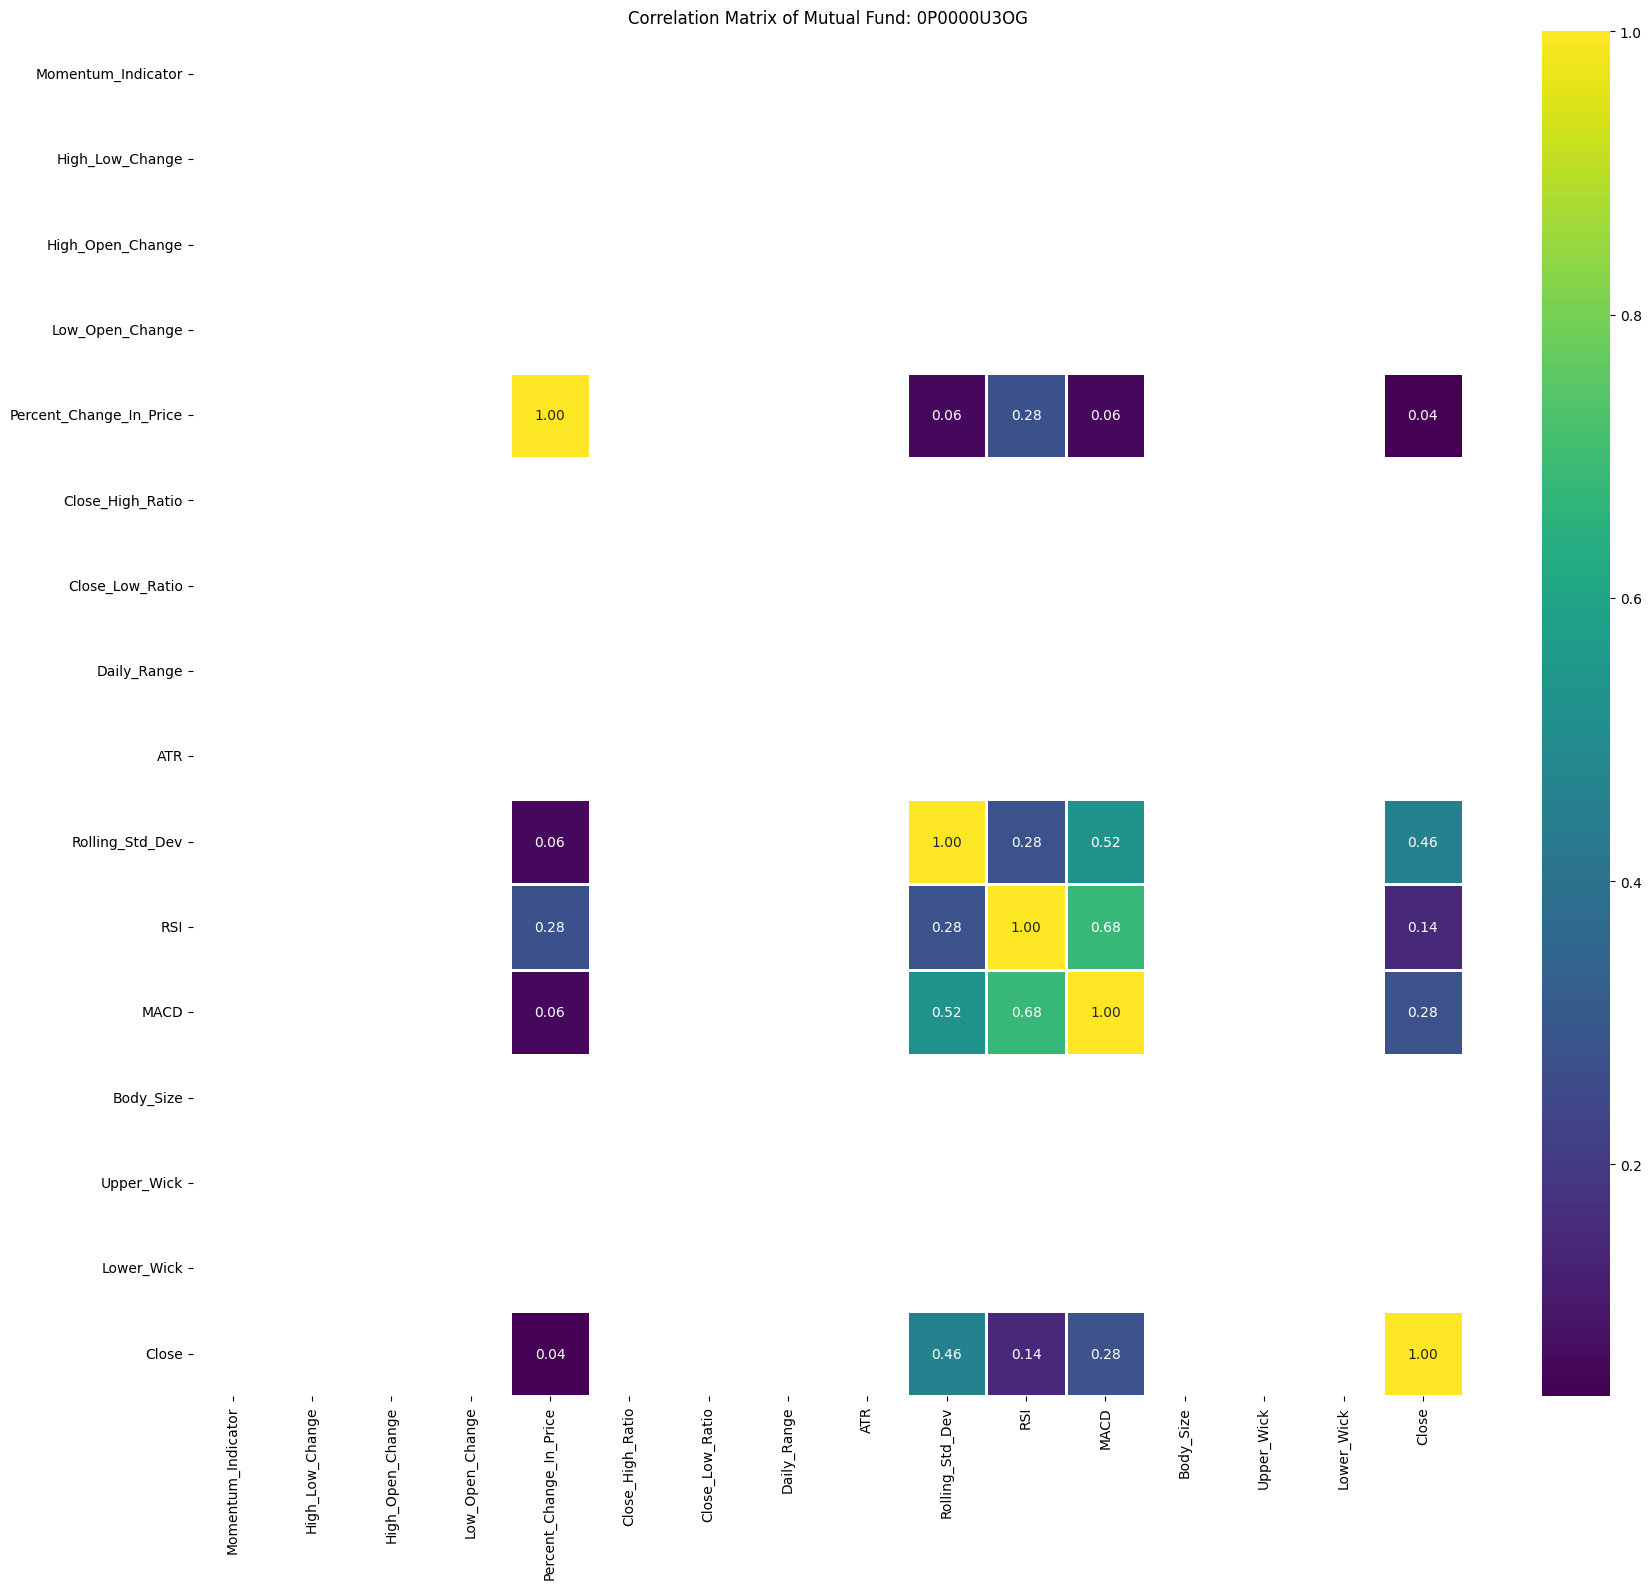


Processing Mutual Fund: SETFGOLD
R-squared: -45.05775368094494

Mutual Fund: SETFGOLD - Feature Importances:


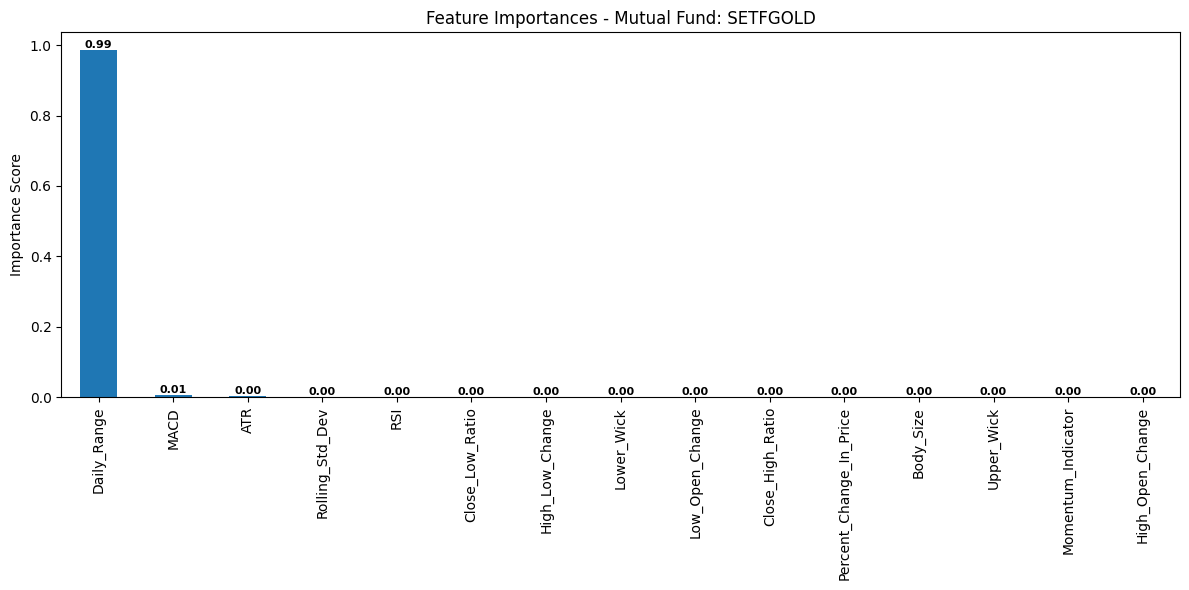

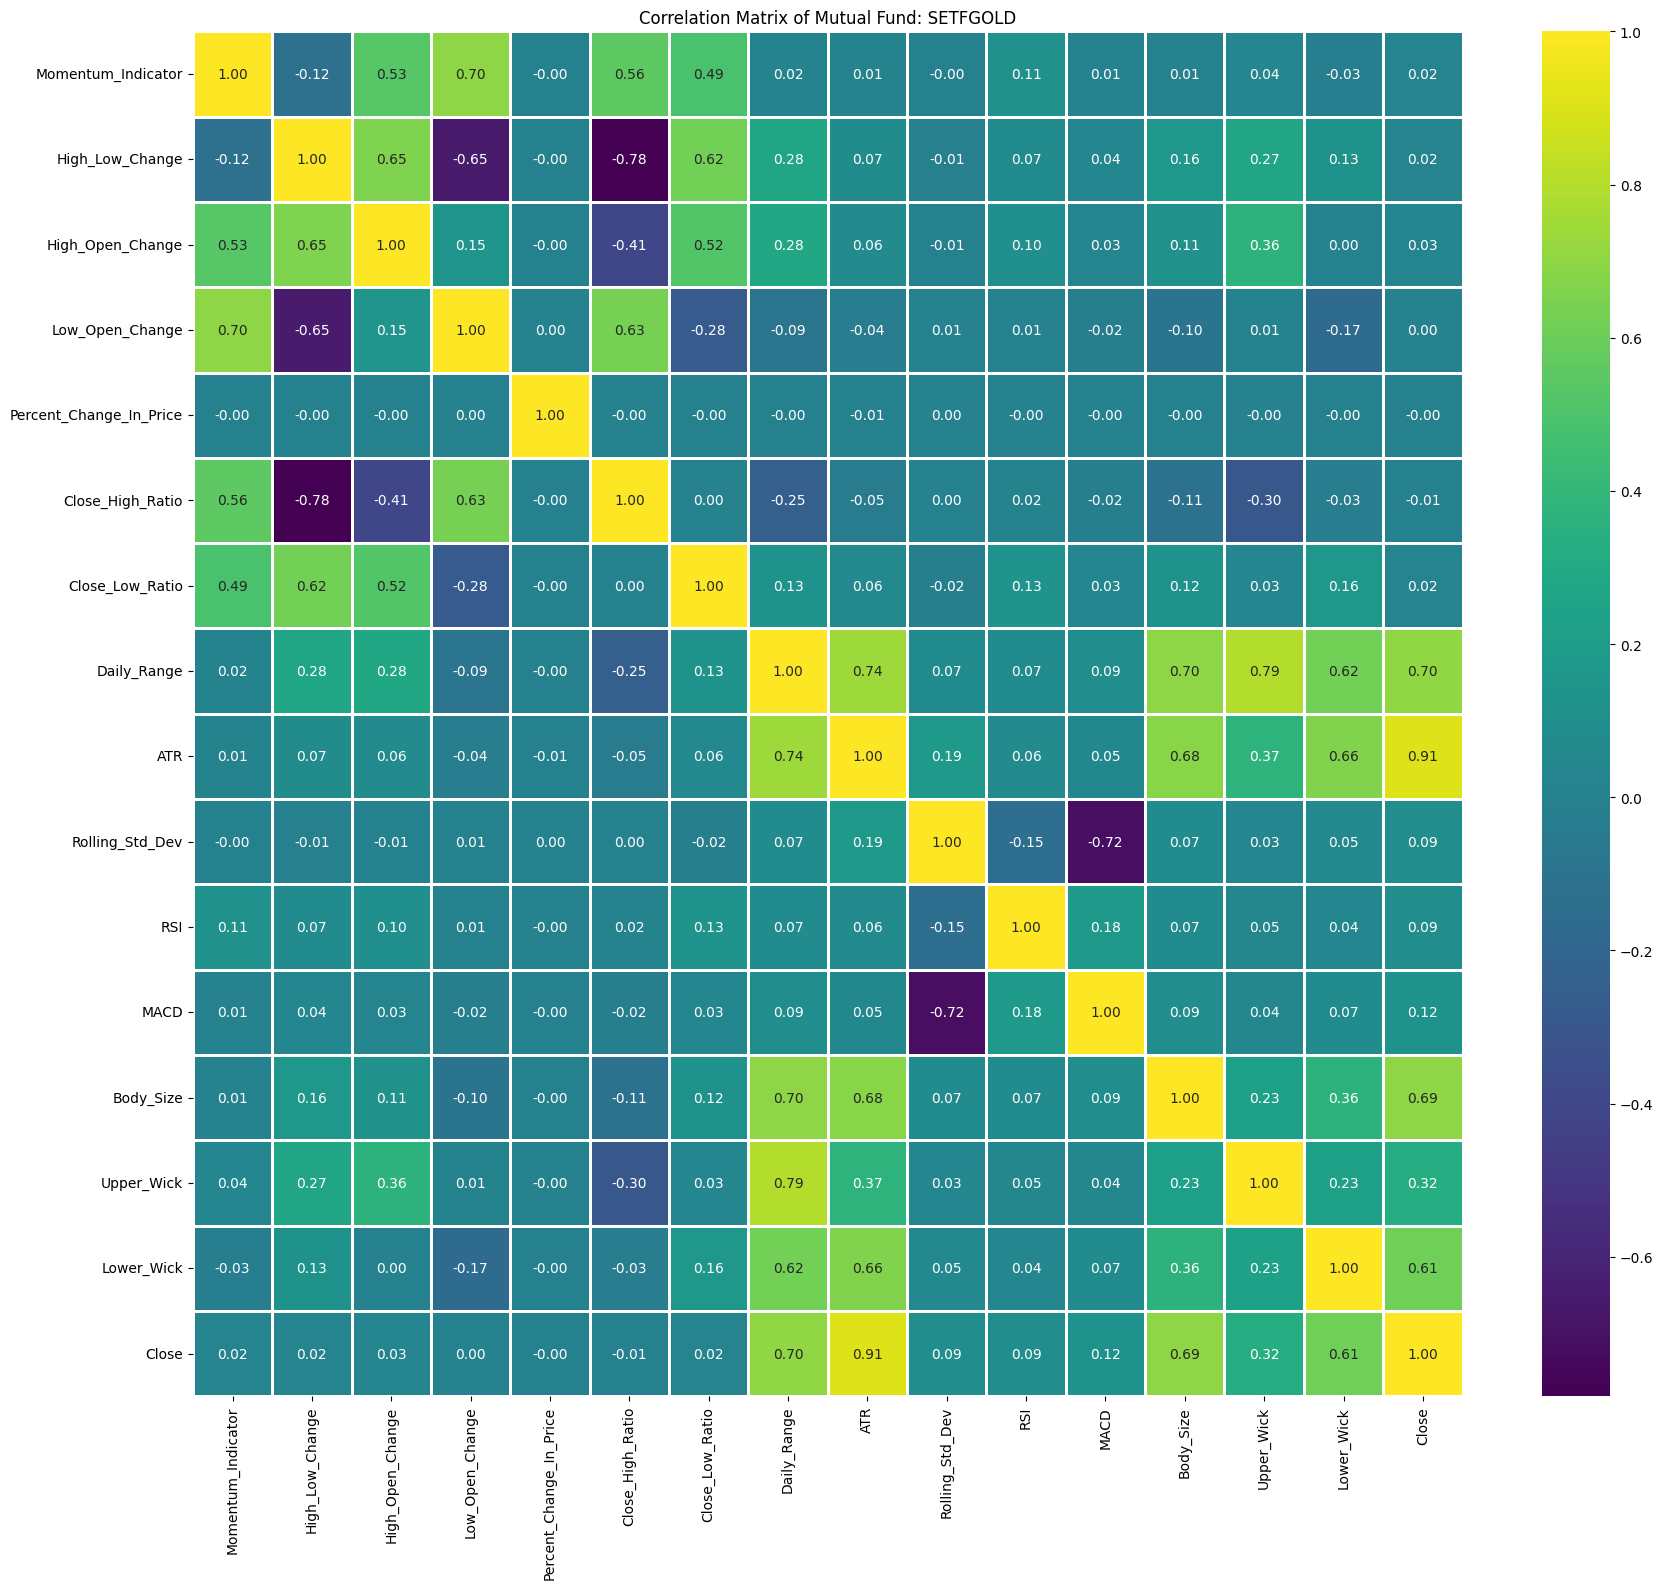


Processing Mutual Fund: BSLGOLDETF
R-squared: -2.079659325560875

Mutual Fund: BSLGOLDETF - Feature Importances:


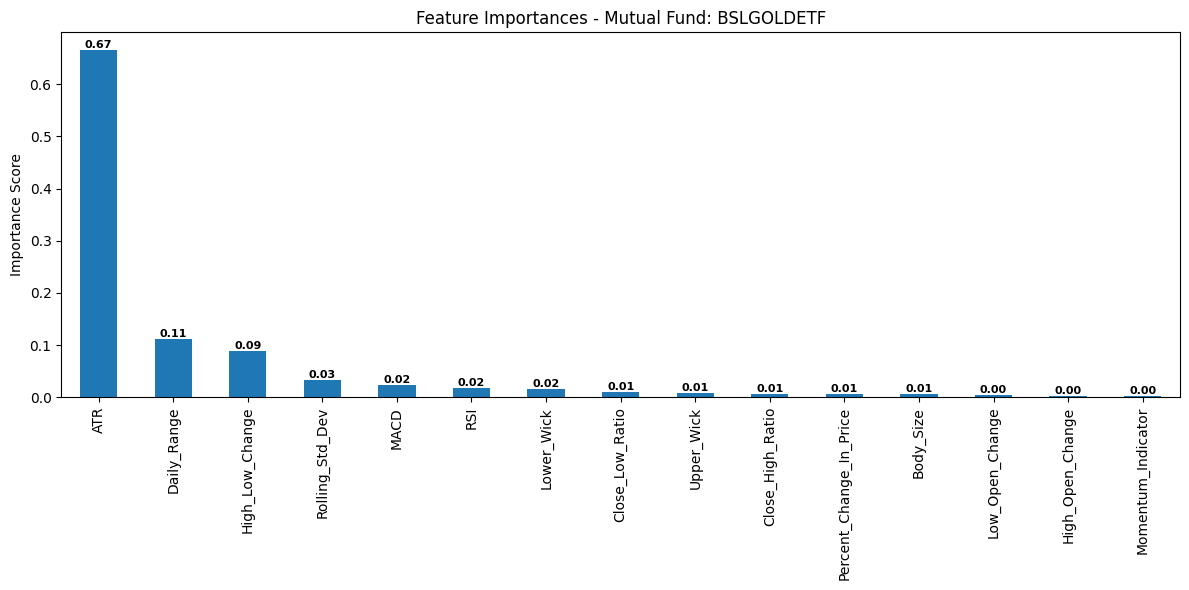

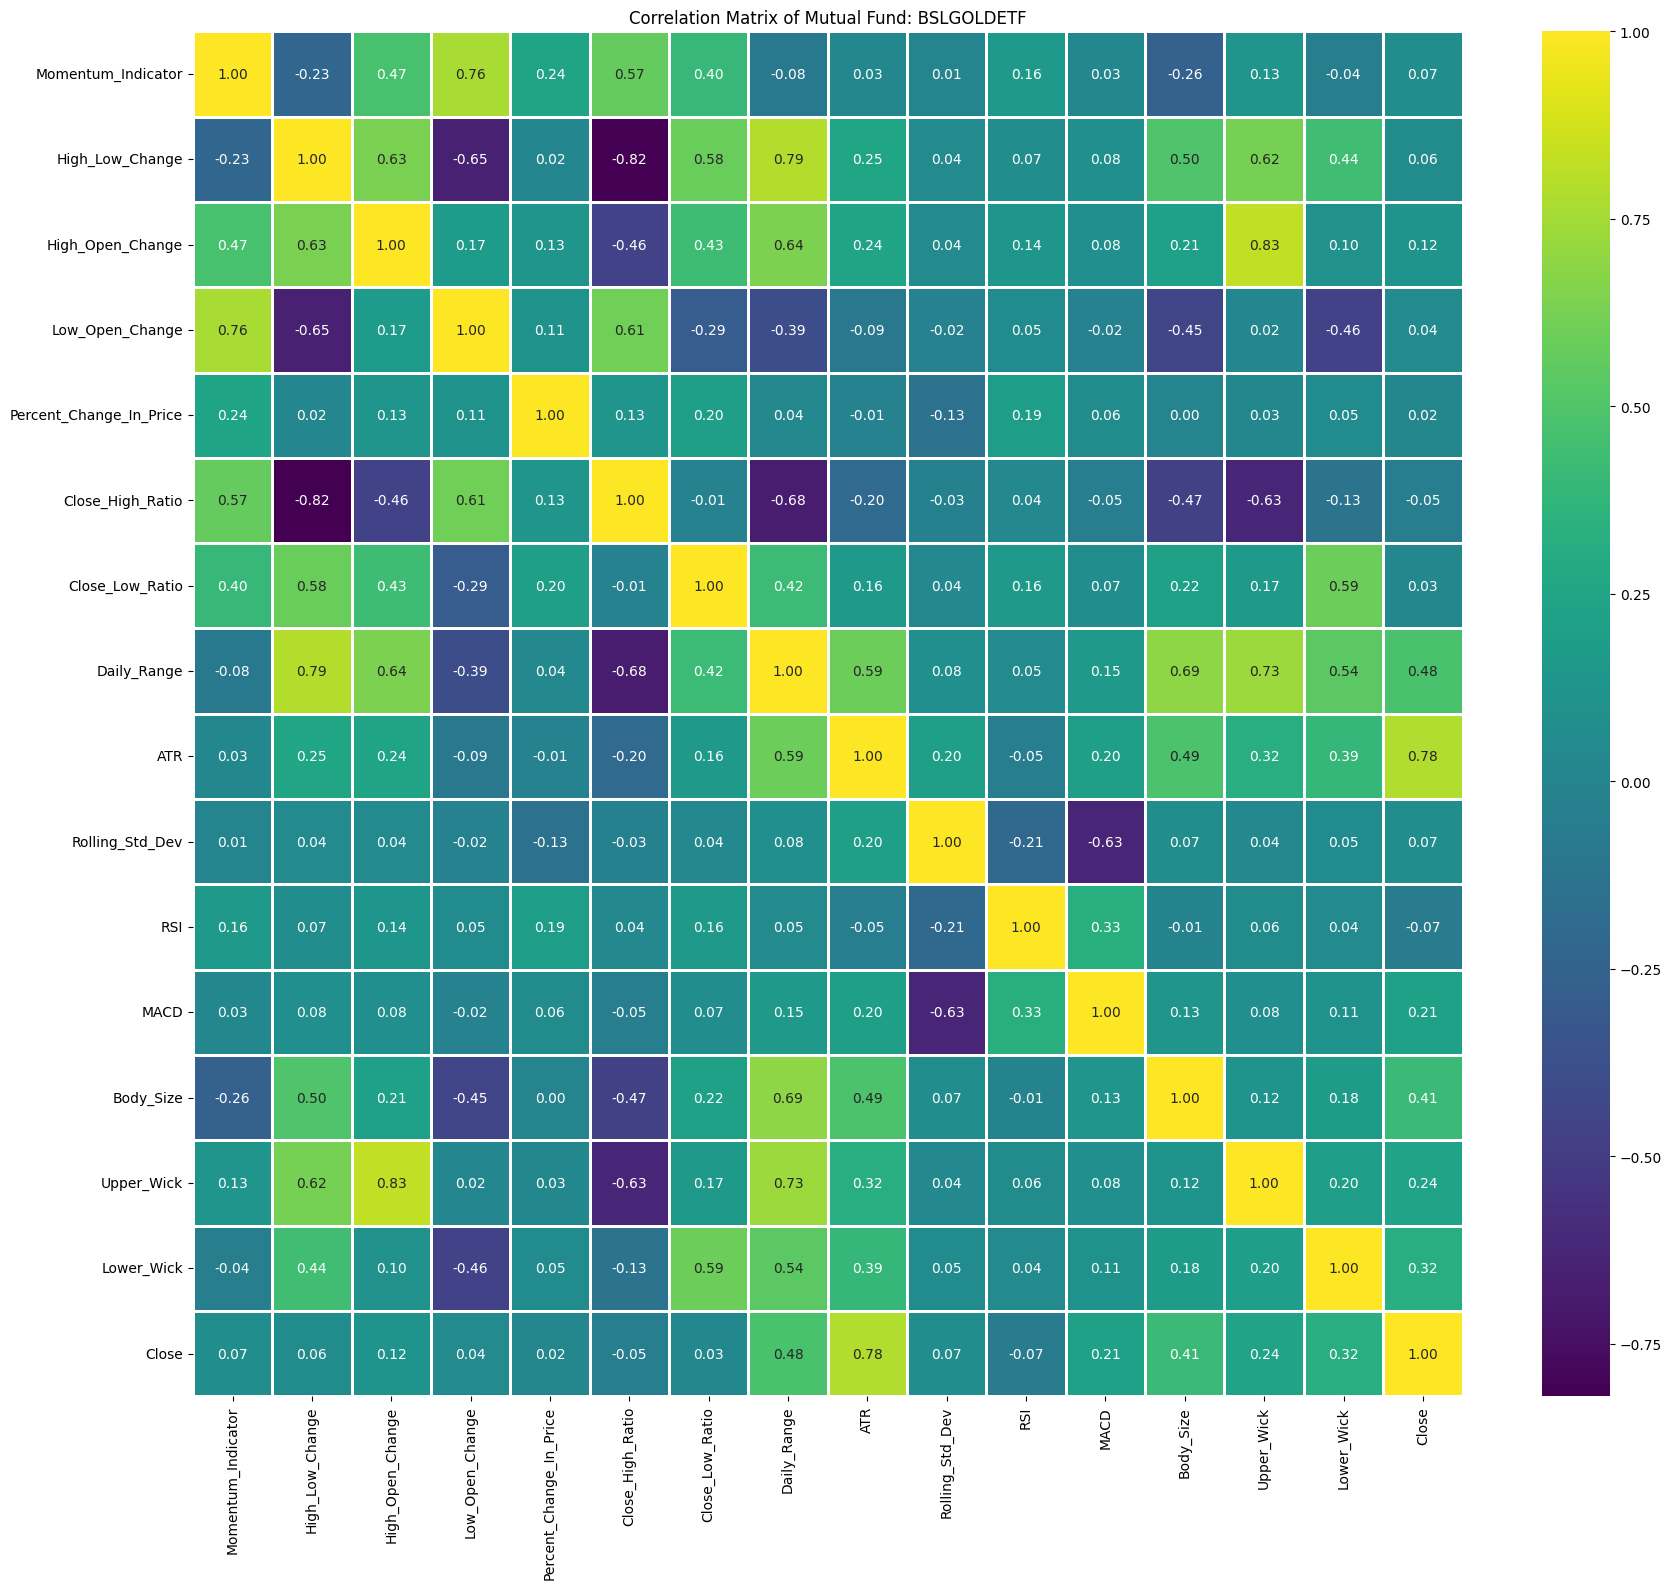

In [40]:
mutual_funds_excel_file = '../Data/Mutual_Funds_Data.xlsx'
all_mutual_funds = pd.read_excel(mutual_funds_excel_file, sheet_name=None)

print("### Feature Selection for Each Mutual Fund ###")
for sheet_name, df in all_mutual_funds.items():
    asset_identifier = f"Mutual Fund: {sheet_name}"
    print(f"\nProcessing {asset_identifier}")
    feat_imp = select_features_rf(df, asset_name=asset_identifier)
    selected_features = filter_features(feat_imp, threshold=0.01)
    mutual_funds_features_dict[sheet_name] = selected_features

### Feature Selection for Gold Bonds

### Feature Selection for Gold Bonds ###
R-squared: -10.781231039125698

Gold Bonds - Feature Importances:


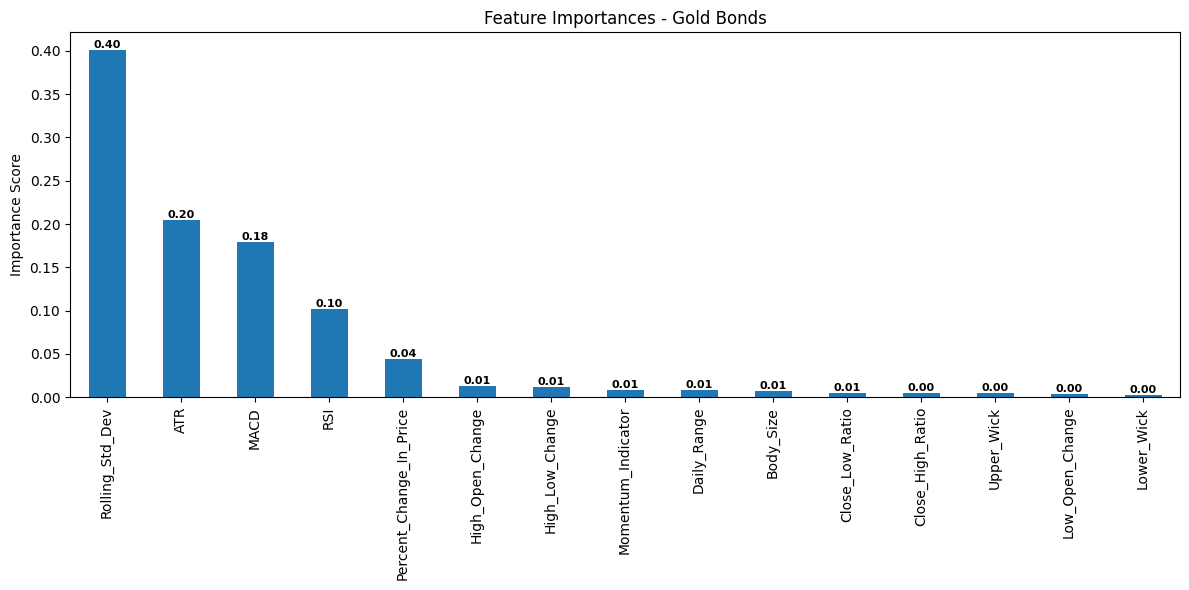

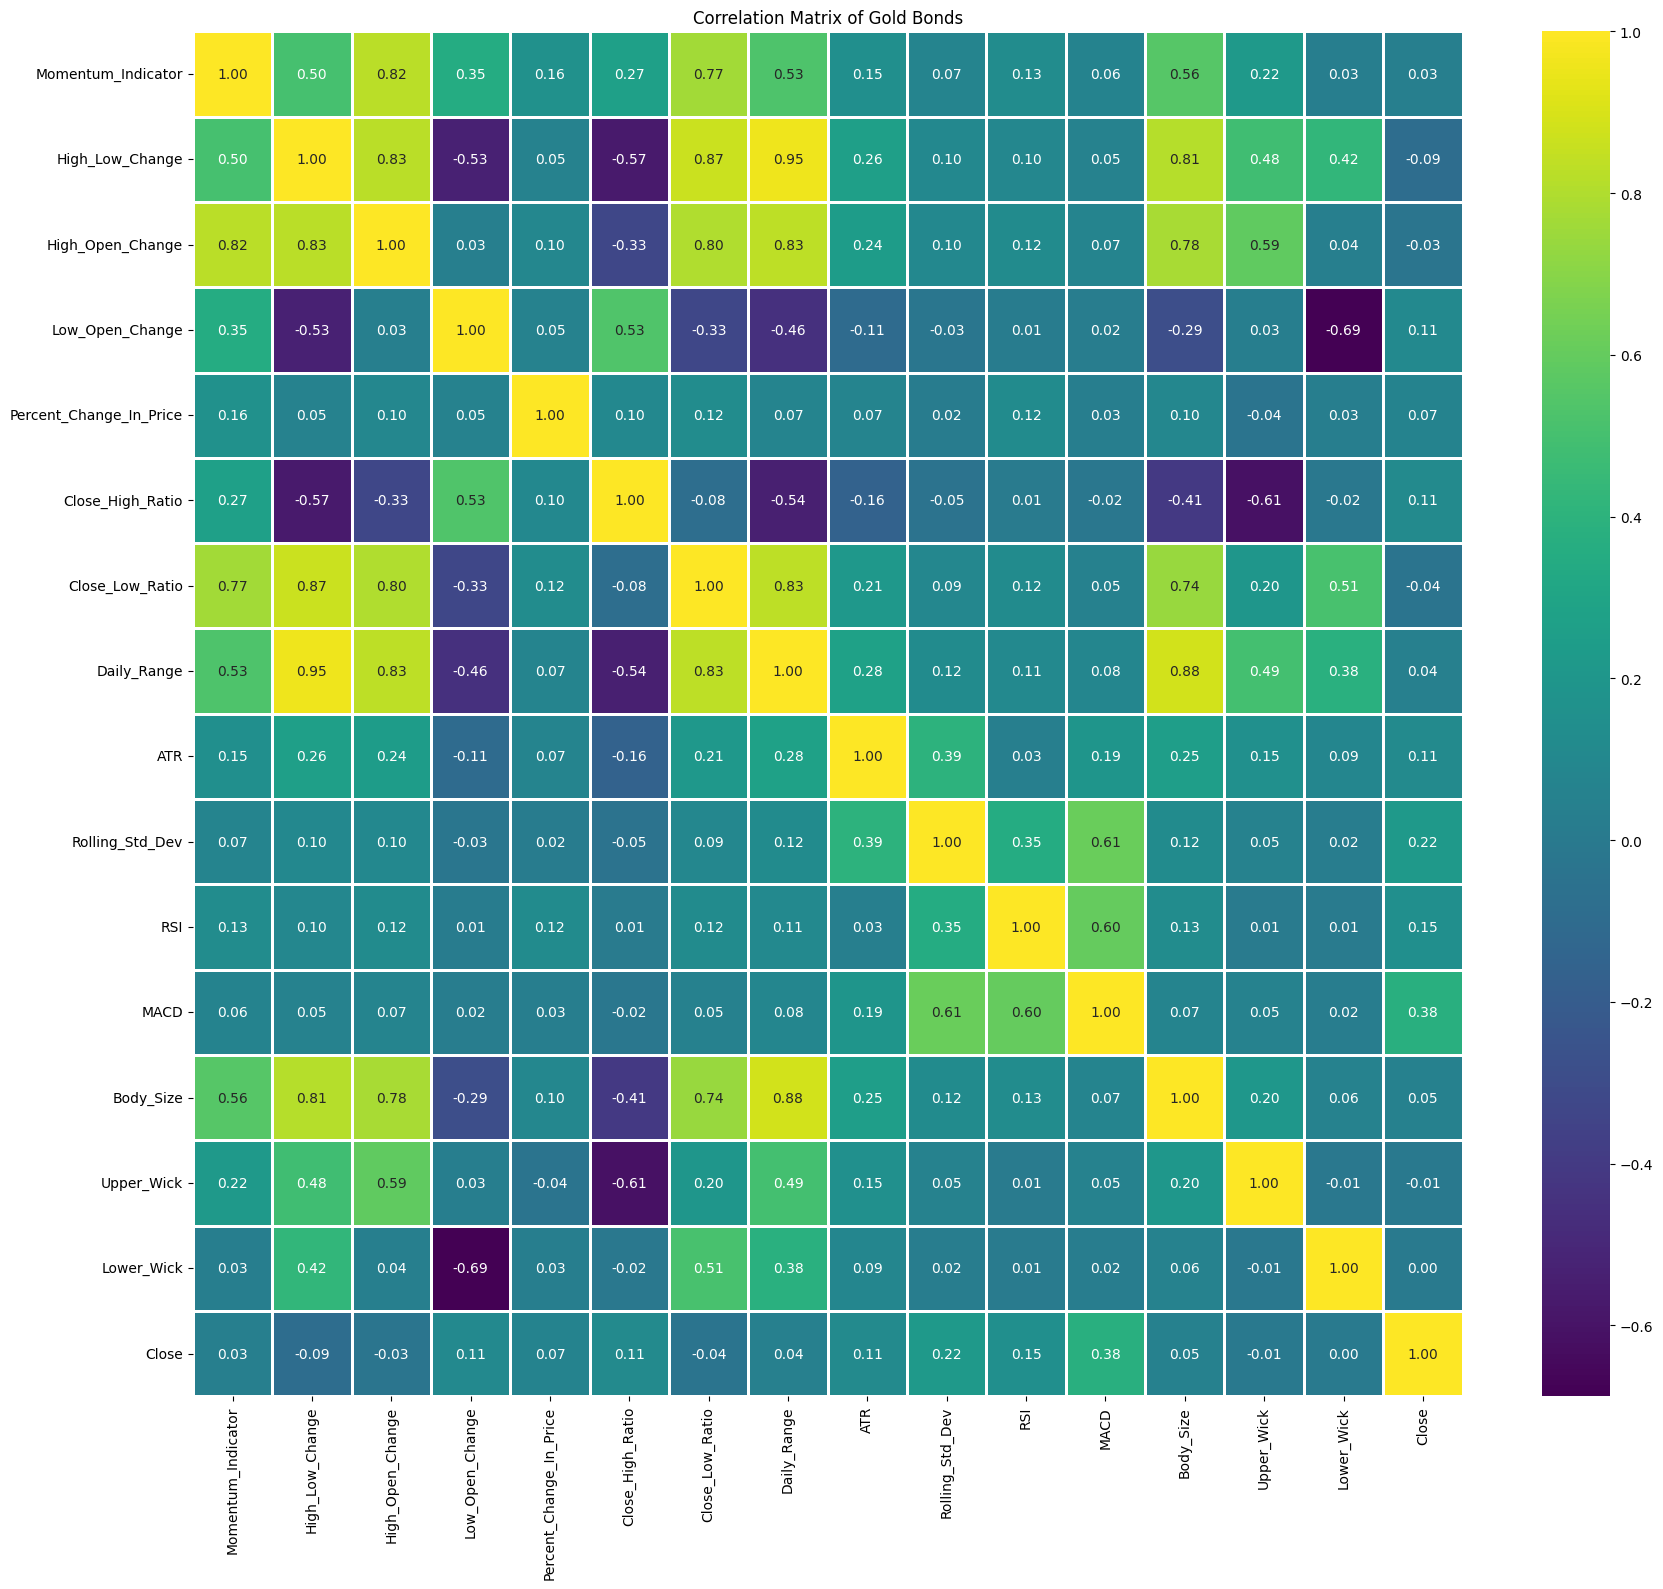

In [41]:
gold_bonds_file = '../Data/Gold_Bond_Data.xlsx'
gold_df = pd.read_excel(gold_bonds_file)

print("### Feature Selection for Gold Bonds ###")
feat_imp_gold = select_features_rf(gold_df, asset_name="Gold Bonds")
selected_features_gold = filter_features(feat_imp_gold, threshold=0.01)
gold_bonds_features_dict["Gold Bonds"] = selected_features_gold

In [42]:
index_features_dict

{'NSEI': ['Daily_Range', 'High_Low_Change', 'ATR', 'MACD'],
 'NSEBANK': ['ATR', 'High_Low_Change', 'Daily_Range', 'MACD'],
 'CNXIT': ['ATR', 'High_Low_Change', 'MACD', 'Daily_Range'],
 'BSESN': ['ATR', 'High_Low_Change', 'Daily_Range', 'MACD'],
 'NIFTY_MIDCAP_100': ['ATR', 'High_Low_Change', 'Daily_Range', 'MACD'],
 'CNXPSUBANK': ['ATR',
  'Daily_Range',
  'High_Low_Change',
  'MACD',
  'Rolling_Std_Dev'],
 'CNXAUTO': ['ATR', 'High_Low_Change', 'Daily_Range', 'MACD'],
 'NIFTY_FIN_SERVICE': ['ATR', 'High_Low_Change', 'Daily_Range', 'MACD']}

In [43]:
mutual_funds_features_dict

{'0P00005WL6': ['MACD', 'Rolling_Std_Dev', 'RSI', 'Percent_Change_In_Price'],
 'UTINEXT50': ['ATR',
  'Close_Low_Ratio',
  'High_Low_Change',
  'MACD',
  'Daily_Range',
  'Rolling_Std_Dev',
  'Upper_Wick',
  'Percent_Change_In_Price',
  'RSI',
  'Low_Open_Change',
  'Close_High_Ratio',
  'Body_Size',
  'High_Open_Change'],
 '0P0000MLHH': ['Rolling_Std_Dev', 'MACD', 'RSI', 'Percent_Change_In_Price'],
 '0P0000KV39': ['MACD', 'Rolling_Std_Dev', 'RSI', 'Percent_Change_In_Price'],
 '0P00009J3K': ['MACD', 'Rolling_Std_Dev', 'RSI', 'Percent_Change_In_Price'],
 '0P0001BAB5': ['MACD', 'Rolling_Std_Dev', 'RSI', 'Percent_Change_In_Price'],
 '0P0001EI18': ['MACD', 'Rolling_Std_Dev', 'RSI', 'Percent_Change_In_Price'],
 '0P0001BA1R': ['MACD', 'Rolling_Std_Dev', 'RSI', 'Percent_Change_In_Price'],
 '0P00005WEY': ['MACD', 'Rolling_Std_Dev', 'RSI', 'Percent_Change_In_Price'],
 '0P0000XUXL': ['RSI', 'MACD', 'Rolling_Std_Dev', 'Percent_Change_In_Price'],
 '0P0000XUYZ': ['MACD', 'RSI', 'Rolling_Std_Dev', '

In [44]:
gold_bonds_features_dict

{'Gold Bonds': ['Rolling_Std_Dev',
  'ATR',
  'MACD',
  'RSI',
  'Percent_Change_In_Price',
  'High_Open_Change',
  'High_Low_Change']}

### Re-running the model after the feature selection

### Feature Selection for Each Index ###

Processing Index: NSEI
R-squared: -3.1867881917900798

Index: NSEI - Feature Importances:
Daily_Range        0.439364
High_Low_Change    0.435701
ATR                0.104267
MACD               0.020668
dtype: float64


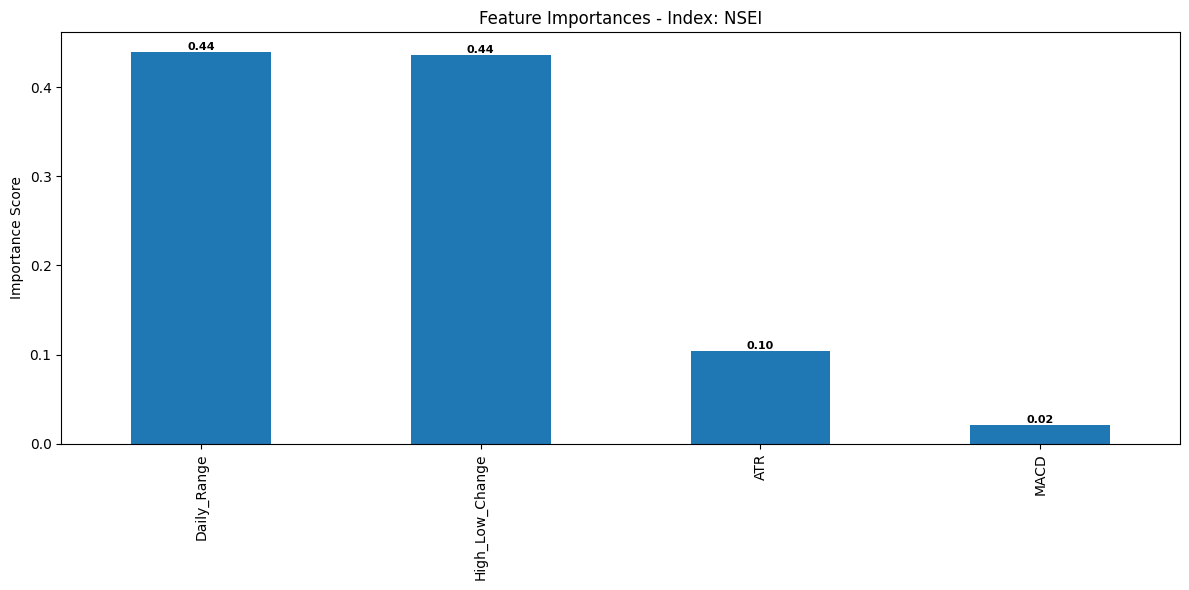

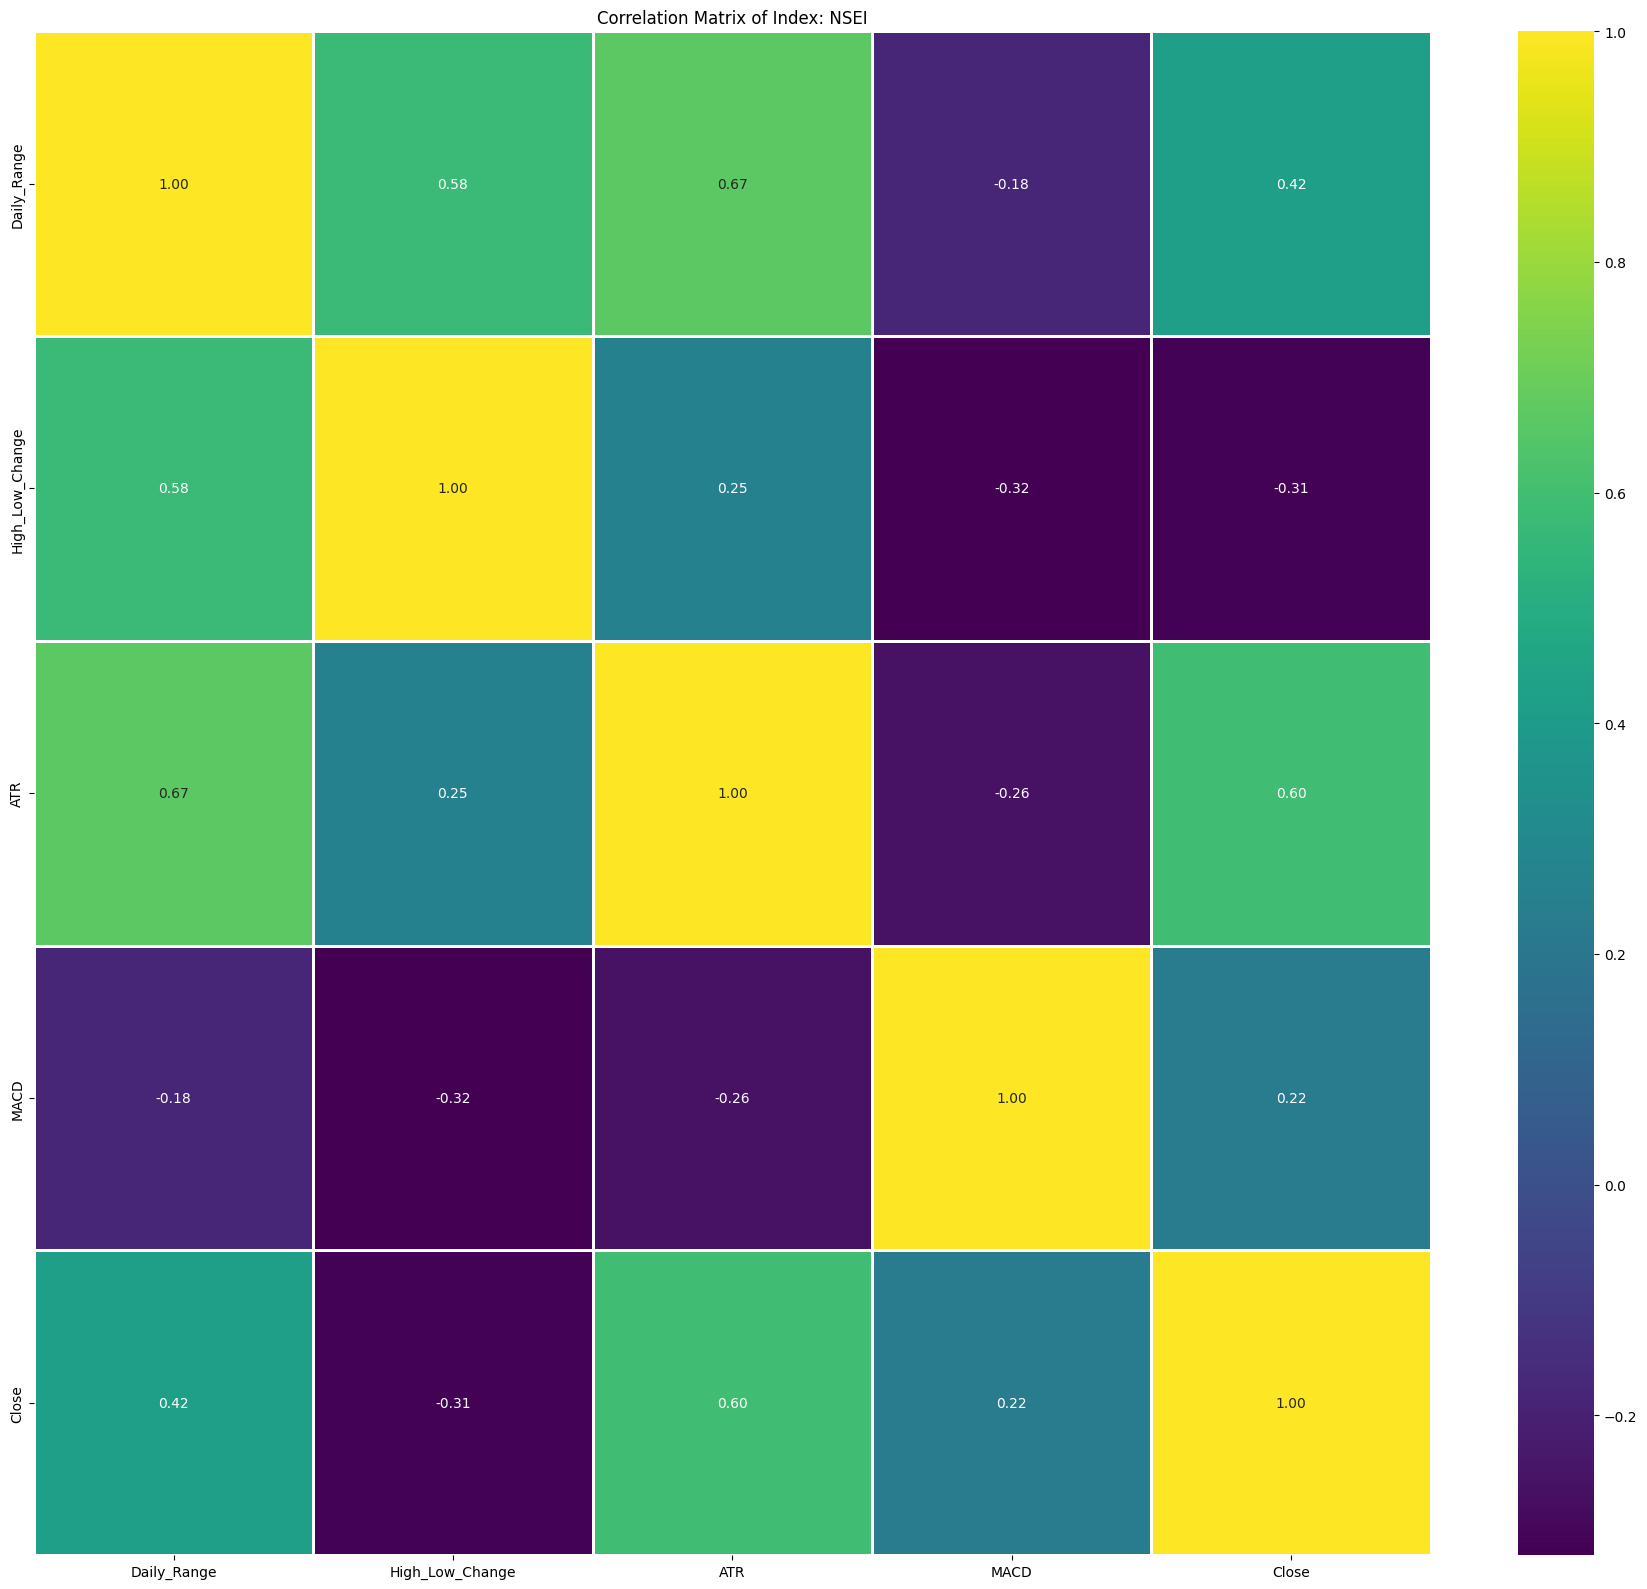


Processing Index: NSEBANK
R-squared: -2.9527941302195853

Index: NSEBANK - Feature Importances:
ATR                0.413346
High_Low_Change    0.319092
Daily_Range        0.236379
MACD               0.031183
dtype: float64


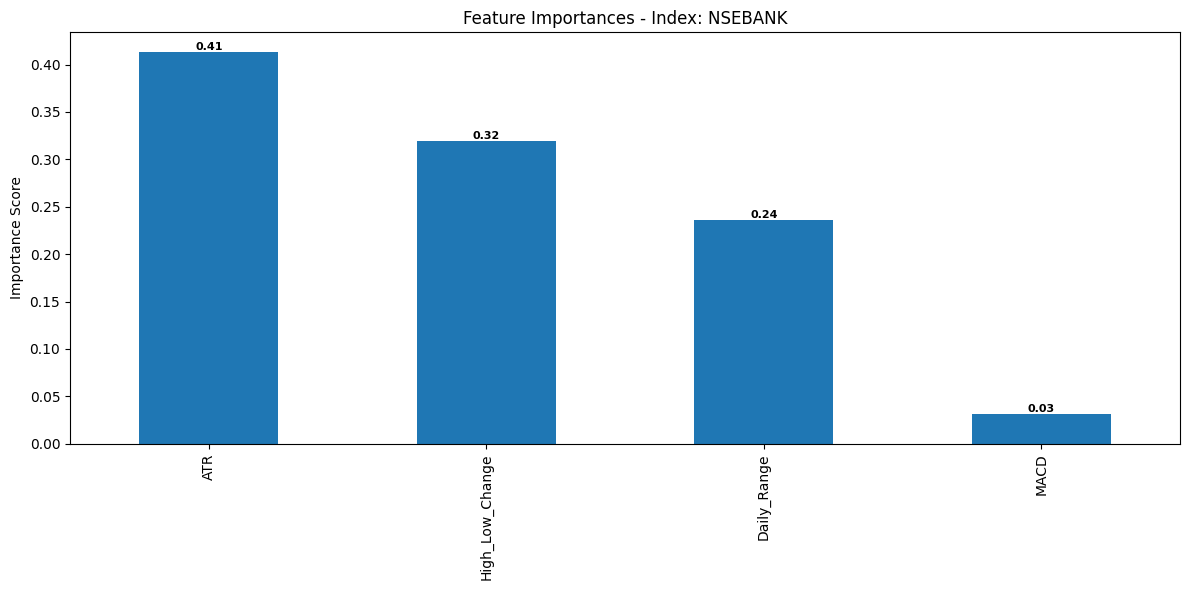

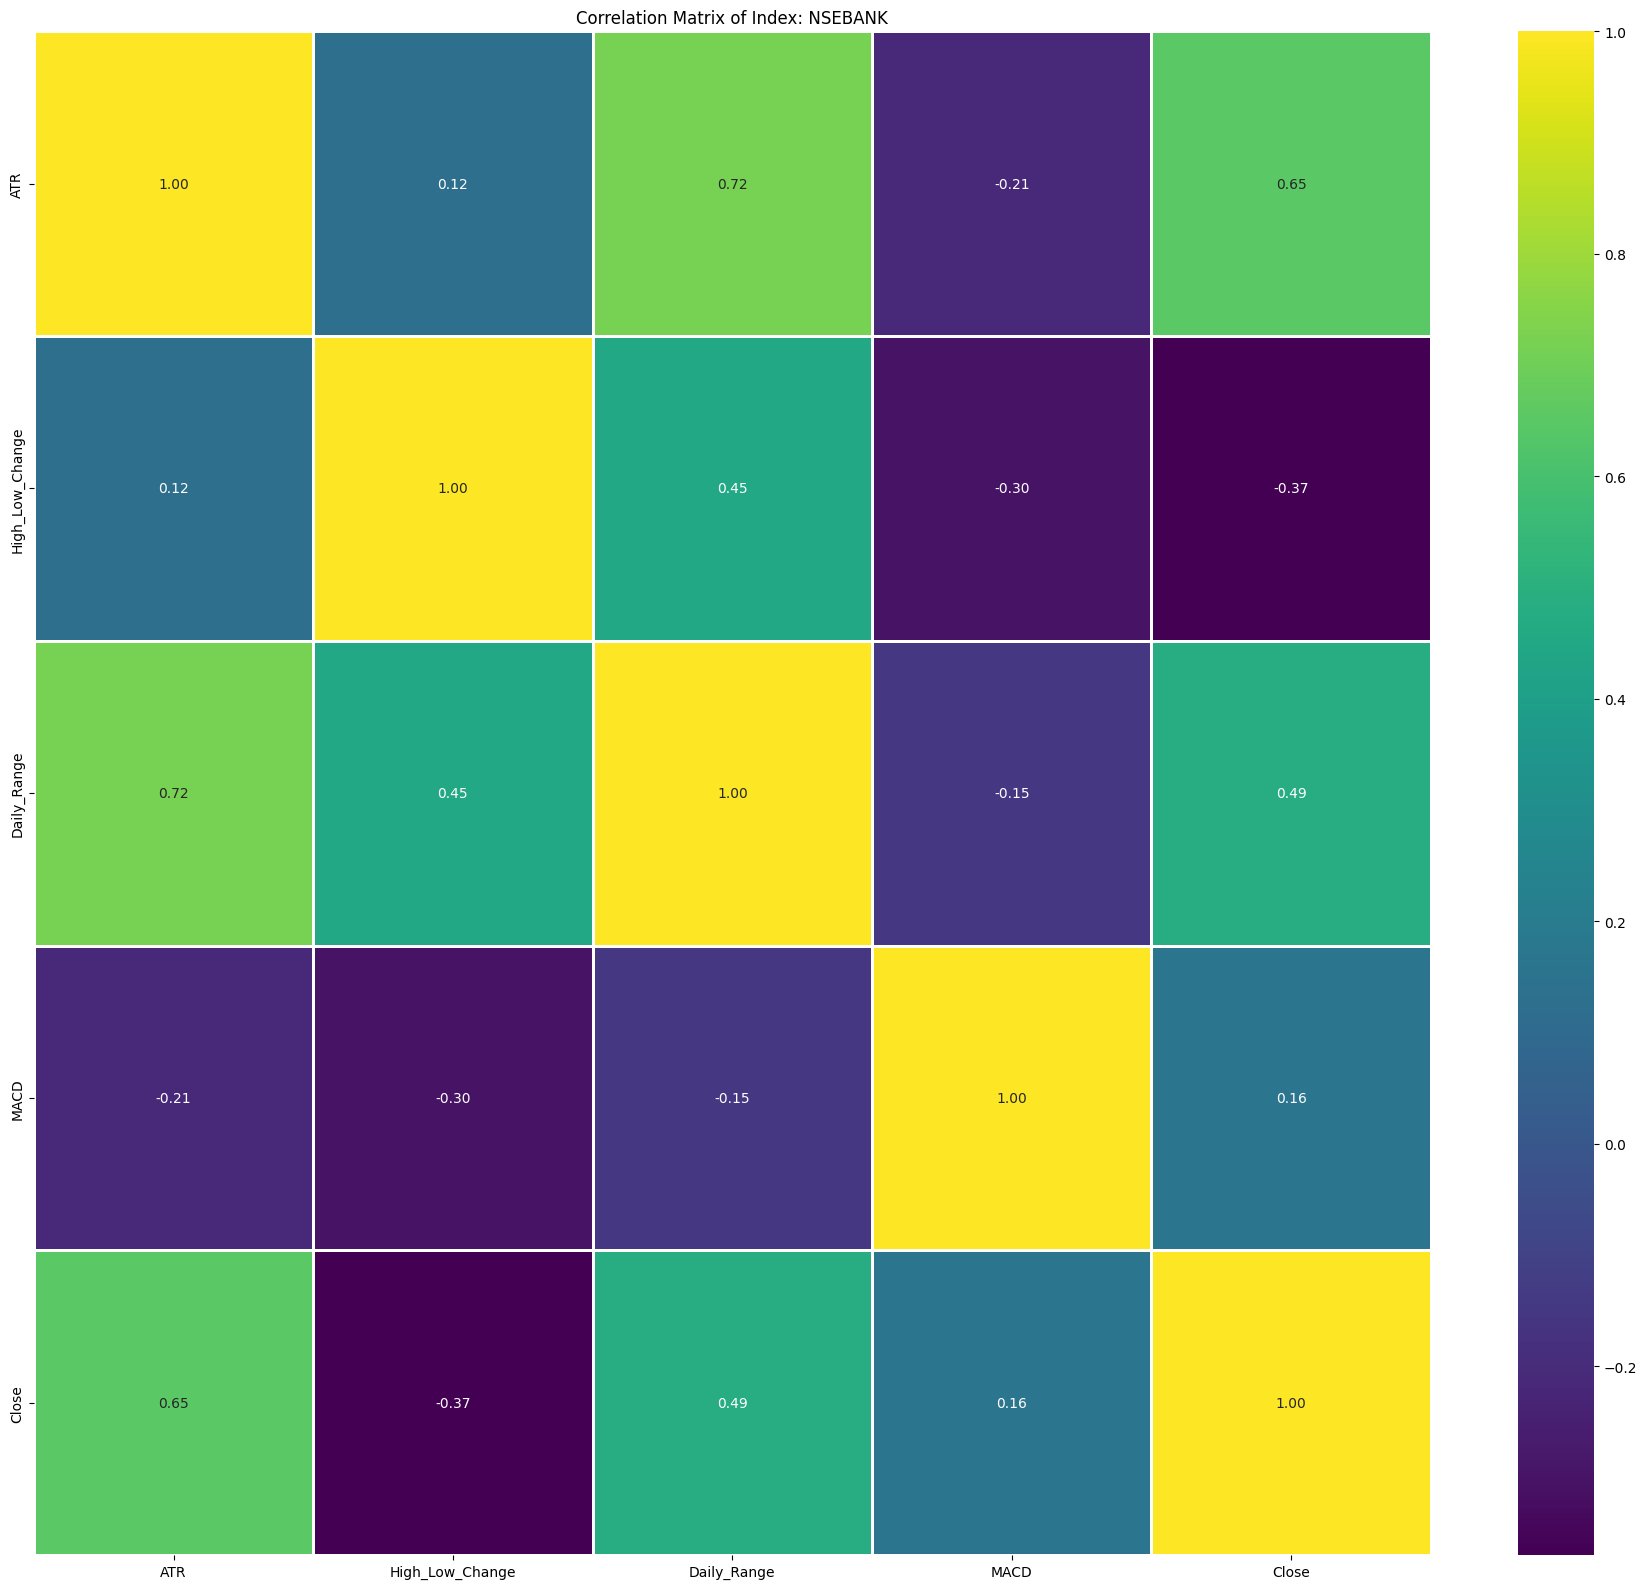


Processing Index: CNXIT
R-squared: -4.376697728414015

Index: CNXIT - Feature Importances:
ATR                0.762102
High_Low_Change    0.092435
MACD               0.081020
Daily_Range        0.064443
dtype: float64


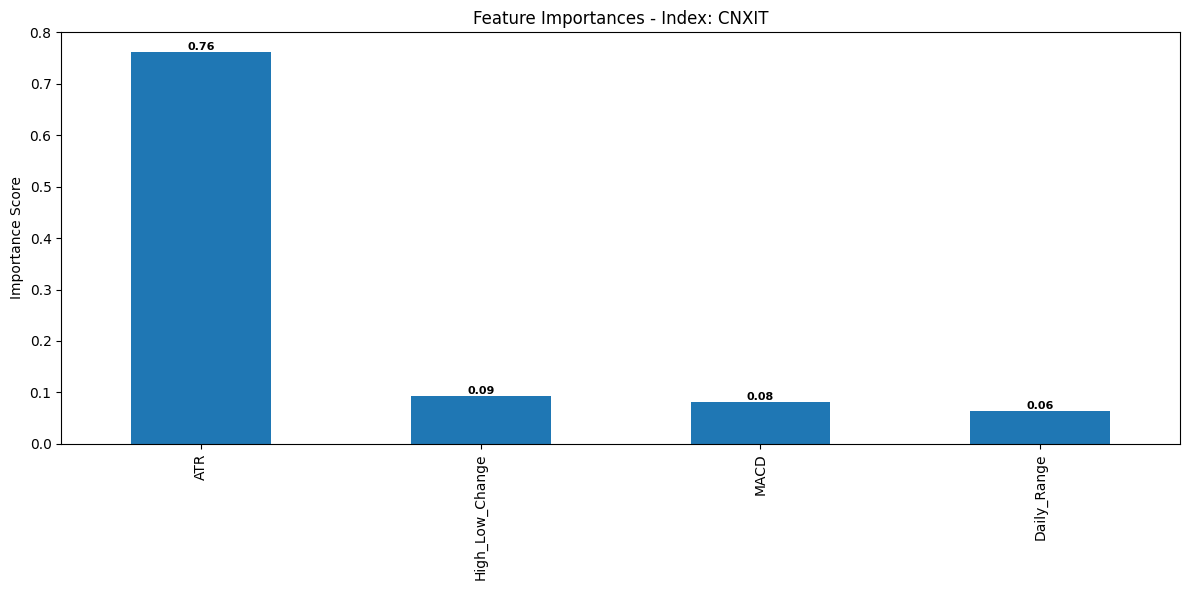

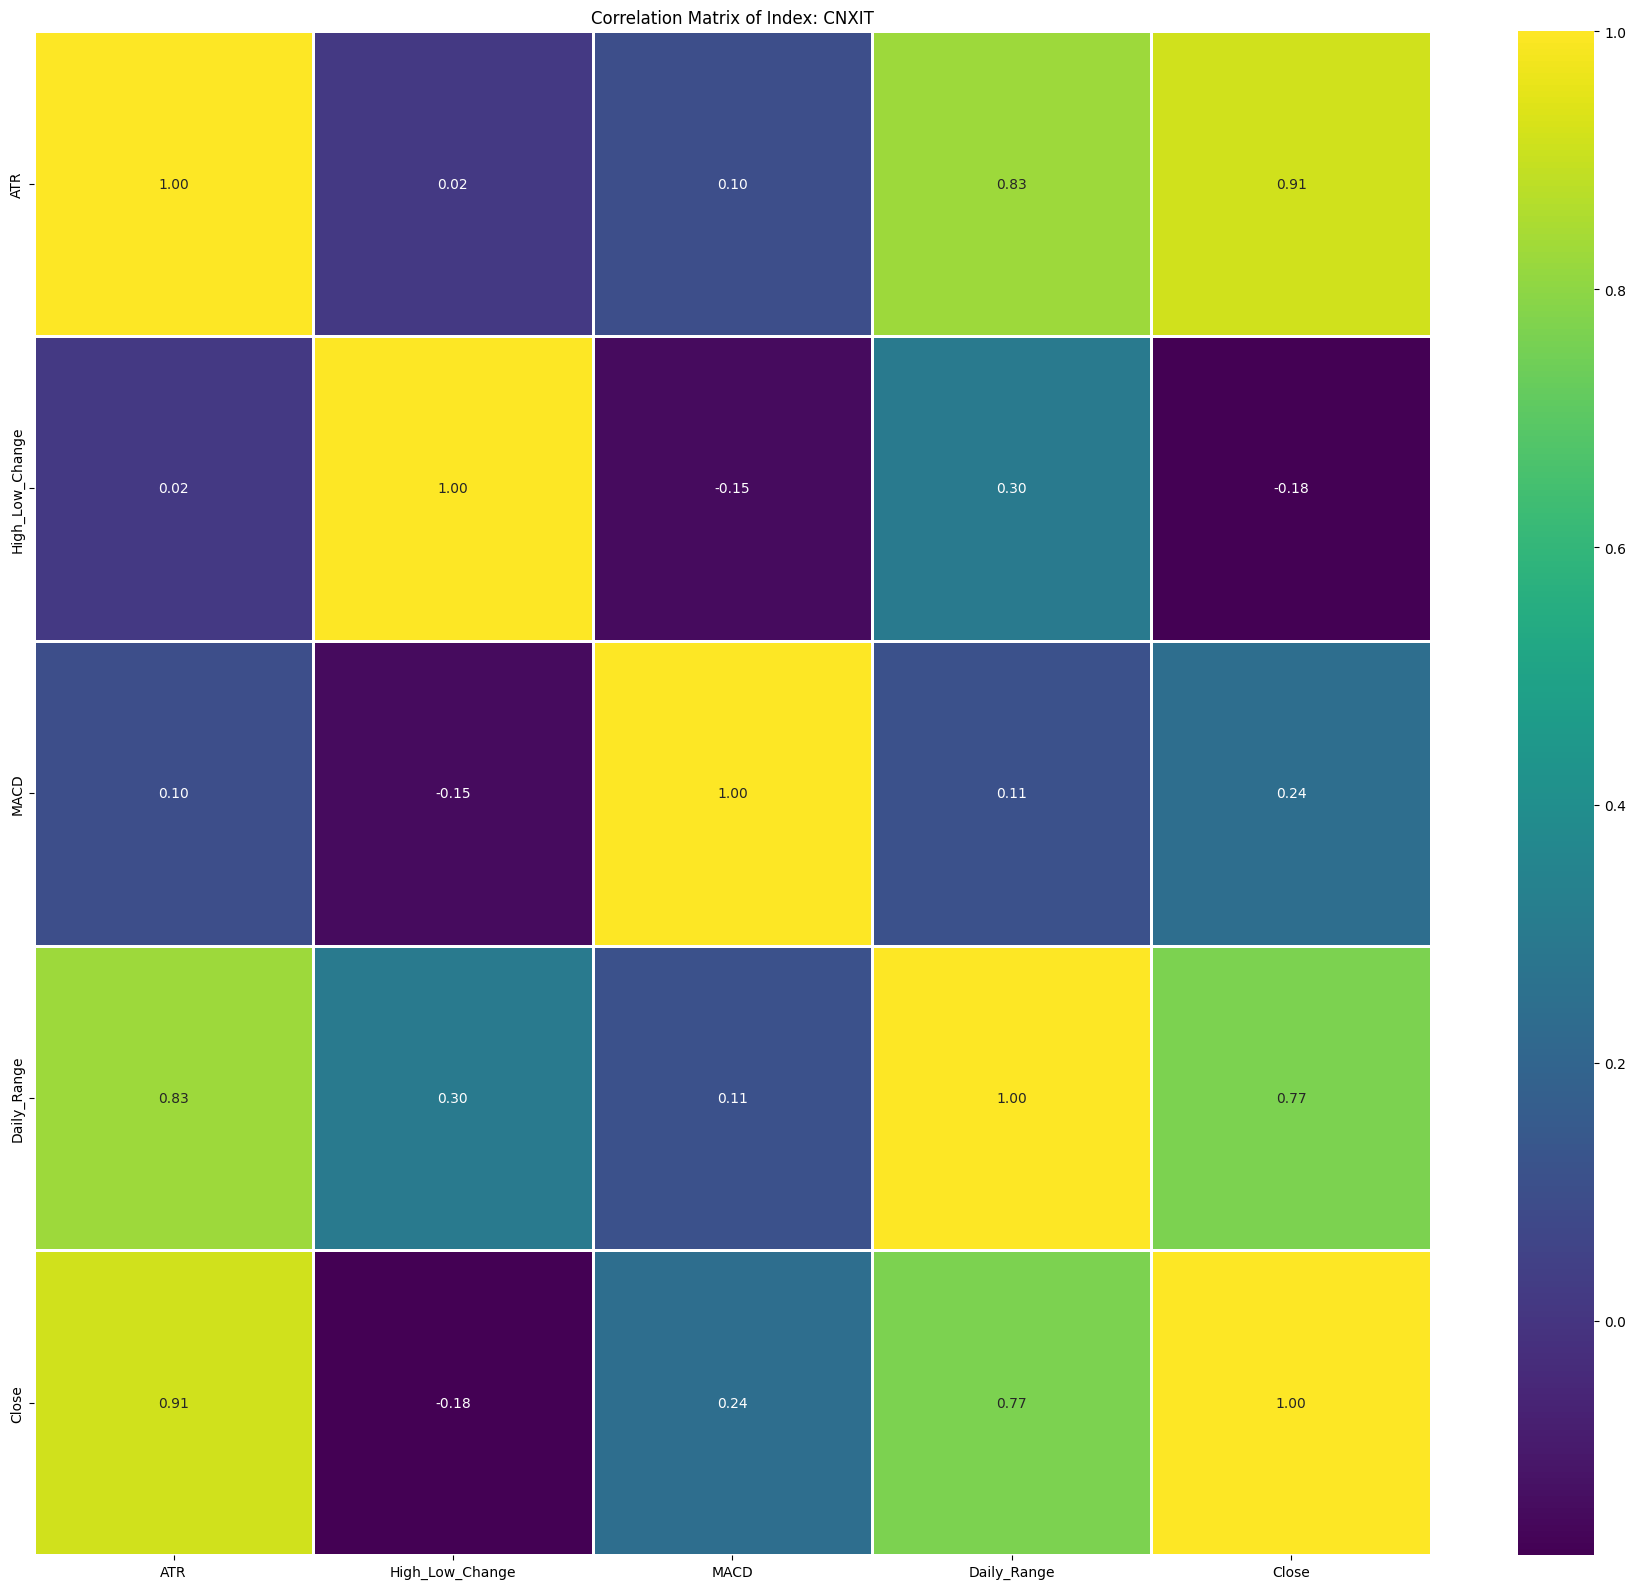


Processing Index: BSESN
R-squared: -1.7757109868107581

Index: BSESN - Feature Importances:
ATR                0.598352
High_Low_Change    0.217252
Daily_Range        0.171726
MACD               0.012670
dtype: float64


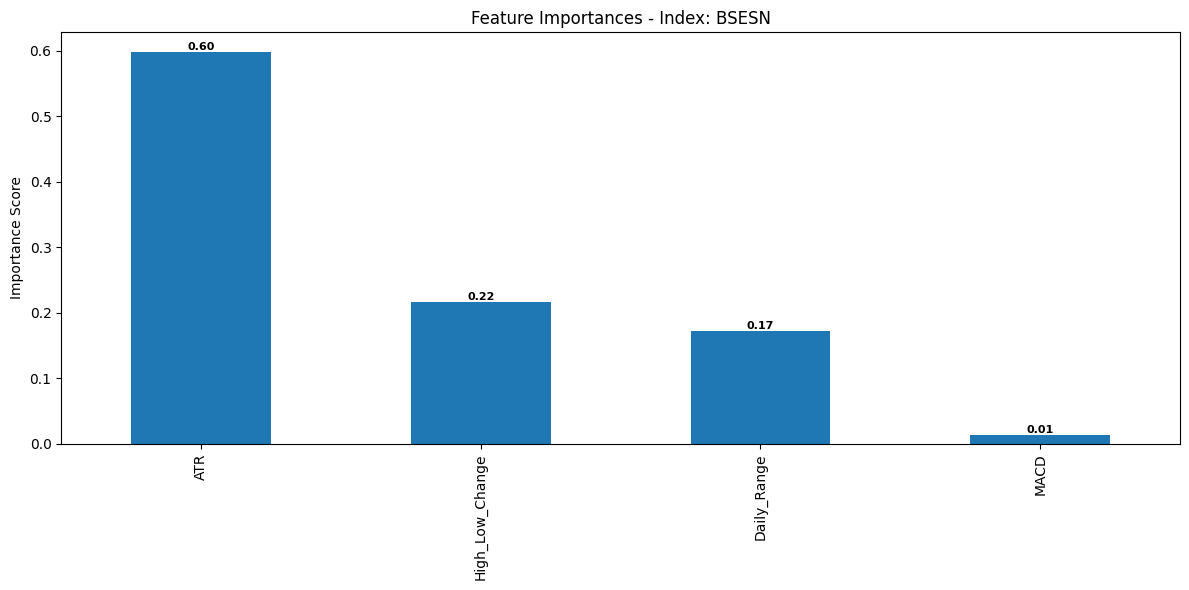

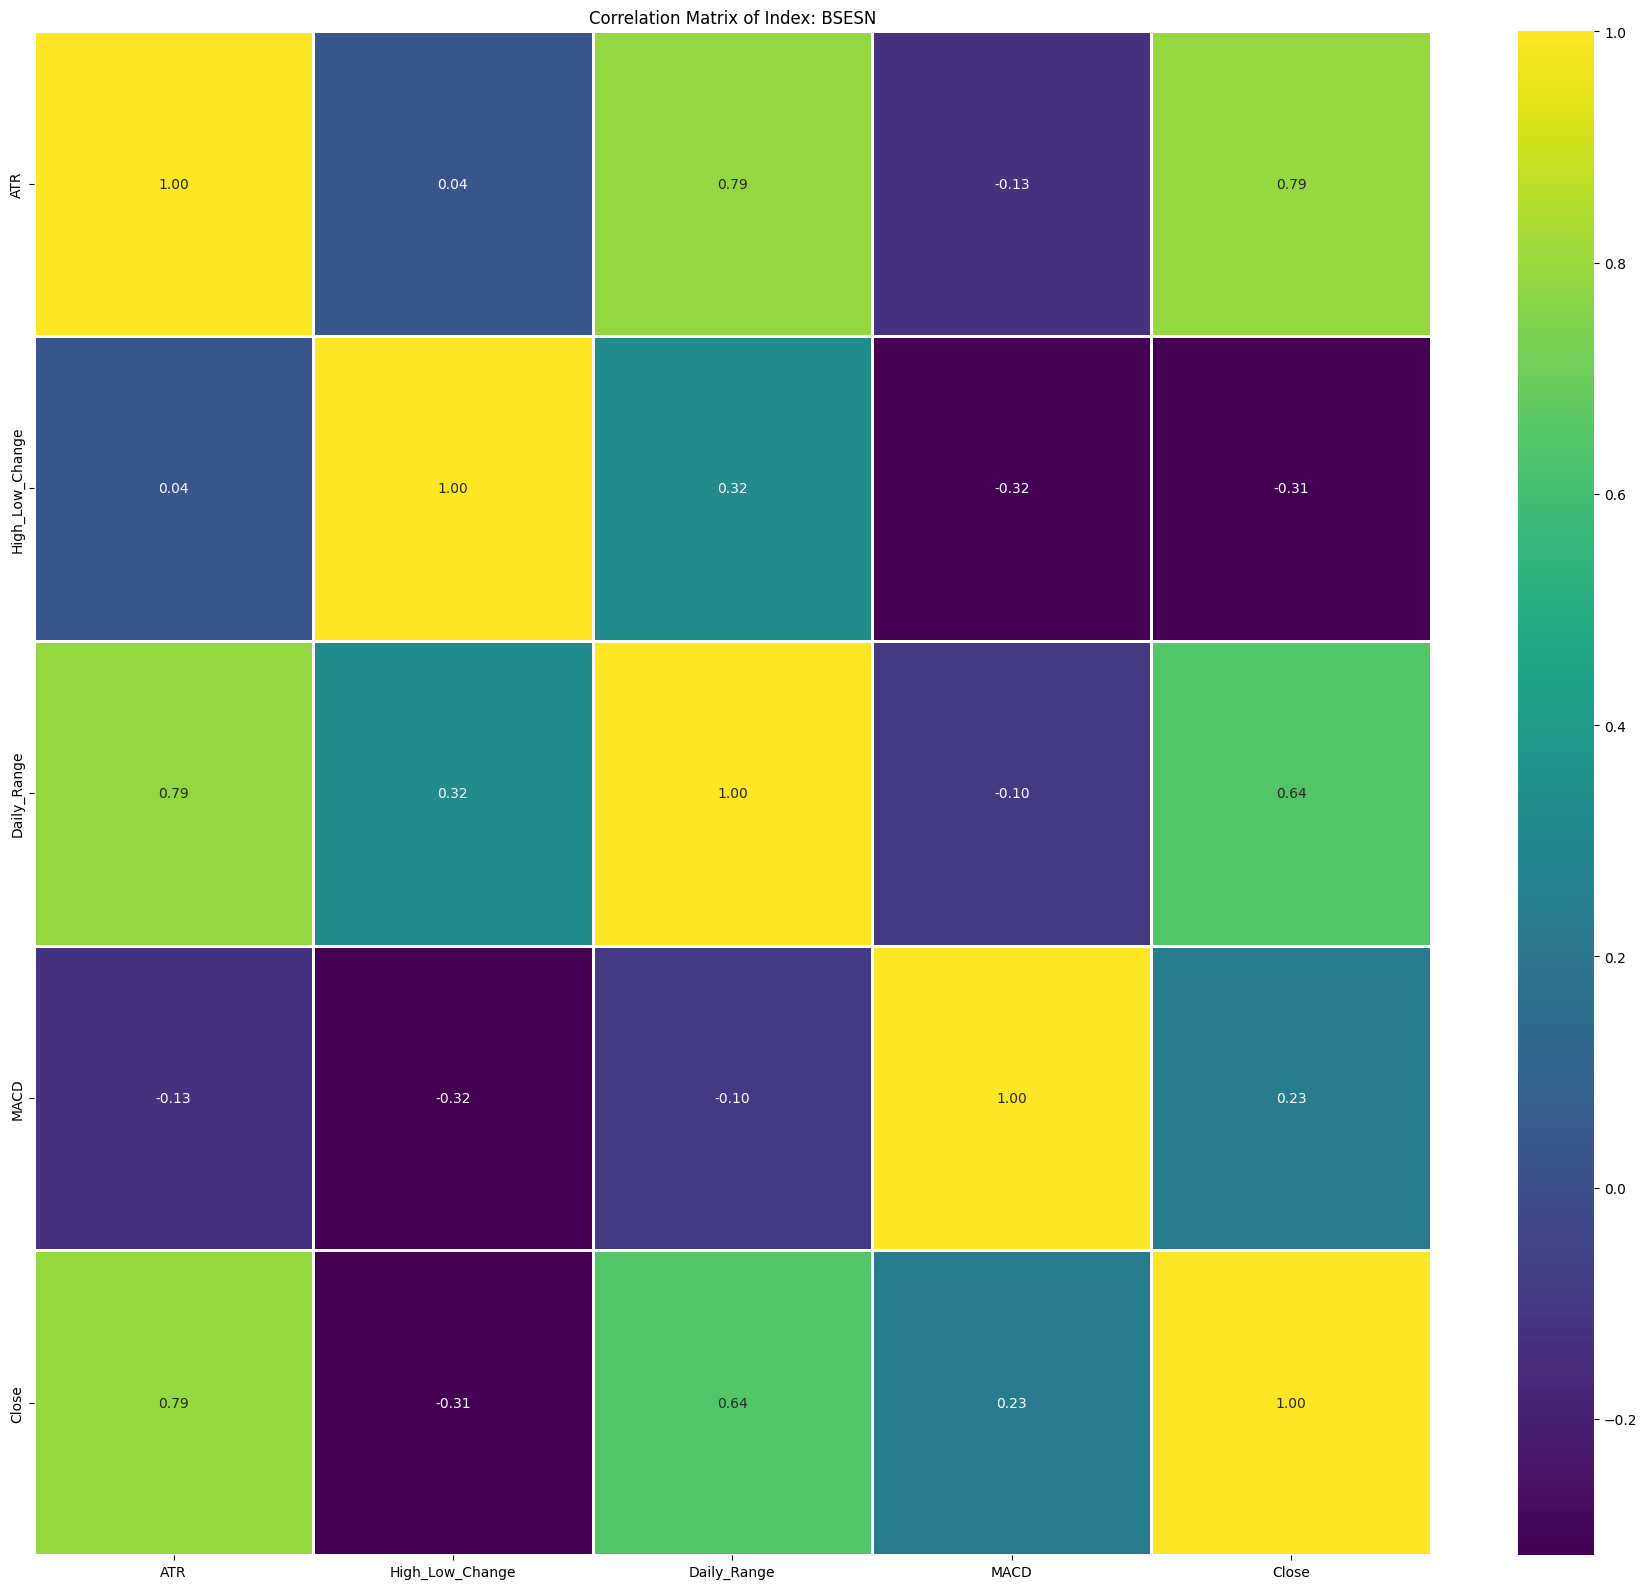


Processing Index: NIFTY_MIDCAP_100
R-squared: -2.153583732171811

Index: NIFTY_MIDCAP_100 - Feature Importances:
ATR                0.533557
High_Low_Change    0.215126
Daily_Range        0.192442
MACD               0.058876
dtype: float64


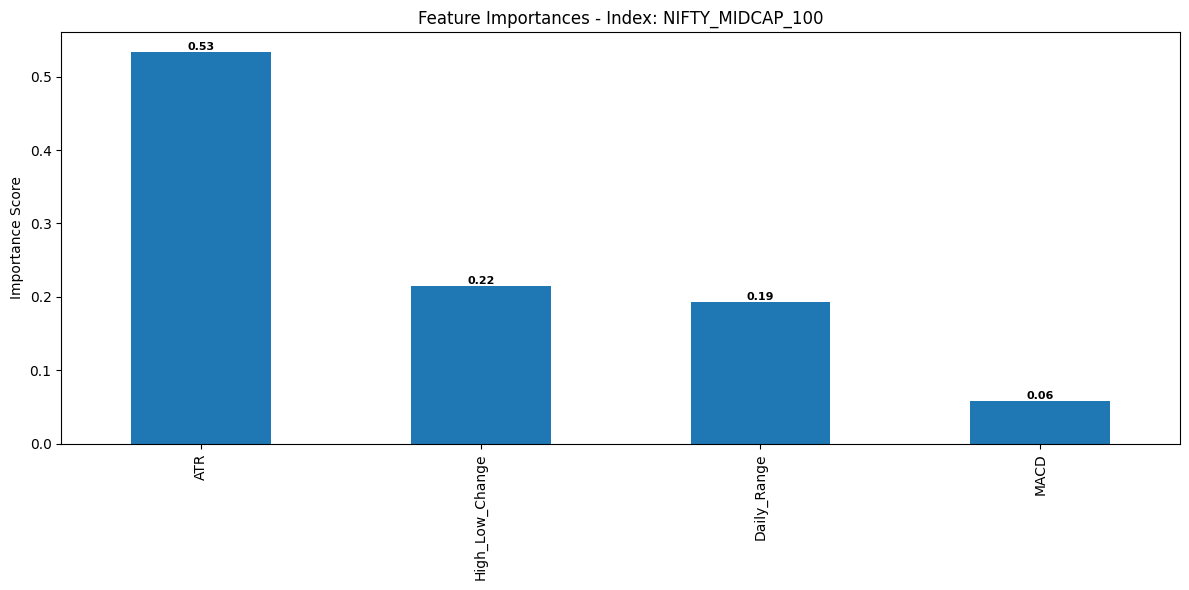

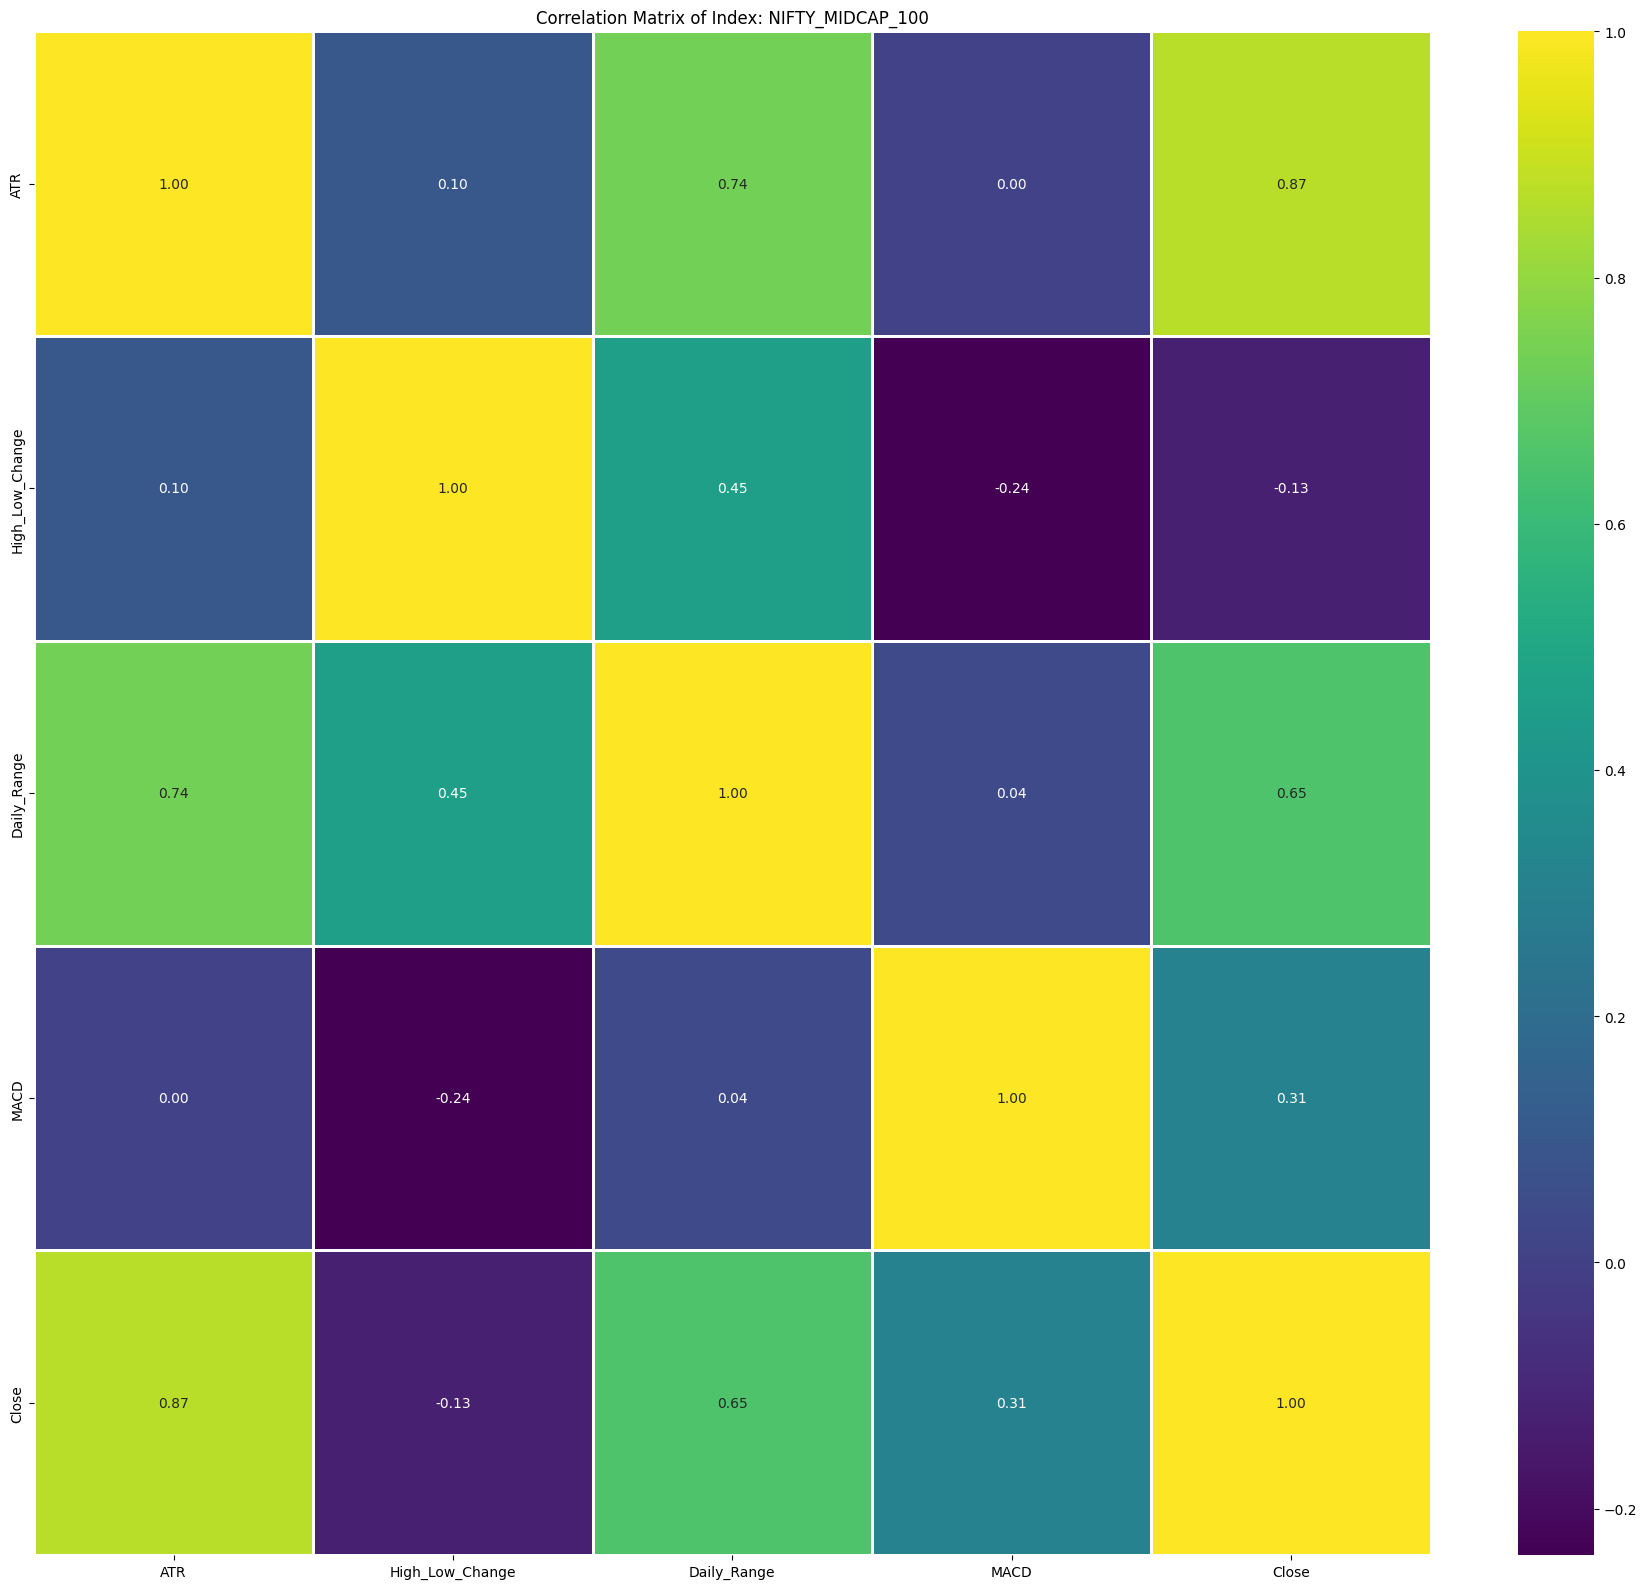


Processing Index: CNXPSUBANK
R-squared: -0.5923934345321125

Index: CNXPSUBANK - Feature Importances:
ATR                0.338420
Daily_Range        0.288884
High_Low_Change    0.268250
MACD               0.085426
Rolling_Std_Dev    0.019020
dtype: float64


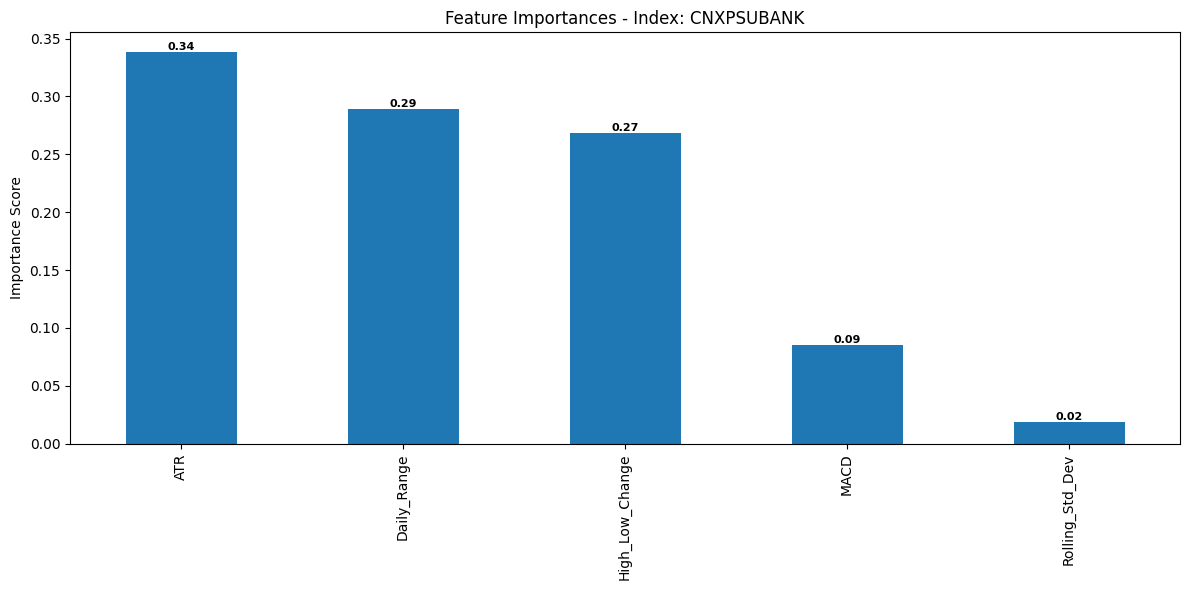

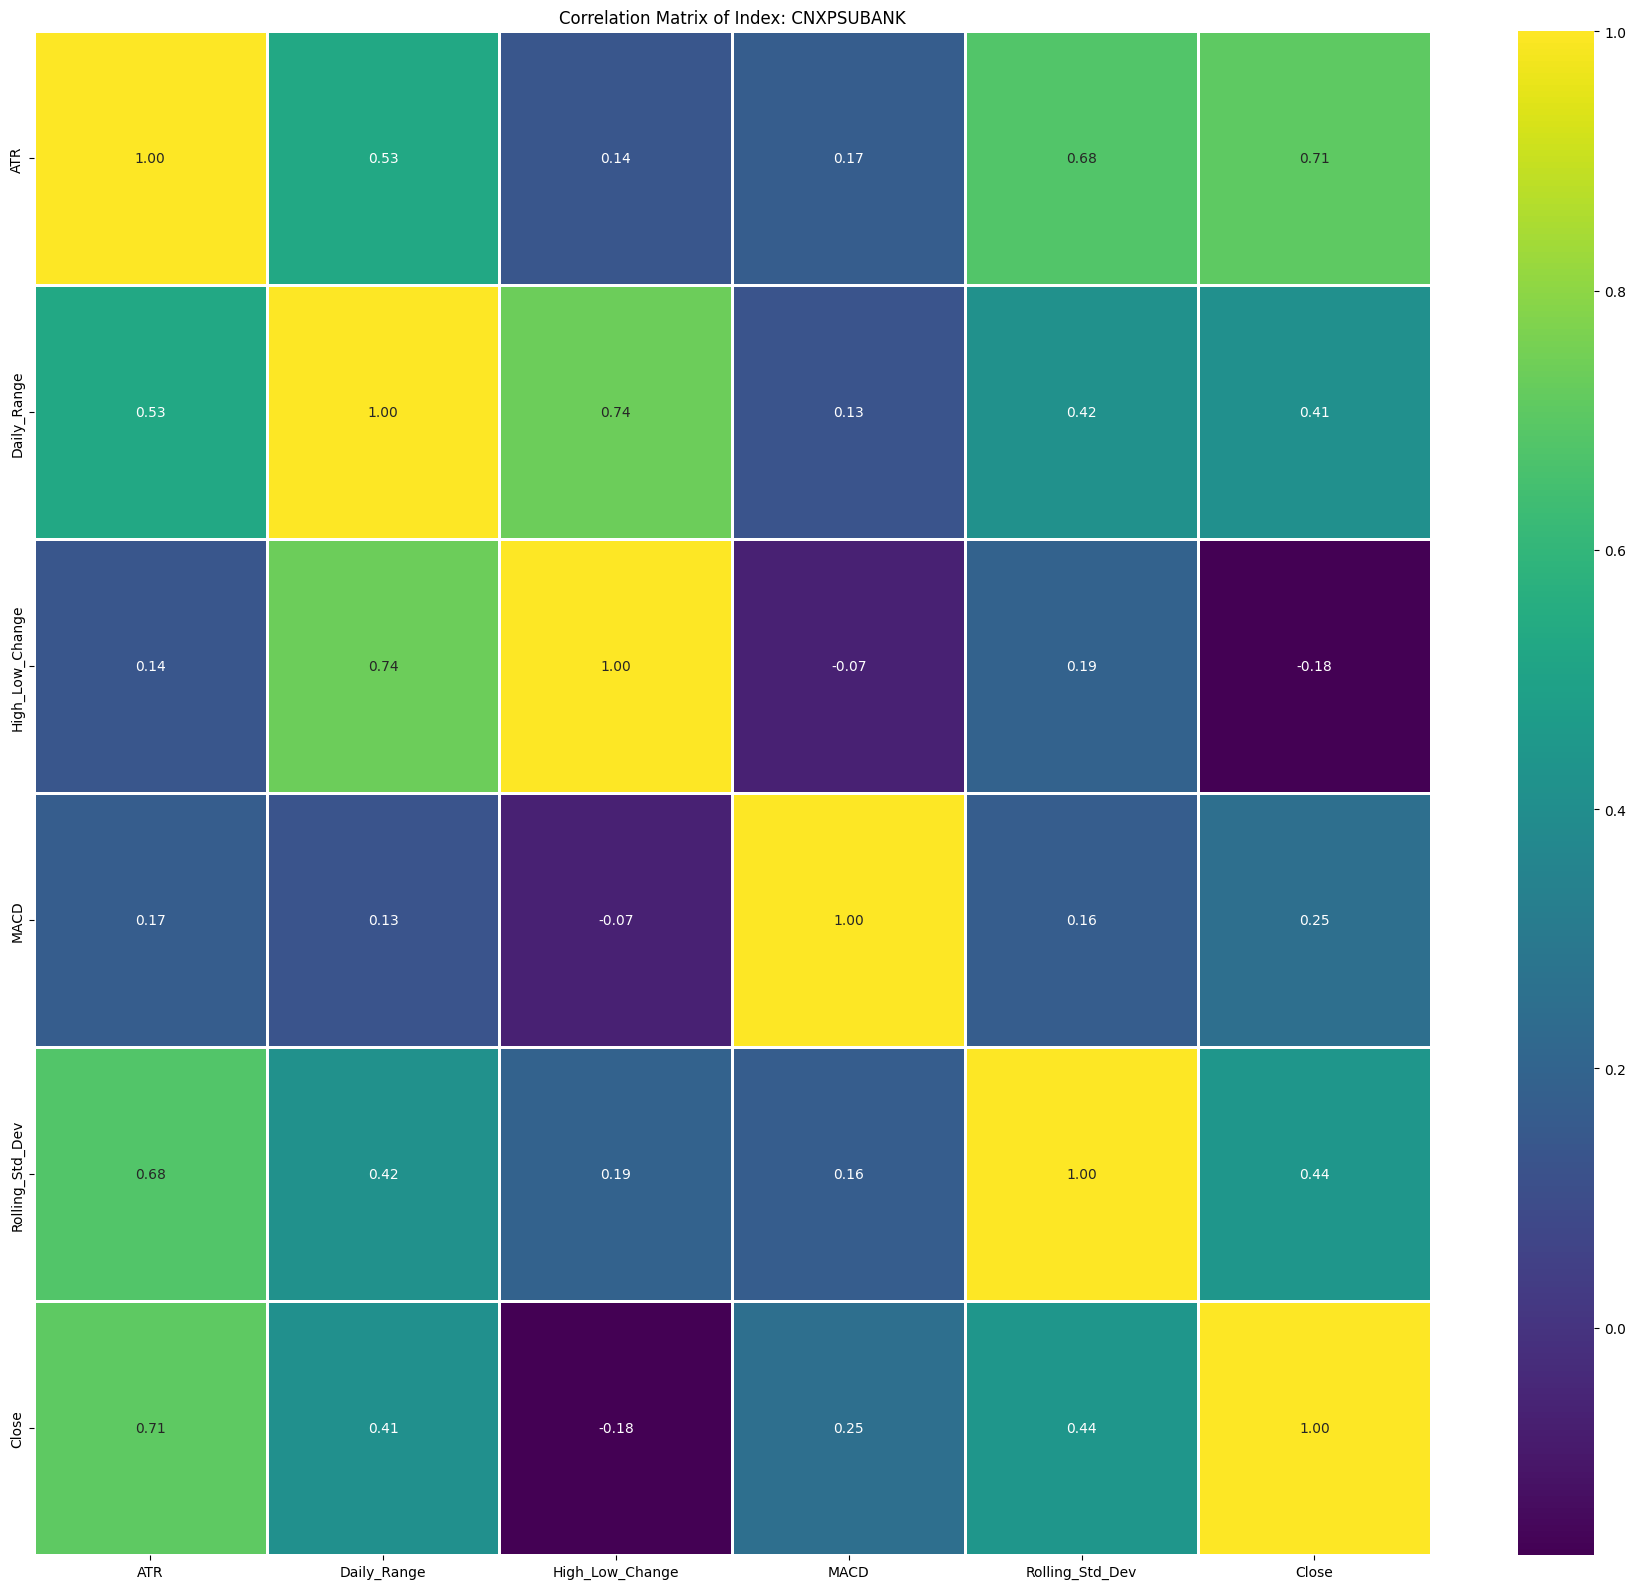


Processing Index: CNXAUTO
R-squared: -1.7346561009028907

Index: CNXAUTO - Feature Importances:
ATR                0.625644
High_Low_Change    0.176254
Daily_Range        0.166516
MACD               0.031586
dtype: float64


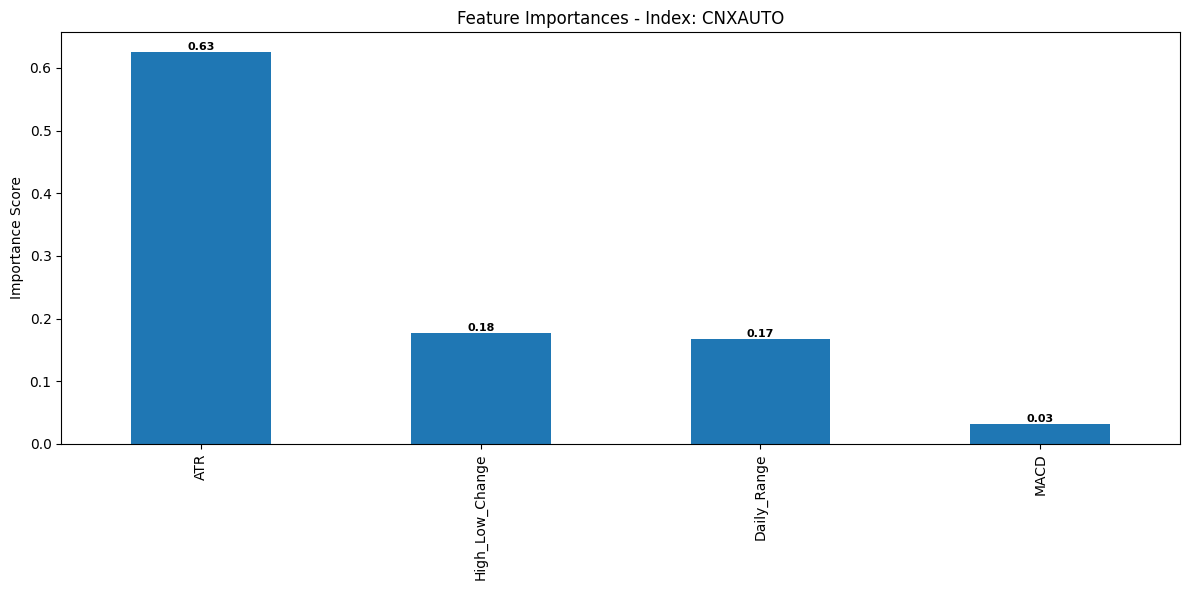

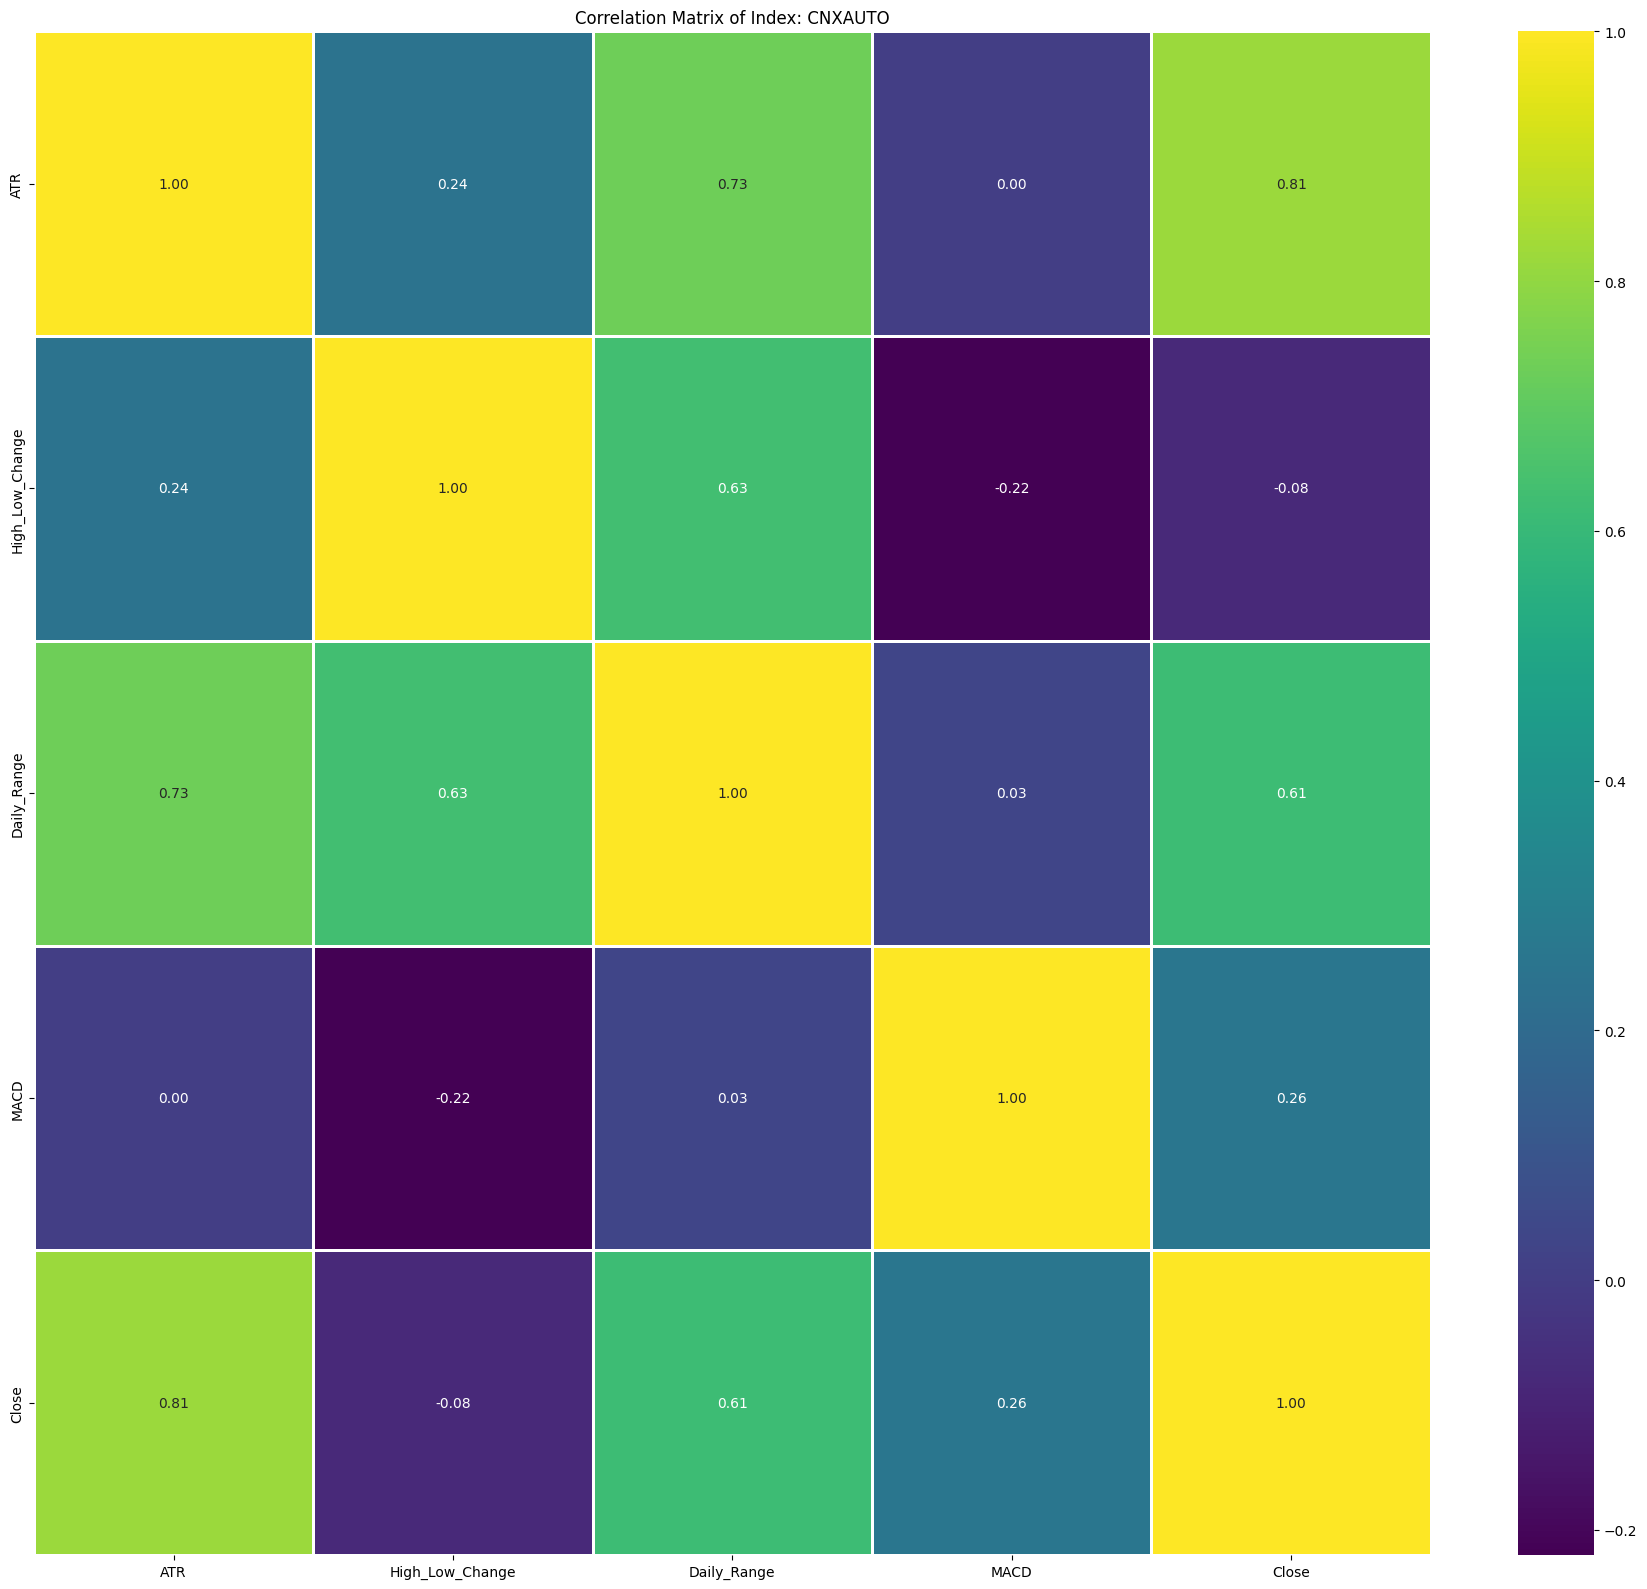


Processing Index: NIFTY_FIN_SERVICE
R-squared: -2.425814737680826

Index: NIFTY_FIN_SERVICE - Feature Importances:
ATR                0.663132
High_Low_Change    0.173567
Daily_Range        0.127378
MACD               0.035923
dtype: float64


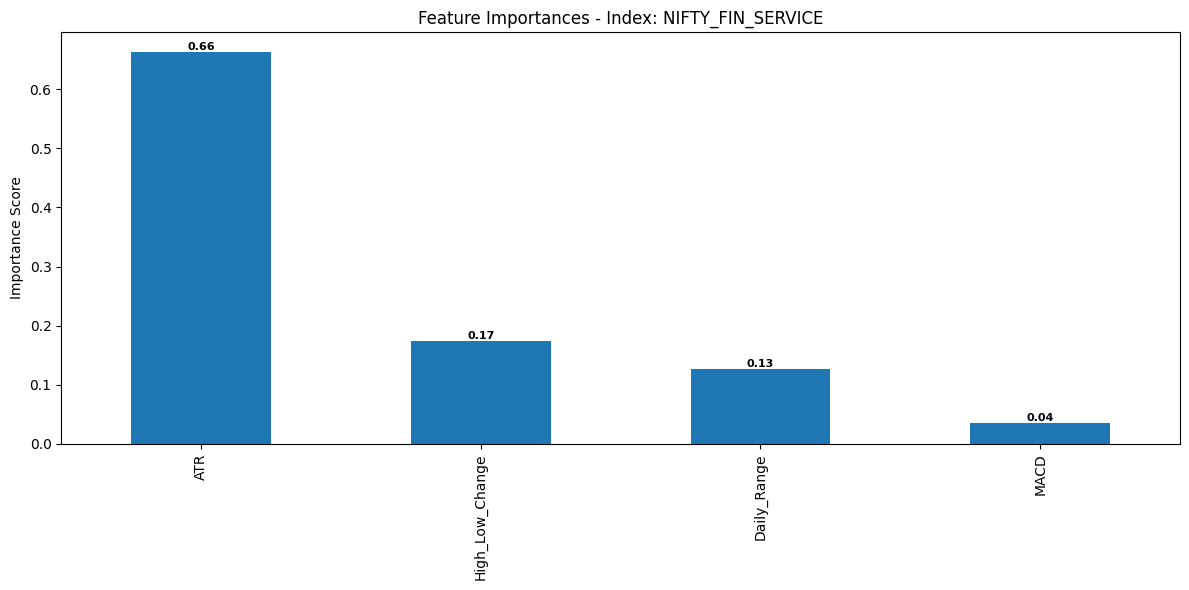

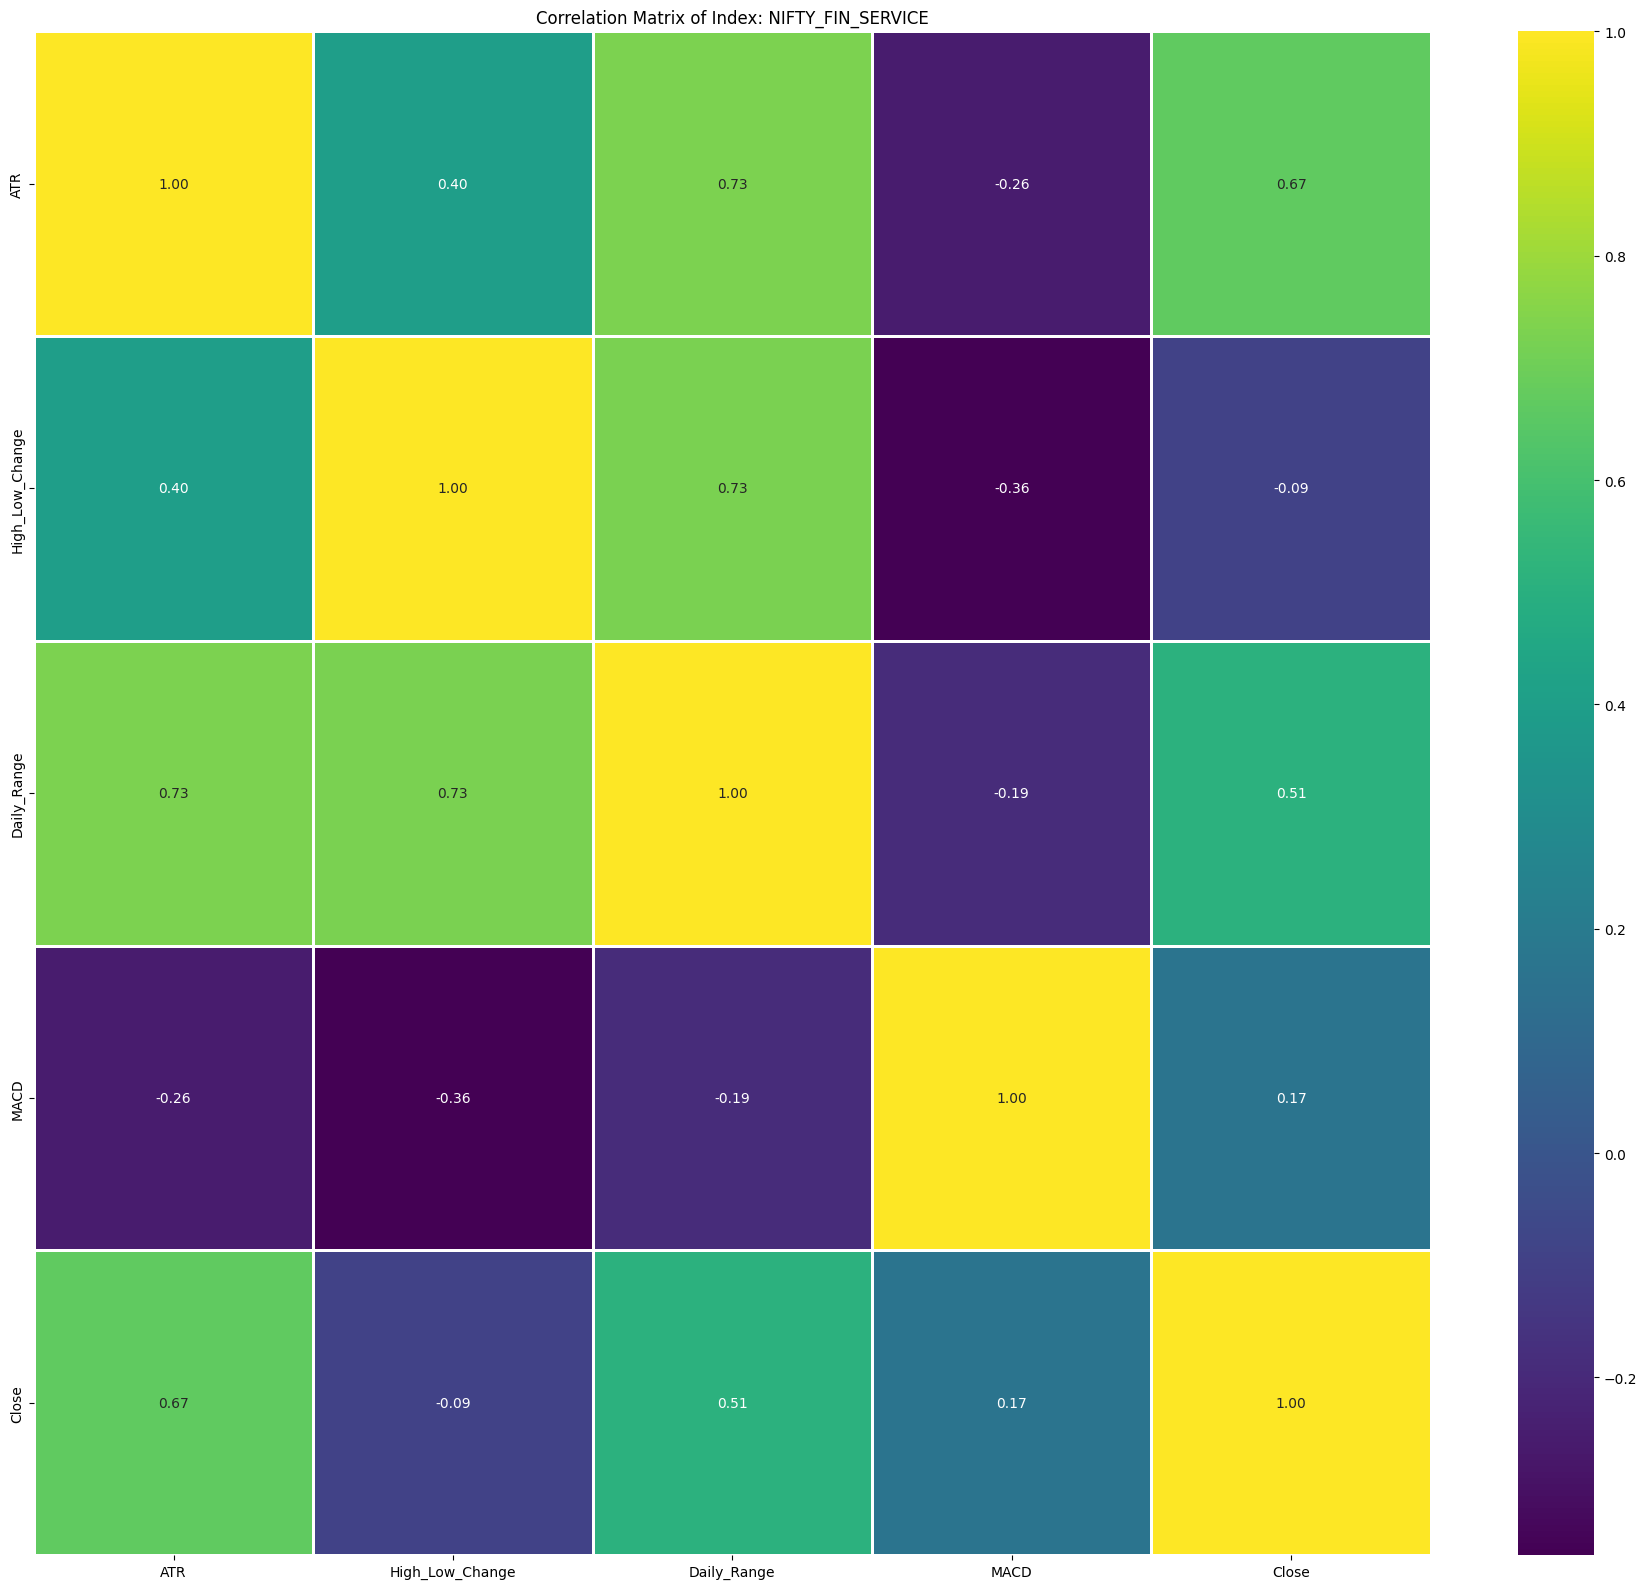

In [50]:
print("### Feature Selection for Each Index ###")
for sheet_name, df in all_indexes.items():
    asset_identifier = f"Index: {sheet_name}"
    print(f"\nProcessing {asset_identifier}")
    feat_imp = select_features_rf(df, asset_name=asset_identifier, feature_name=sheet_name, create_features=False, features_dict=index_features_dict)
    # selected_features = filter_features(feat_imp, threshold=0.01)
    # index_features_dict[sheet_name] = selected_features